# Proyecto 03 - Series de Tiempo

**Dataset: Flujo Vehicular por Unidades de Peaje AUSA**

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

**Exploración de datos**

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

**Componentes de la serie**

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

**Predicción a Futuro**

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

**Para pensar, investigar y, opcionalmente, implementar**

1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

**¡Tómate tiempo para investigar y leer mucho!**

 1. Preparación del Dataset

In [1504]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime as dt
import warnings;warnings.simplefilter('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

#fx


In [1505]:
data_2021 = pd.read_csv('flujo-vehicular-2021.csv', sep =',')
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')


# Exploración de Datos
### a) Explora la fuente de datos: 

- ¿Qué representa el dataset?
- ¿Hay información sobre las columnas?

In [1506]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [1507]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [1508]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

In [1509]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [1510]:
print(data_2020['estacion'].unique())
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())
print(data_2016['estacion'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [1511]:
print(data_2020['sentido'].unique())
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())
print(data_2016['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [1512]:
print(data_2020['tipo_vehiculo'].unique())
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())
print(data_2016['tipo_vehiculo'].unique())

['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago Doble Auto'
 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago doble Moto'
 'Pesados 2 Ejes' 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes'
 'Pesados 6 Ejes']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [1513]:
print(data_2020['forma_pago'].unique())
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())
print(data_2016['forma_pago'].unique())

['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP' 'Mercado Pago']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']



Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dataset 

**fecha**: año día mes

**hora_inicio** hora de inicio de la cuenta de vehículos (Vamos a usar esta para tomar la hora)


**hora_fin** hora de fin de la cuenta de pasos (DROP) 

**dia**: día de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes había Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varían entre los años.

**cantidad_pasos**: Cantidad de vehículos

In [1514]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2017, data_2018, data_2019 ])

### b) Realzar un análisis exploratorio que incluya:
- Explorar el head y tail de dataset.
- Calcular el tamaño
- Calcular los principales estadísticos de las columnas: media, desviación estándar, etc.
- Calcular los nulls.
- Si consideras que agrega valor informativo. agrega algún gráfico.

- Explorar el head y tail de dataset.

In [1515]:
dataset.head()

periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

In [1516]:
dataset.tail()


periodo       fecha  hora_inicio  hora_fin     dia   estacion  \
812148     2019  2019-12-31           23         0  Martes   Salguero   
812149     2019  2019-12-31           23         0  Martes   Salguero   
812150     2019  2019-12-31           23         0  Martes   Salguero   
812151     2019  2019-12-31           23         0  Martes  Sarmiento   
812152     2019  2019-12-31           23         0  Martes  Sarmiento   

          sentido tipo_vehiculo  forma_pago  cantidad_pasos  
812148  Provincia       Liviano  NO COBRADO               7  
812149  Provincia       Liviano    TELEPASE               4  
812150  Provincia        Pesado  NO COBRADO               1  
812151  Provincia       Liviano  NO COBRADO               7  
812152  Provincia       Liviano    TELEPASE               7

- Calcular el tamaño

In [1517]:
dataset.shape

(3560706, 10)

In [1518]:
dataset.columns

Index(['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion',
       'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos'],
      dtype='object')

In [1519]:
dataset.groupby(['tipo_vehiculo'])['cantidad_pasos'].sum().reset_index()

tipo_vehiculo  cantidad_pasos
0       Liviano       338164796
1        Pesado        36472911

In [1520]:
dataset.groupby(['periodo','hora_fin'])['cantidad_pasos'].sum().reset_index()

periodo  hora_fin  cantidad_pasos
0      2017         0         2444610
1      2017         1         2012805
2      2017         2         1494631
3      2017         3         1035795
4      2017         4          806483
..      ...       ...             ...
67     2019        19         8086367
68     2019        20         6905415
69     2019        21         6056895
70     2019        22         4714698
71     2019        23         3373187

[72 rows x 3 columns]

In [1521]:
var_num = []
var_cat = []

for i in dataset.columns:
  if dataset.dtypes[i] != "object":
    var_num.append(i)
  else :
    var_cat.append(i)

print(f"Variables Numericas: {var_num}")
print(f"Variables Categoricas: {var_cat}")

Variables Numericas: ['periodo', 'hora_inicio', 'hora_fin', 'cantidad_pasos']
Variables Categoricas: ['fecha', 'dia', 'estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']


- Calcular los principales estadísticos de las columnas: media, desviación estándar, etc.

In [1522]:
dataset.describe()

periodo   hora_inicio      hora_fin  cantidad_pasos
count  3.560706e+06  3.560706e+06  3.560706e+06    3.560706e+06
mean   2.017843e+03  1.195313e+01  1.207470e+01    1.052144e+02
std    7.673381e-01  6.583099e+00  6.651320e+00    3.206278e+02
min    2.017000e+03  0.000000e+00  0.000000e+00    1.000000e+00
25%    2.017000e+03  7.000000e+00  7.000000e+00    2.000000e+00
50%    2.018000e+03  1.200000e+01  1.200000e+01    8.000000e+00
75%    2.018000e+03  1.700000e+01  1.800000e+01    3.400000e+01
max    2.019000e+03  2.300000e+01  2.300000e+01    6.677000e+03

- Calcular los nulls.

In [1523]:
dataset.isna().sum()

periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64

In [1524]:
dataset["fecha"] = pd.to_datetime(dataset["fecha"])

In [1525]:
dataset["hour"] = dataset["fecha"].dt.hour
dataset["fecha"] = dataset["fecha"].dt.normalize()

In [1526]:
dataset.head(1).append(dataset.tail(1))

periodo      fecha  hora_inicio  hora_fin      dia   estacion  \
0          2017 2017-01-01            0         1  Domingo    Alberdi   
812152     2019 2019-12-31           23         0   Martes  Sarmiento   

          sentido tipo_vehiculo  forma_pago  cantidad_pasos  hour  
0          Centro       Liviano  NO COBRADO              25     0  
812152  Provincia       Liviano    TELEPASE               7     0

In [1527]:
# Construccion del calendario completo
calendario_completo = pd.Series(pd.date_range(start = "2017-01-01",
                                              end = "2019-12-31", 
                                              freq = "D"))

In [1528]:
calendario_completo.shape[0]

1095

In [1529]:
len(dataset.fecha.unique())

1095

In [1530]:
len(dataset.fecha.unique())

1095

In [1531]:
calendario_completo.shape[0] - len(dataset.fecha.unique())

0

podemos verificar que no falta ninguna fecha.

- Si consideras que agrega valor informativo. agrega algún gráfico.

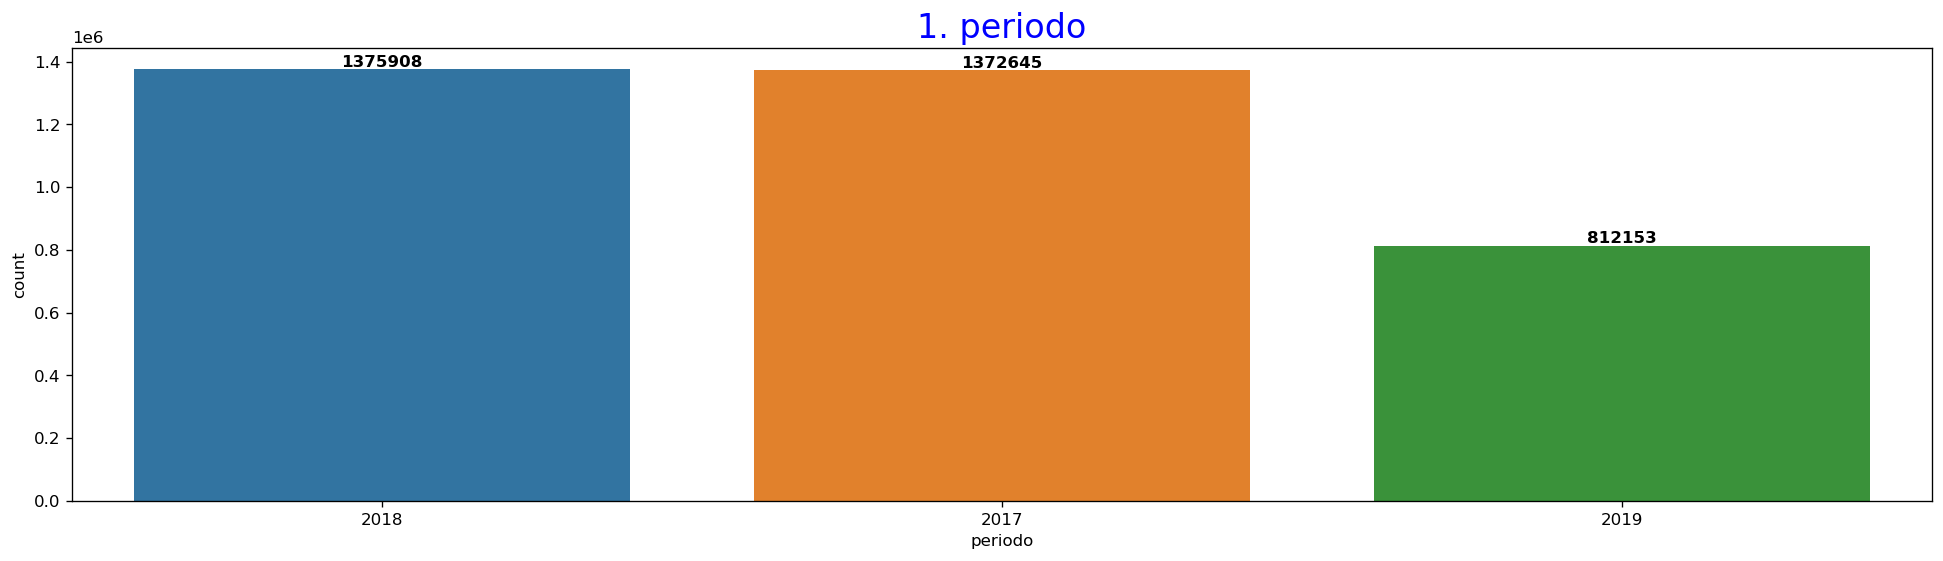

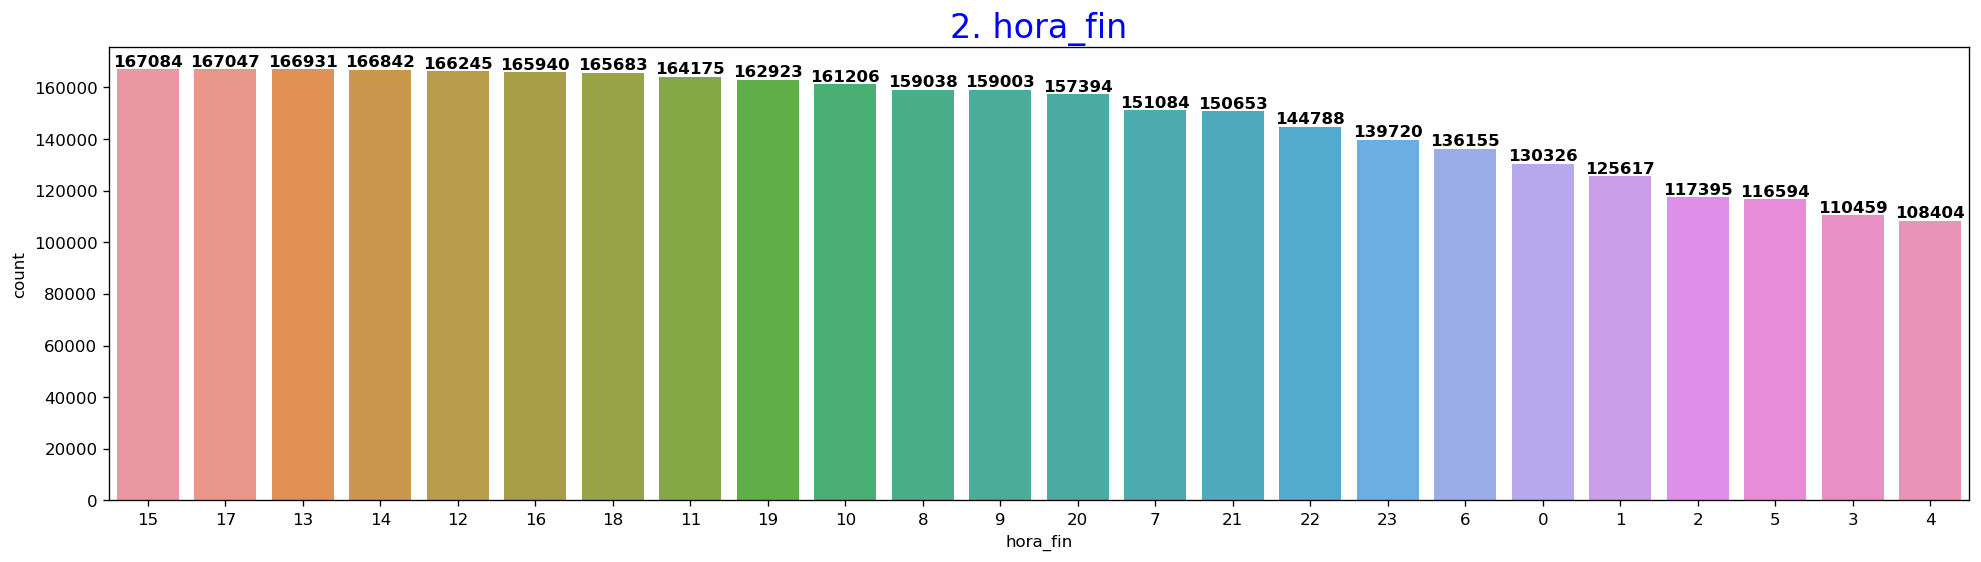

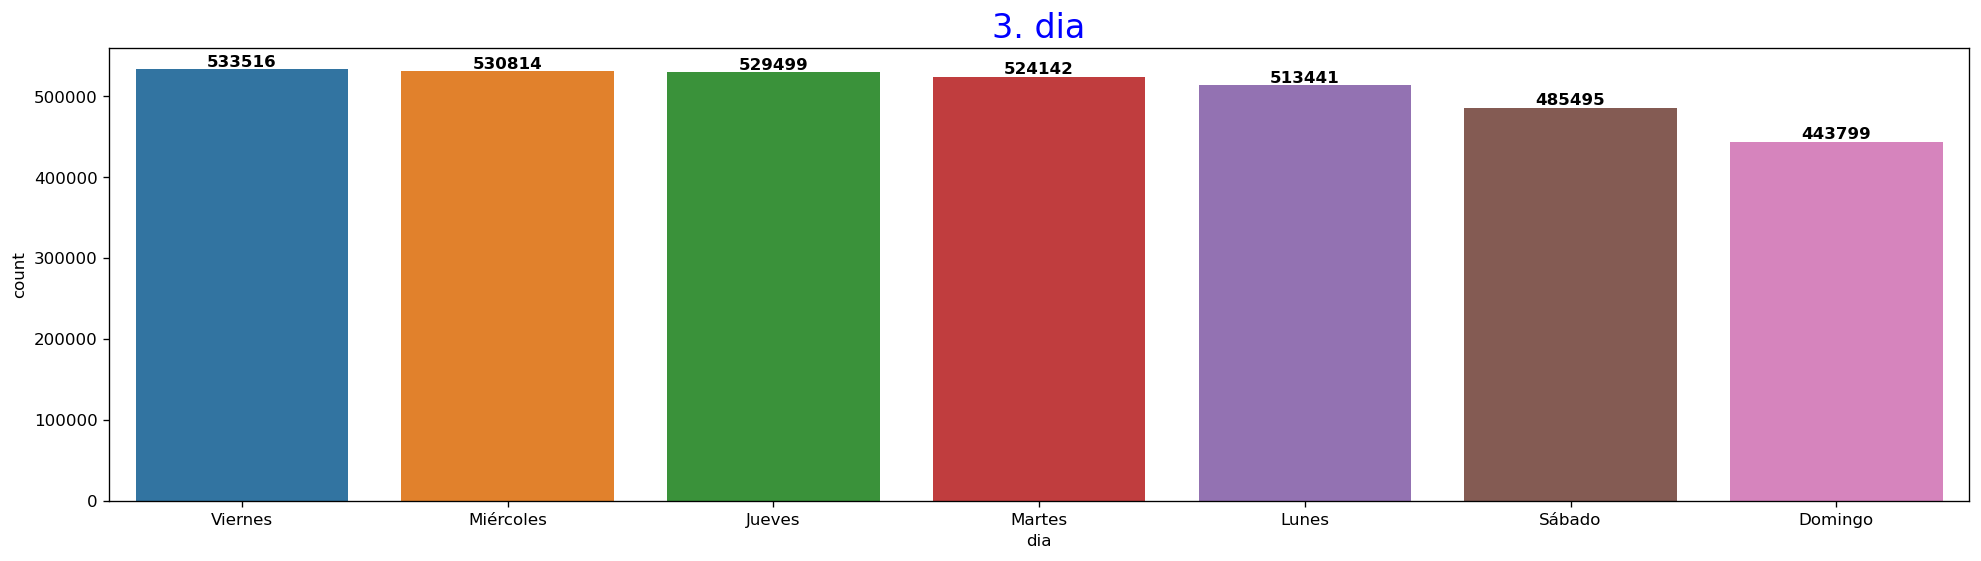

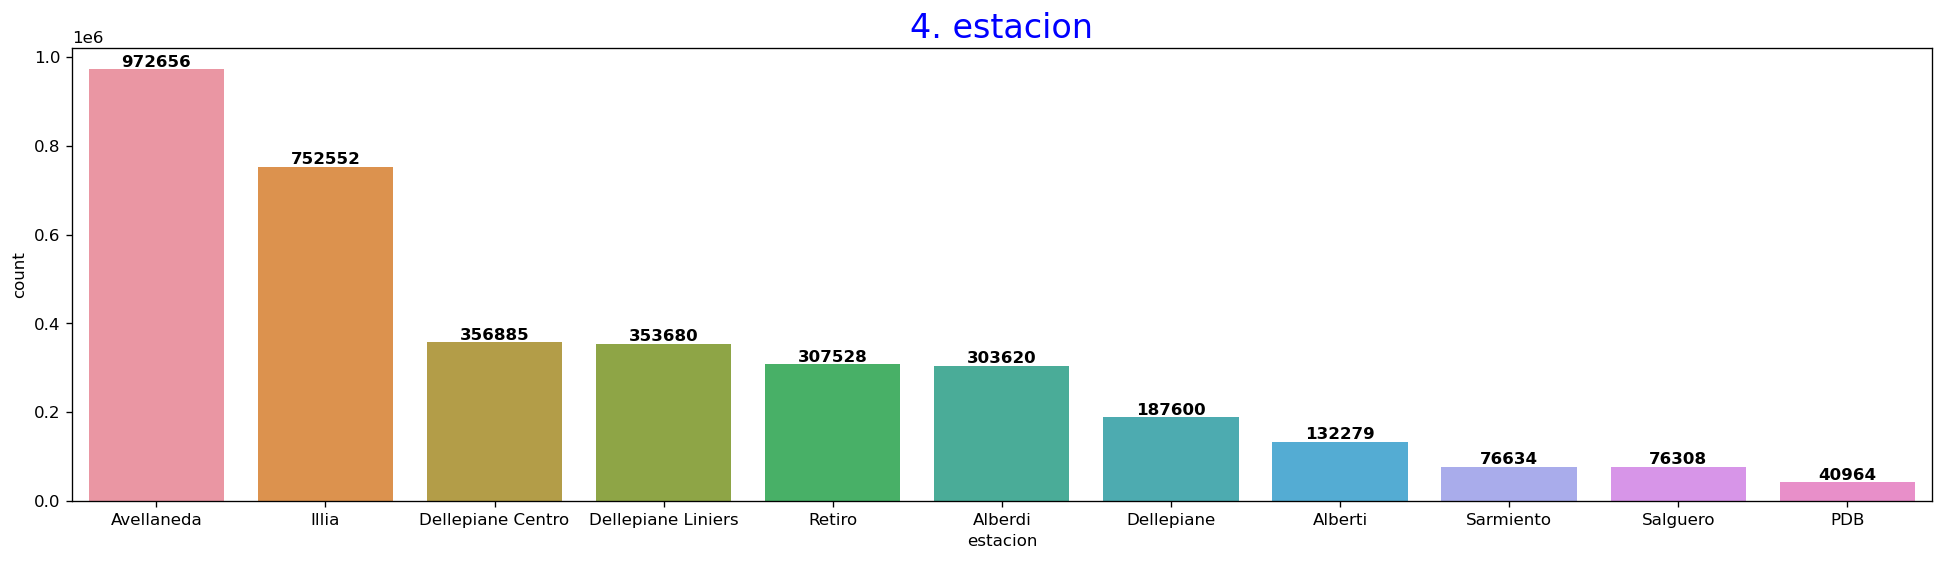

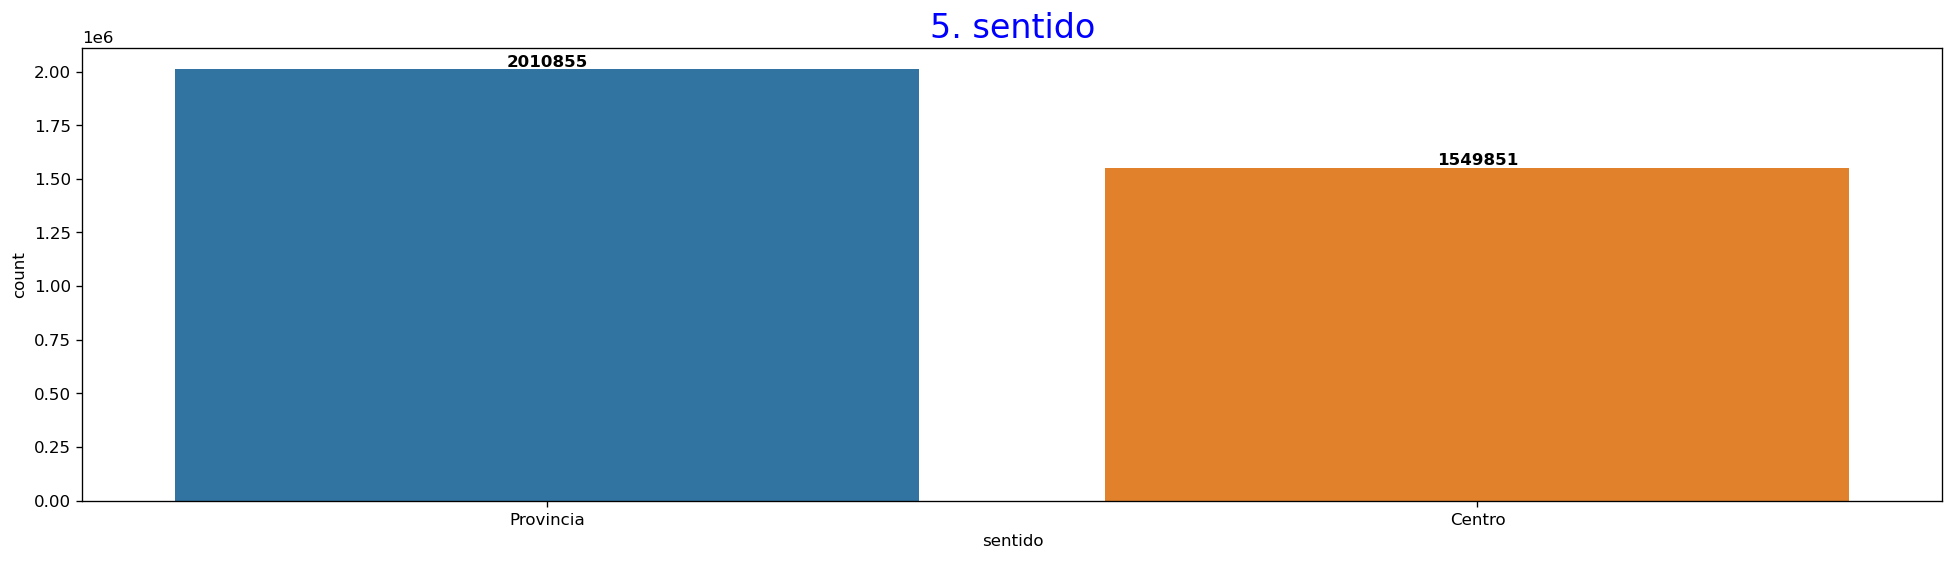

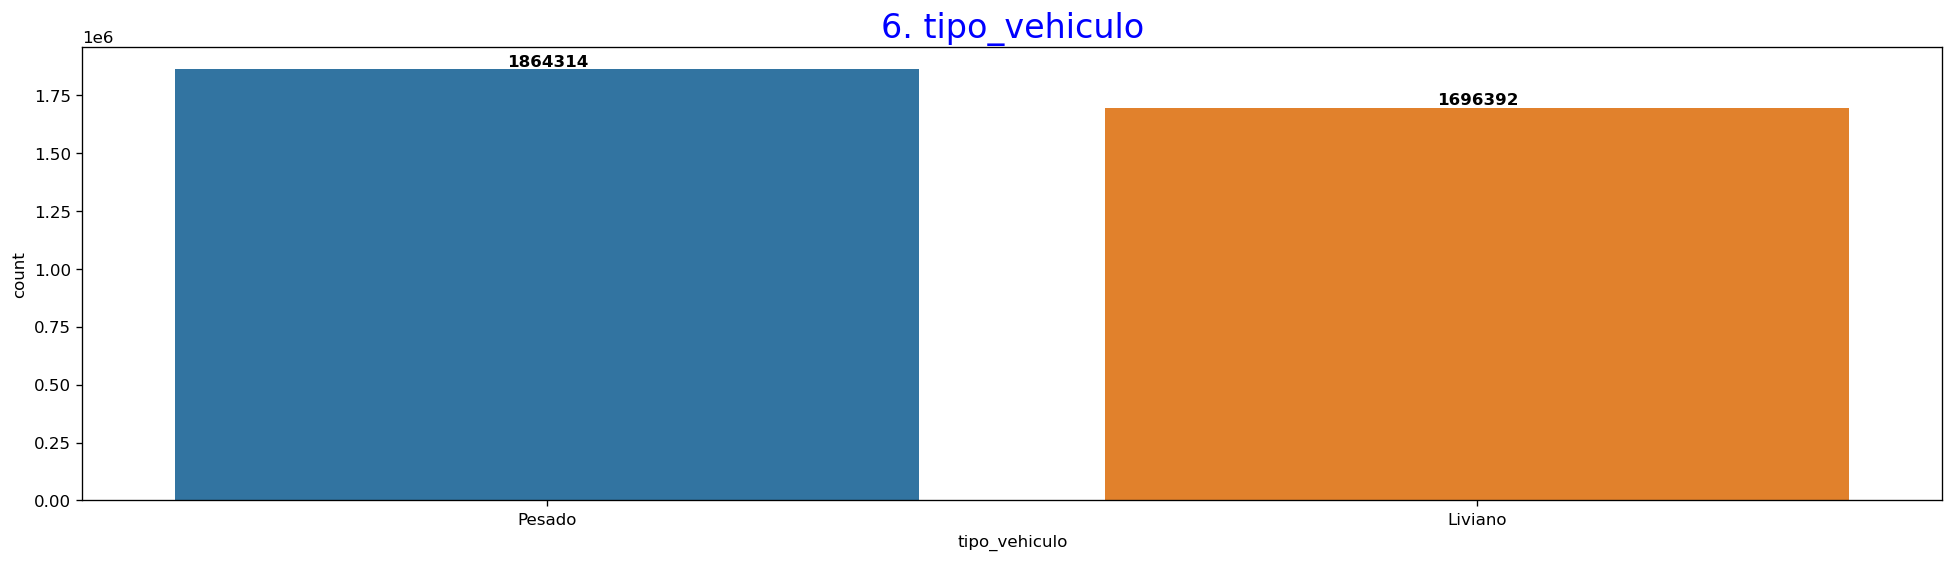

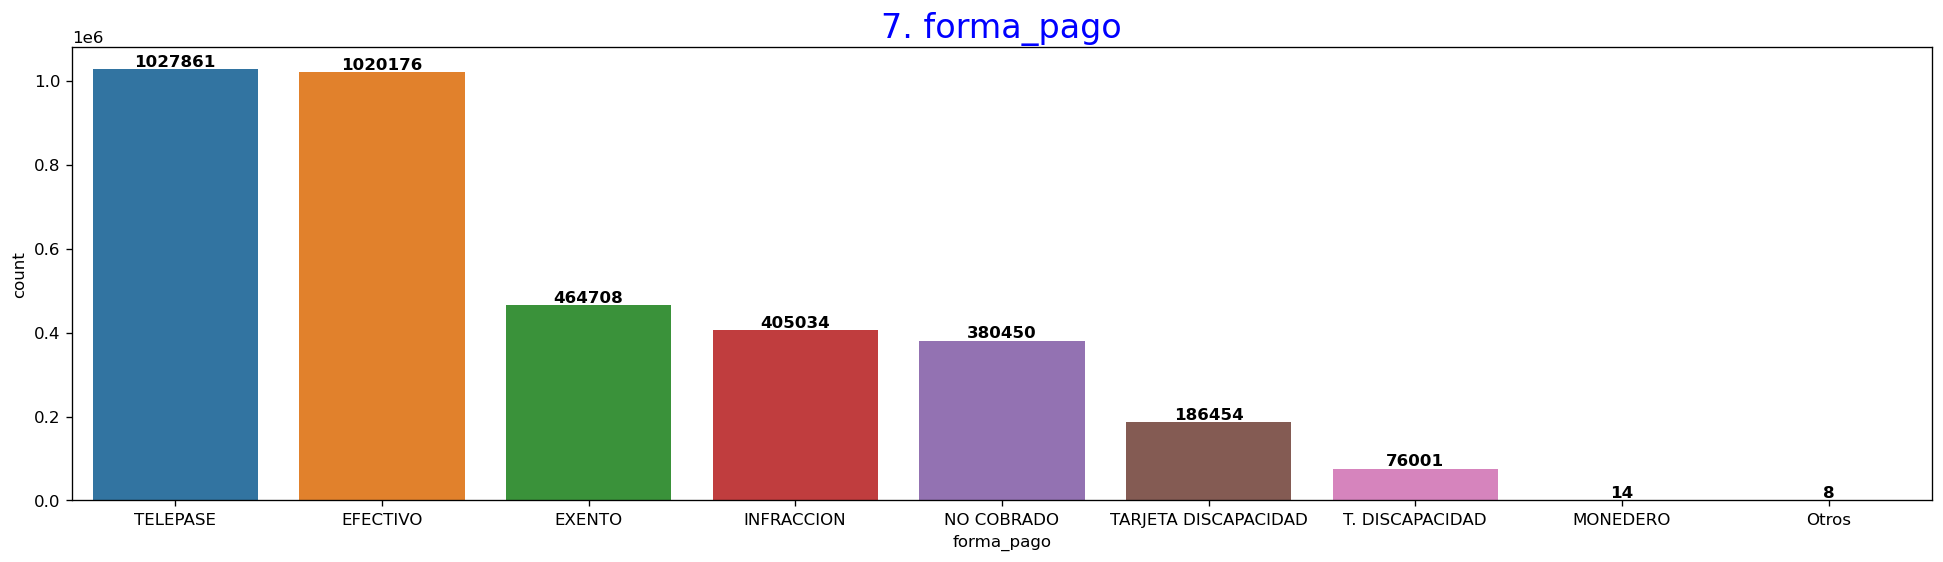

In [1532]:
# print(i, col)
plt.figure(figsize = (20,5))
# plt.subplot(1,3,i+1)
#plt.figure(i)
sns.countplot(x= 'periodo' , data=dataset
              # ,palette="Spectral"
              , order = dataset['periodo'].value_counts().index
              )
plt.title( '1. periodo', size =  20, color = 'b')
for i, v in enumerate(dataset['periodo'].value_counts().to_numpy()):
    plt.text(i, v, str(v), fontweight='bold' ,ha='center', va='bottom')
plt.show()

for i, col in enumerate(dataset.columns[3:-2]):
    # print(i, col)
    plt.figure(figsize = (20,5))
    # plt.subplot(1,3,i+1)
    #plt.figure(i)
    sns.countplot(x=col, data=dataset
                  # ,palette="Spectral"
                  , order = dataset[col].value_counts().index
                  )
    plt.title( str(i+2) +". "+ col, size =  20, color = 'b')
    for i, v in enumerate(dataset[col].value_counts().to_numpy()):
        plt.text(i, v, str(v), fontweight='bold' ,ha='center', va='bottom')
    plt.show()

Cabe destacar que los gráficos indican la cantidad de registro por cada una de las categorías.

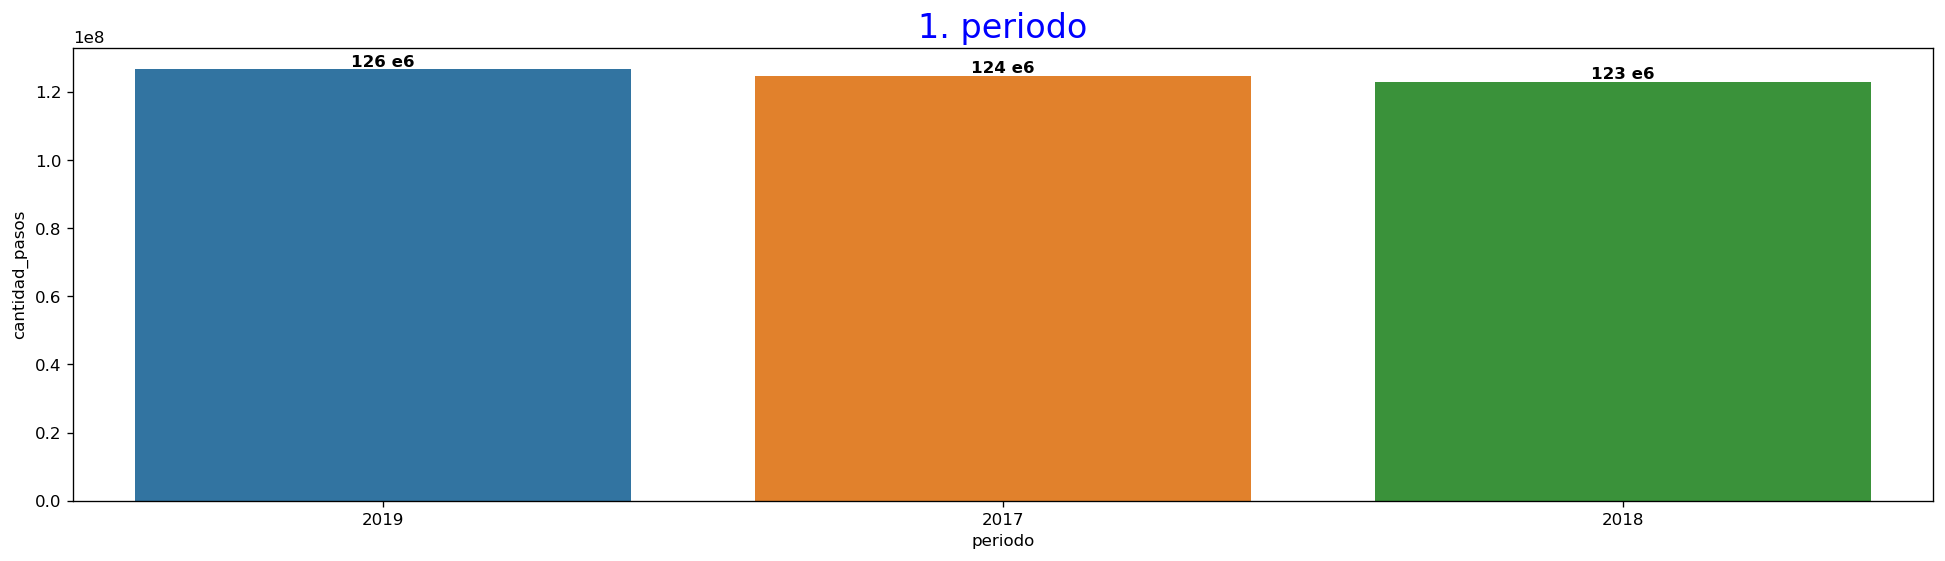

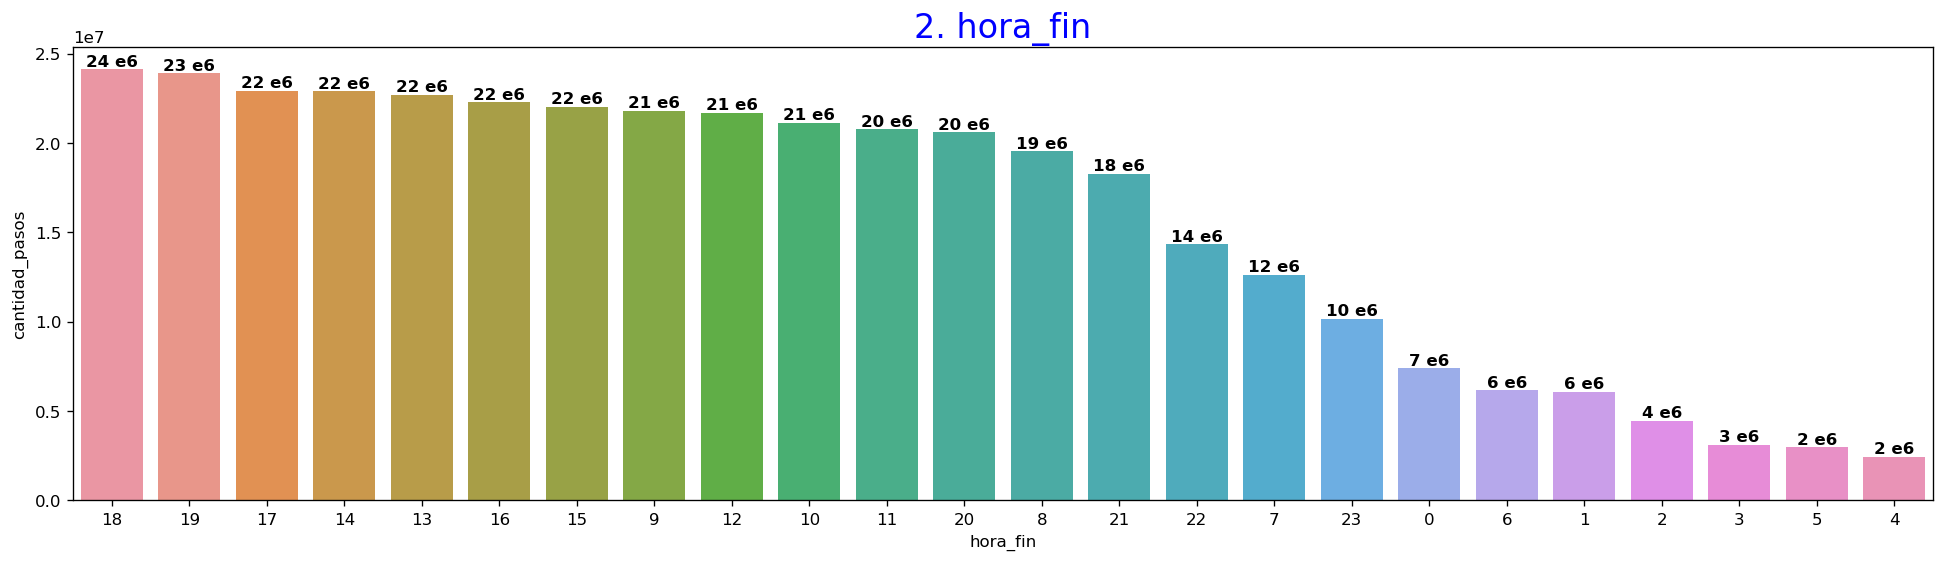

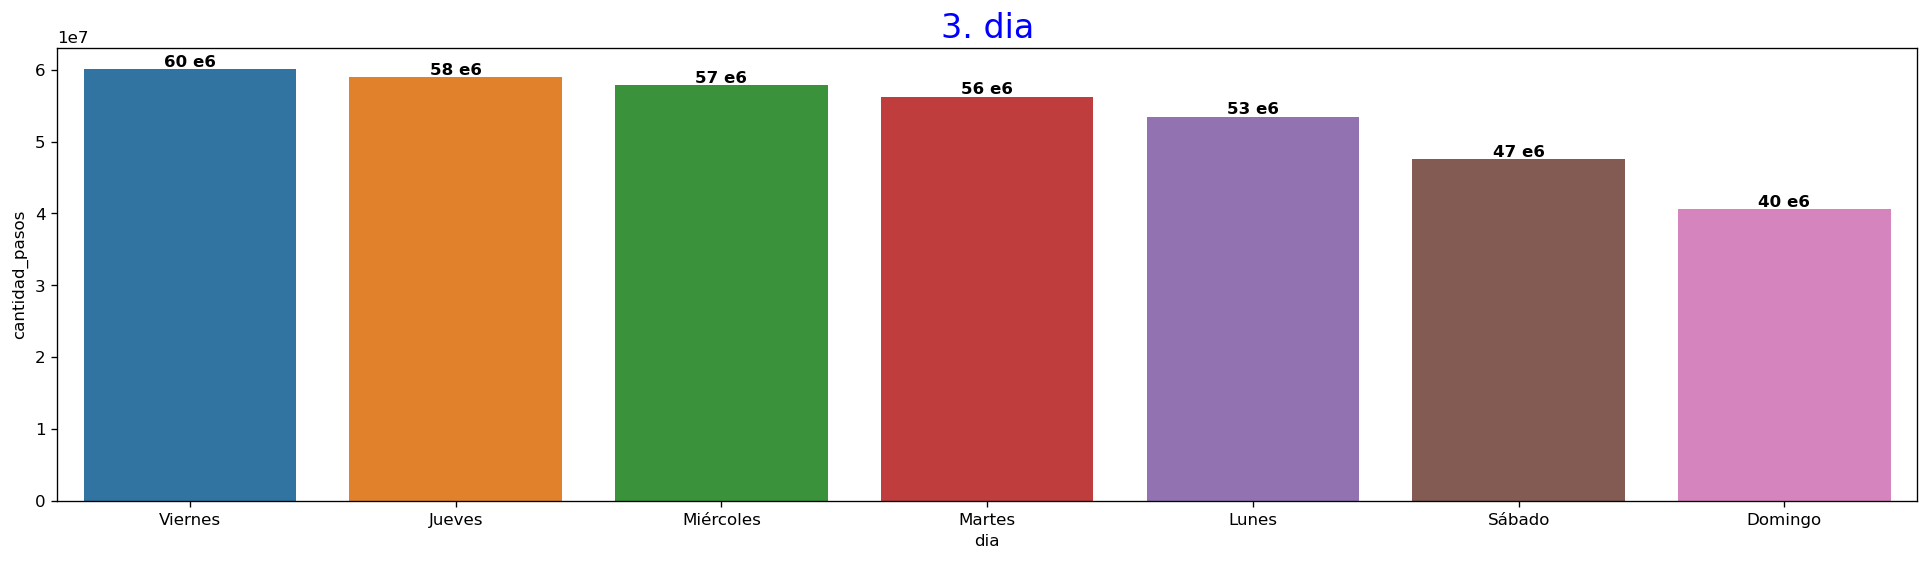

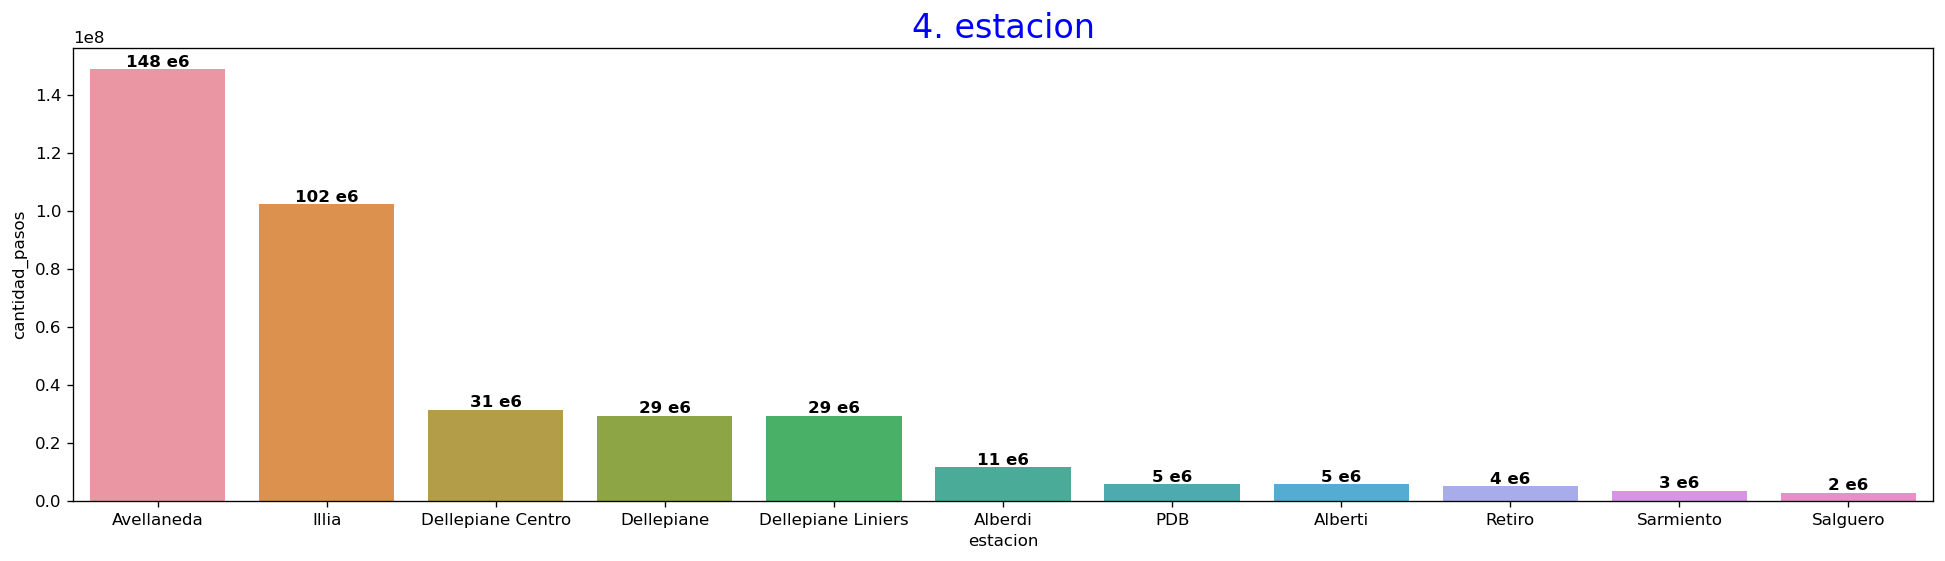

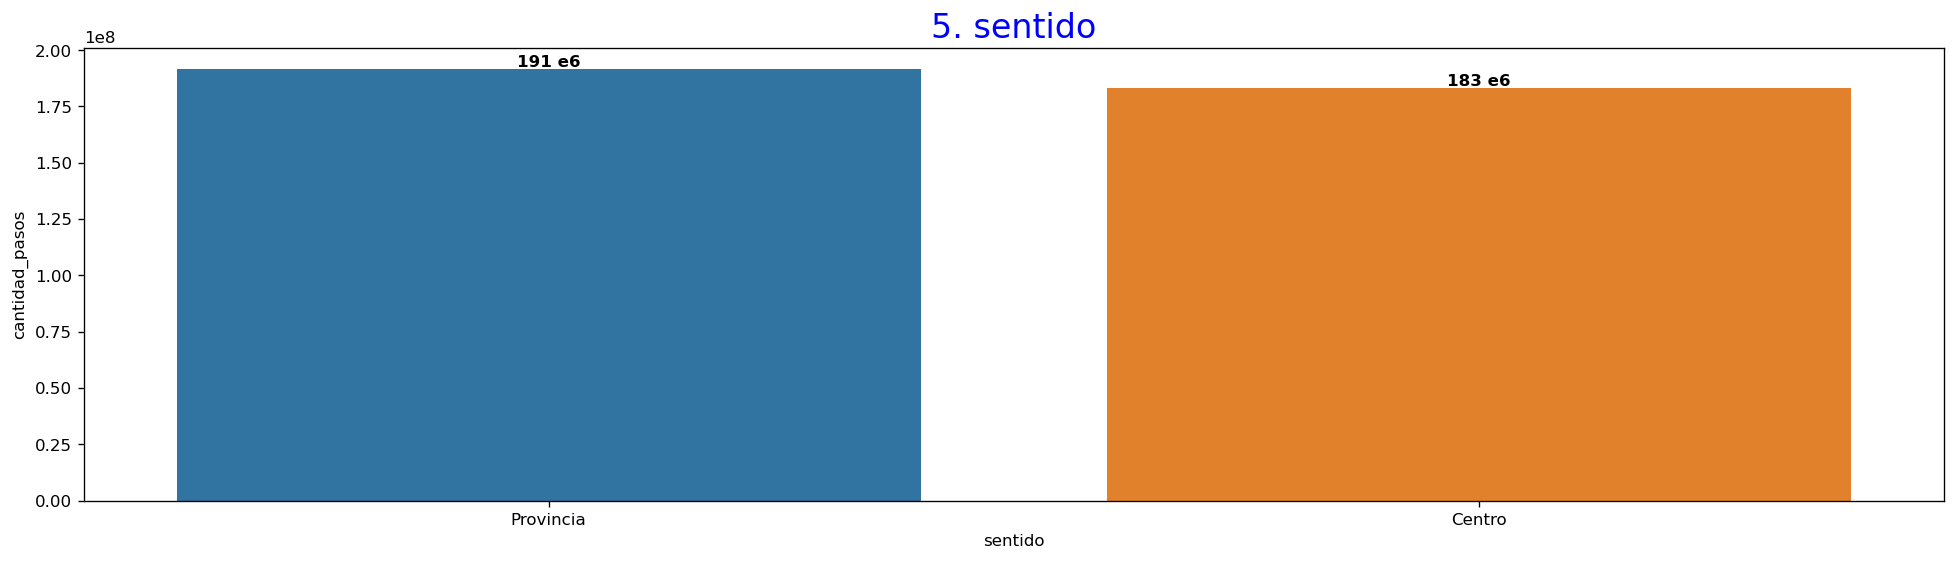

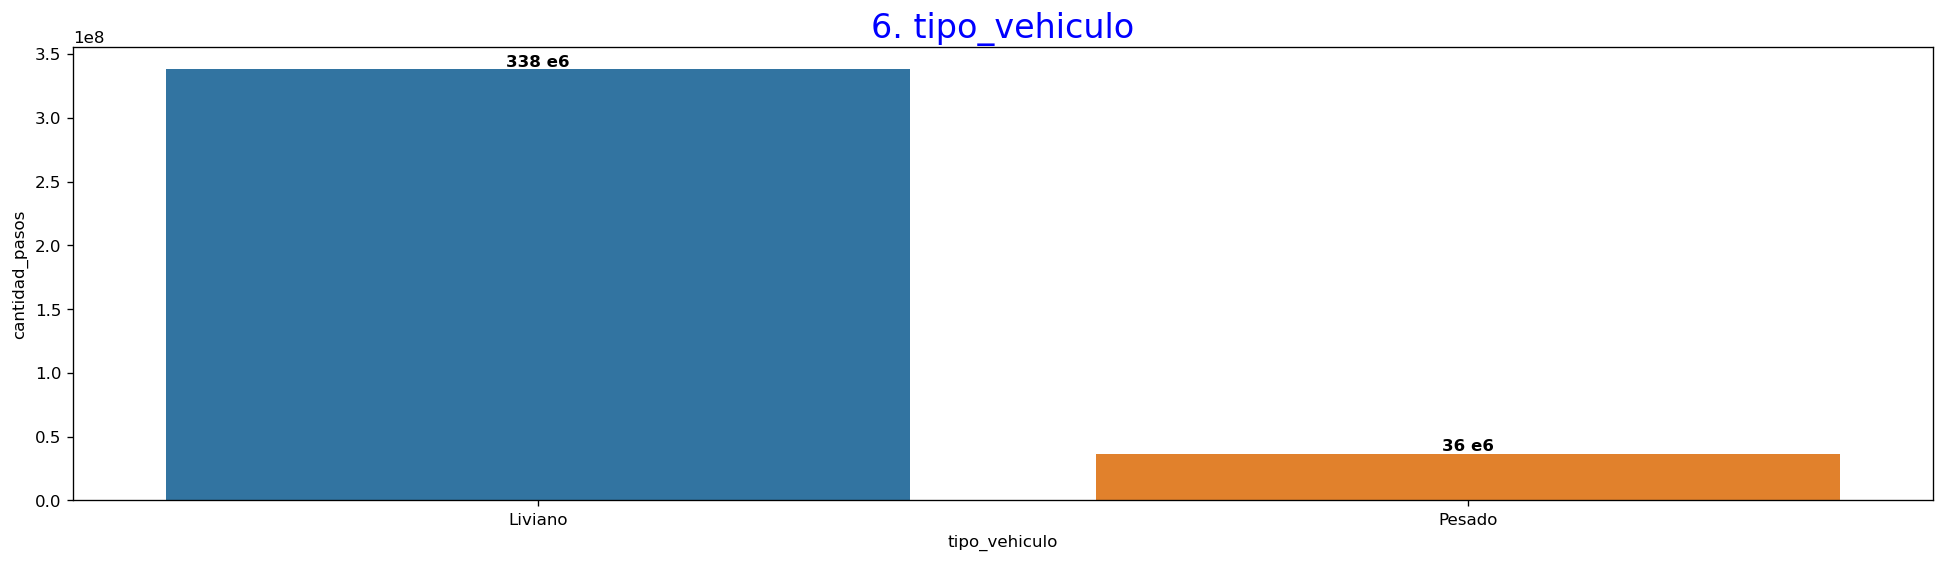

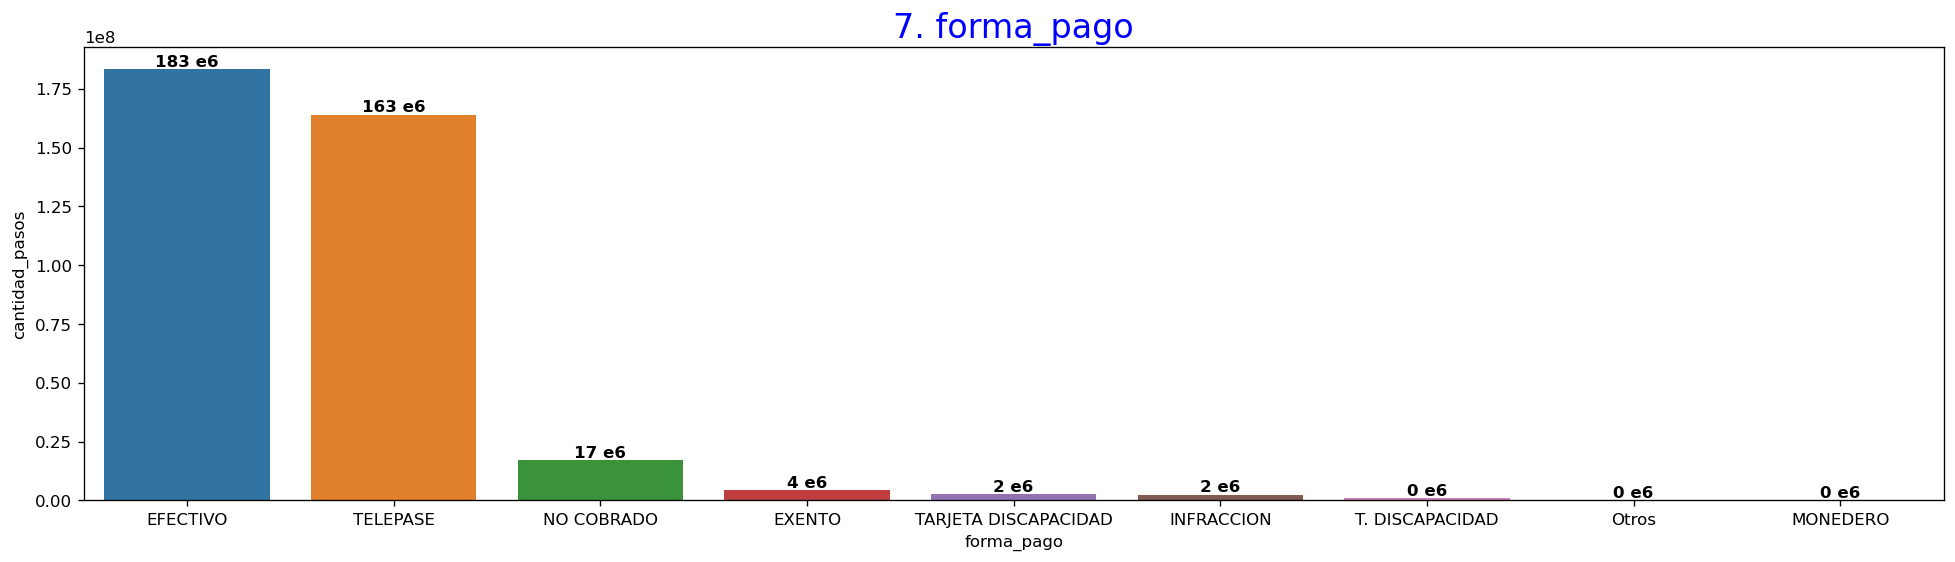

In [1533]:
# print(i, col)
plt.figure(figsize = (20,5))
# plt.subplot(1,3,i+1)
#plt.figure(i)
sns.barplot(x= 'periodo', y = 'cantidad_pasos' , data=dataset.groupby(['periodo'])['cantidad_pasos'].sum().reset_index()
              # ,palette="Spectral"
              # , order = dataset['periodo'].value_counts().index
              , order= dataset.groupby(['periodo'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['periodo'].to_numpy()

              )
plt.title( '1. periodo', size =  20, color = 'b')
for i, v in enumerate(dataset.groupby(['periodo'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
plt.show()

for i, col in enumerate(dataset.columns[3:-2]):
    # print(i, col)
    plt.figure(figsize = (20,5))
    # plt.subplot(1,3,i+1)
    #plt.figure(i)
    sns.barplot(x= col, y = 'cantidad_pasos', data=dataset.groupby([col])['cantidad_pasos'].sum().reset_index()
              # ,palette="Spectral"
              , order = dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)[col].to_numpy()
              )
    plt.title( str(i+2) +". "+ col, size =  20, color = 'b')
    for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
      plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
    plt.show()

In [1534]:
dataset.columns

Index(['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion',
       'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos', 'hour'],
      dtype='object')

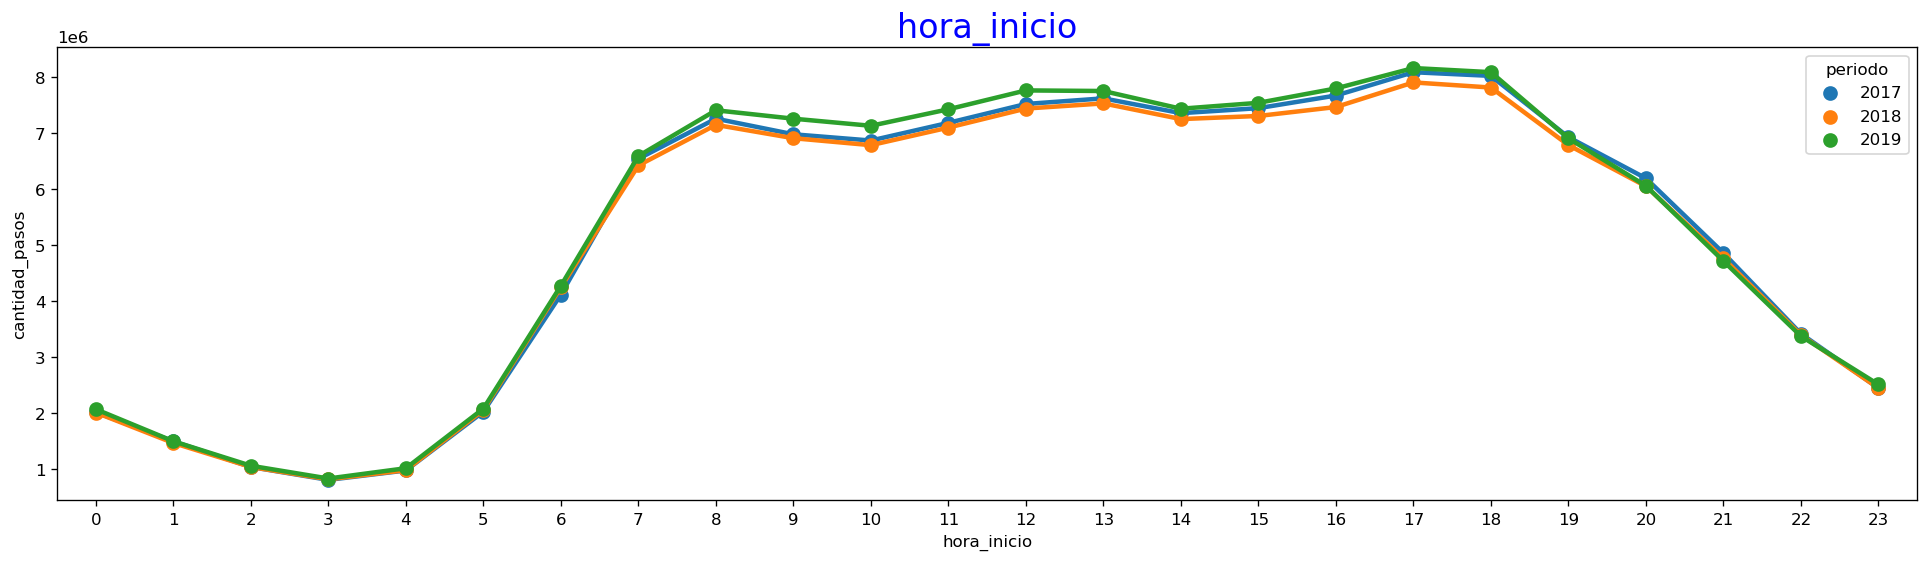

In [1535]:
    plt.figure(figsize = (20,5))

    sns.pointplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'periodo', data=dataset.groupby(['periodo','hora_inicio'])['cantidad_pasos'].sum().reset_index()
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
    plt.title( 'hora_inicio', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
    plt.show()

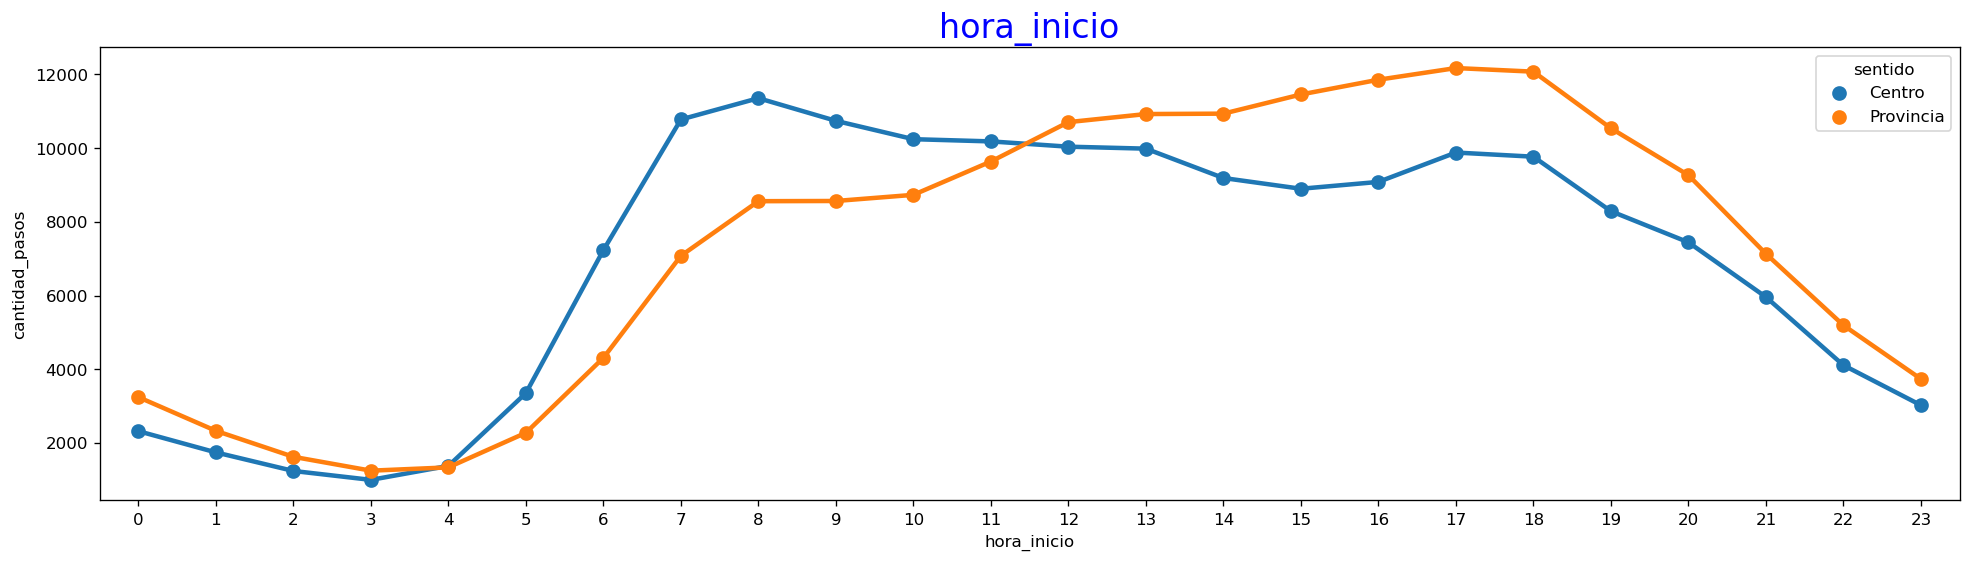

In [1536]:
   pasados_semtido_mean =  dataset.groupby(['sentido','hora_inicio','fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['sentido','hora_inicio'], as_index =False)['cantidad_pasos'].agg({'cantidad_pasos':'mean'})

   plt.figure(figsize = (20,5))

   sns.pointplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'sentido', data=pasados_semtido_mean
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
   plt.title( 'hora_inicio', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
   plt.show()

In [1537]:
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'TELEPASE')
dataseta = dataset[mask]
pasados_semtido_mean =  dataseta.groupby(['sentido','hora_inicio','fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['sentido','hora_inicio'], as_index =False)['cantidad_pasos'].agg({'cantidad_pasos':'mean'})


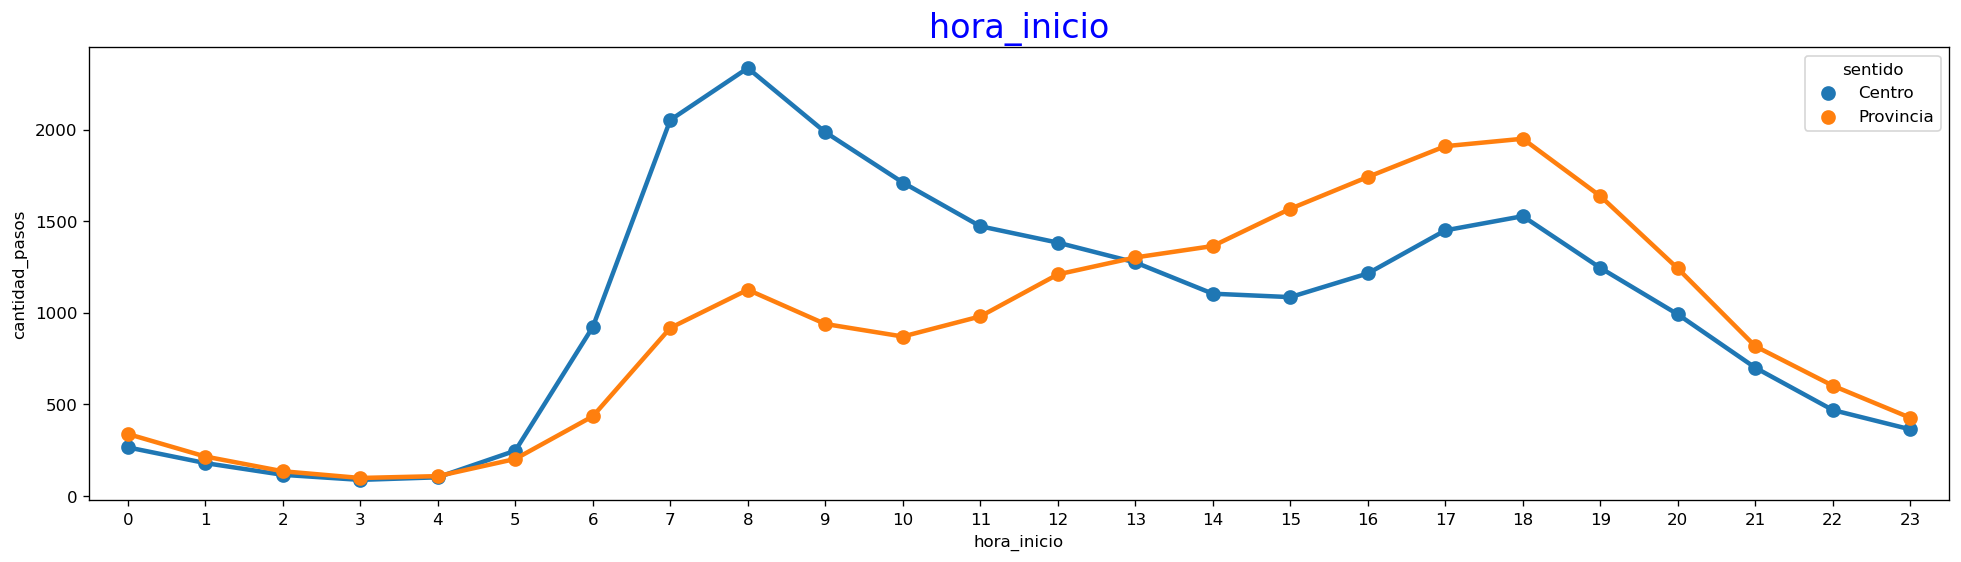

In [1538]:
   plt.figure(figsize = (20,5))

   sns.pointplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'sentido', data=pasados_semtido_mean
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
   plt.title( 'hora_inicio', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
   plt.show()

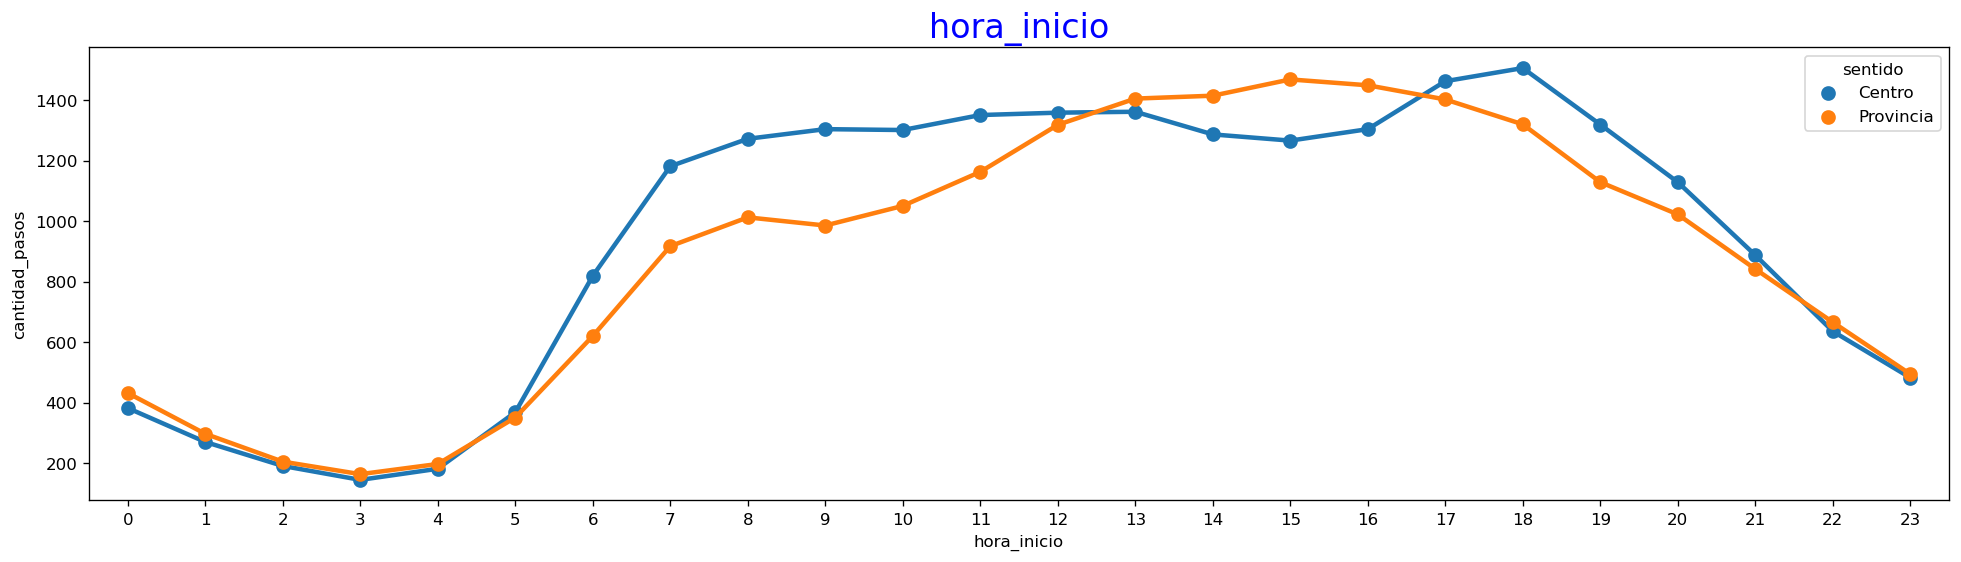

In [1539]:
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataseta = dataset[mask]
pasados_semtido_mean =  dataseta.groupby(['sentido','hora_inicio','fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['sentido','hora_inicio'], as_index =False)['cantidad_pasos'].agg({'cantidad_pasos':'mean'})

plt.figure(figsize = (20,5))

sns.pointplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'sentido', data=pasados_semtido_mean
            # ,palette="Spectral"
            # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
            )
plt.title( 'hora_inicio', size =  20, color = 'b')
# for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
#   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
plt.show()

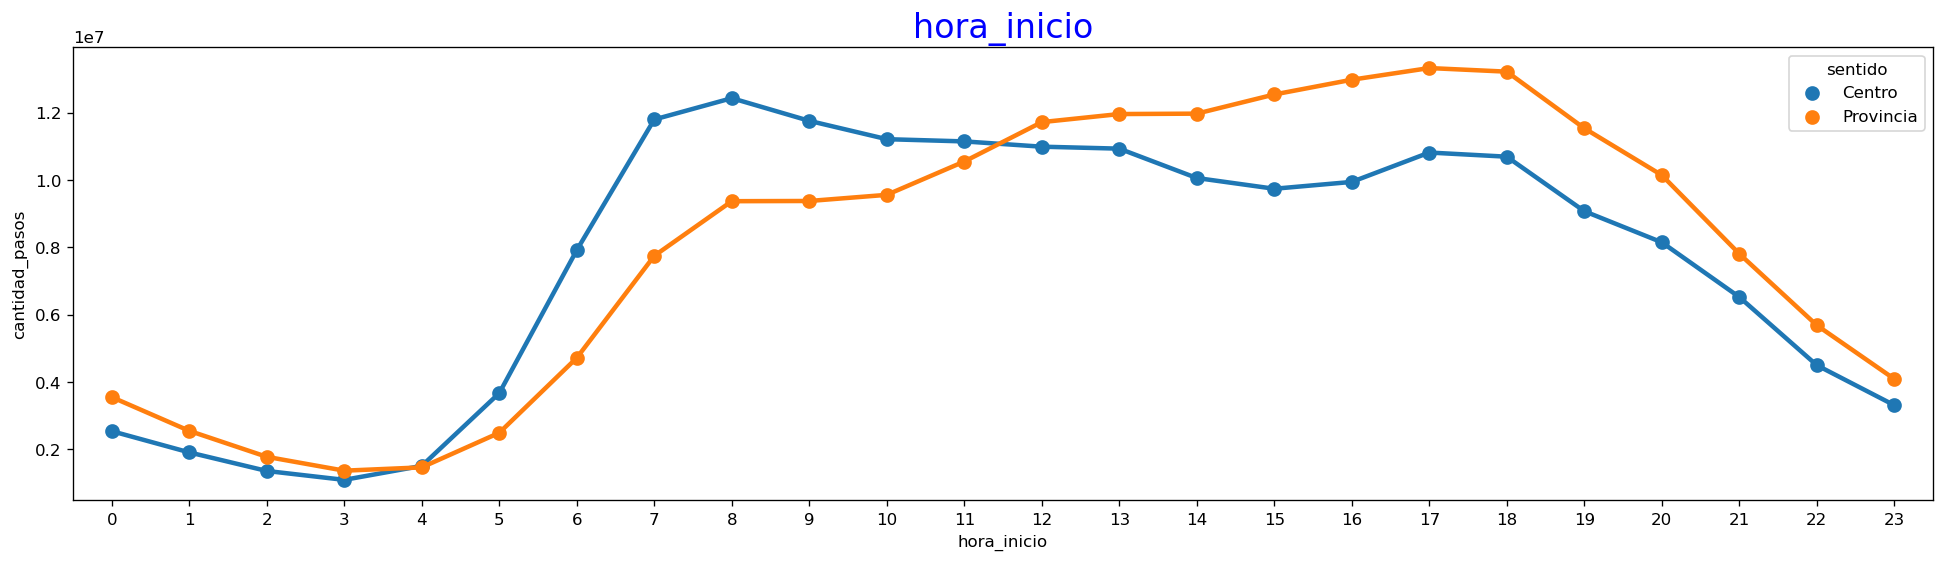

In [1540]:
   plt.figure(figsize = (20,5))

   sns.pointplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'sentido', data=dataset.groupby(['sentido','hora_inicio'])['cantidad_pasos'].sum().reset_index()
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
   plt.title( 'hora_inicio', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
   plt.show()

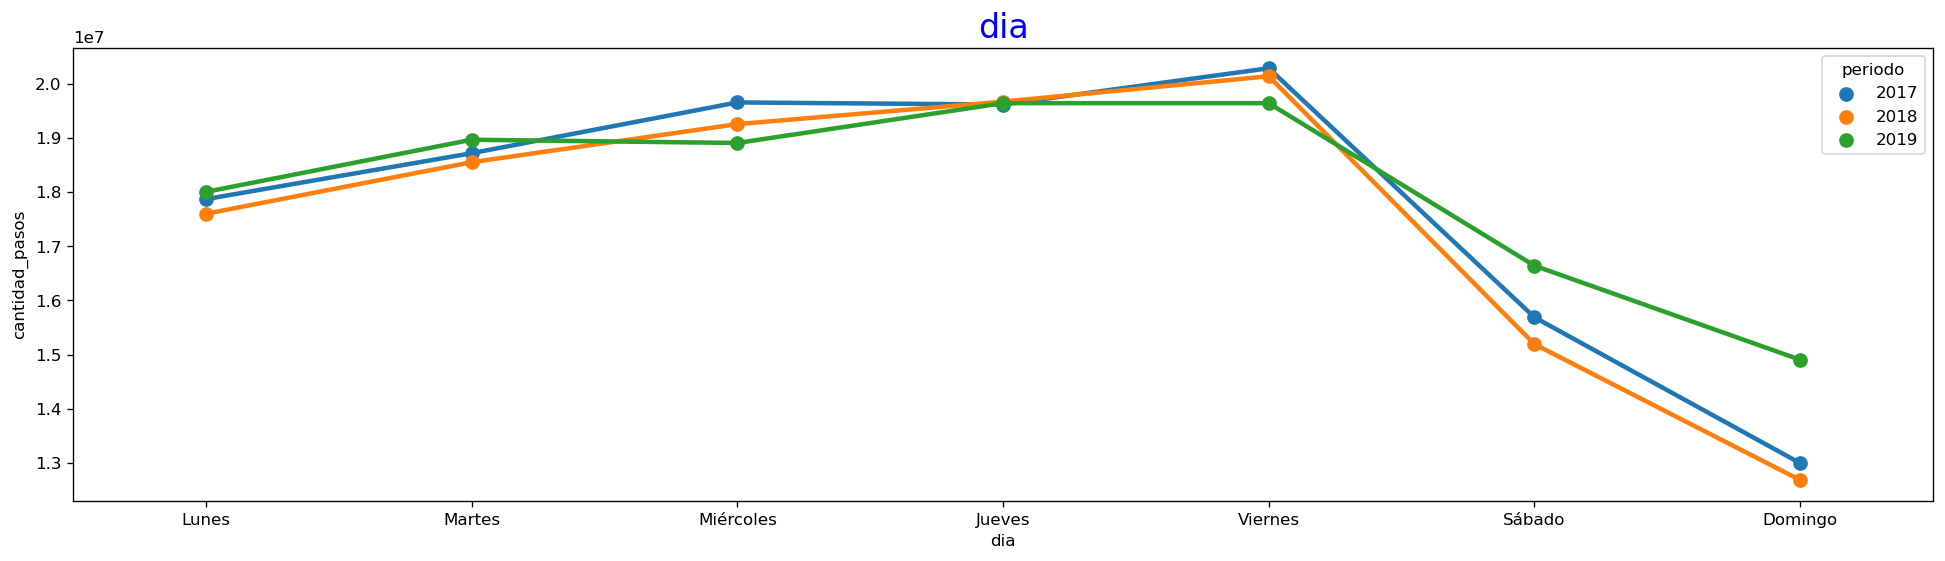

In [1541]:
    plt.figure(figsize = (20,5))

    sns.pointplot(x= 'dia', y = 'cantidad_pasos', hue= 'periodo', data=dataset.groupby(['periodo','dia'])['cantidad_pasos'].sum().reset_index()
              # ,palette="Spectral"
              , order = [ 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
              )
    plt.title( 'dia', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
    plt.show()

In [1542]:
mean_pasos_dia_p=  dataset.groupby(['dia','sentido','fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['dia','sentido'], as_index =False).agg({'cantidad_pasos':'mean'})

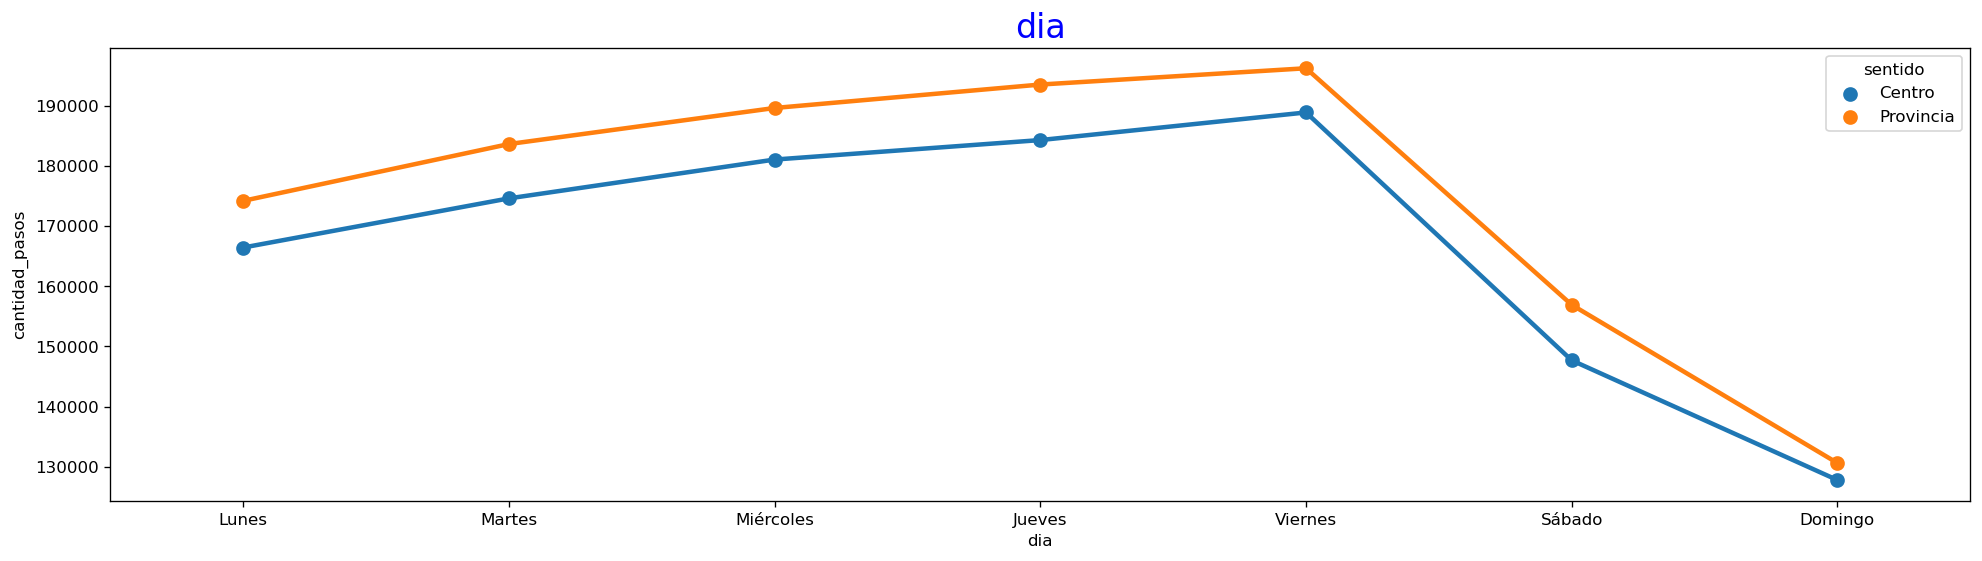

In [1543]:
    plt.figure(figsize = (20,5))

    sns.pointplot(x= 'dia', y = 'cantidad_pasos', hue= 'sentido', data= mean_pasos_dia_p
              # ,palette="Spectral"
              , order = [ 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
              )
    plt.title( 'dia', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
    plt.show()

In [1544]:
dataset_eda = dataset.copy()
dataset_eda.head()

periodo      fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017 2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017 2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017 2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017 2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017 2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  hour  
0       Liviano  NO COBRADO              25     0  
1       Liviano    TELEPASE               7     0  
2       Liviano  NO COBRADO               5     0  
3       Liviano    EFECTIVO               2     0  
4       Liviano    EFECTIVO              94     0

In [1545]:
dataset['estacion'].unique()

array(['Alberdi', 'Avellaneda', 'Dellepiane Centro', 'Dellepiane Liniers',
       'Illia', 'Retiro', 'Salguero', 'Sarmiento', 'Alberti',
       'Dellepiane', 'PDB'], dtype=object)

In [1546]:
dataset.loc[ (dataset.estacion == 'Dellepiane Centro') | (dataset.estacion == 'Dellepiane Liniers') | (dataset.estacion == 'Dellepiane'),:].groupby(['periodo','sentido','estacion'])['cantidad_pasos'].sum().reset_index()

periodo    sentido            estacion  cantidad_pasos
0     2017     Centro   Dellepiane Centro        15880444
1     2017  Provincia  Dellepiane Liniers        14813490
2     2018     Centro   Dellepiane Centro        15407755
3     2018  Provincia  Dellepiane Liniers        14355089
4     2019     Centro          Dellepiane        15007103
5     2019  Provincia          Dellepiane        14288345

In [1547]:
dataset.loc[ (dataset.estacion == 'Alberti') | (dataset.estacion == 'Alberdi'),:].groupby(['periodo','estacion'])['cantidad_pasos'].sum().reset_index()

periodo estacion  cantidad_pasos
0     2017  Alberdi         5789514
1     2018  Alberdi         5734842
2     2019  Alberti         5631401

In [1548]:
dataset['forma_pago'].unique()

array(['NO COBRADO', 'TELEPASE', 'EFECTIVO', 'TARJETA DISCAPACIDAD',
       'EXENTO', 'INFRACCION', 'MONEDERO', 'Otros', 'T. DISCAPACIDAD'],
      dtype=object)

In [1549]:
dataset_eda.loc[ dataset_eda.estacion == 'Dellepiane Centro', 'estacion'] = 'Dellepiane'
dataset_eda.loc[ dataset_eda.estacion == 'Dellepiane Liniers', 'estacion'] = 'Dellepiane'
dataset_eda.loc[ dataset_eda.estacion == 'Alberdi', 'estacion'] = 'Alberti'

dataset_eda.loc[ dataset_eda.forma_pago == 'T. DISCAPACIDAD', 'forma_pago'] = 'TARJETA DISCAPACIDAD'

print(dataset_eda['estacion'].unique())
print(dataset_eda['forma_pago'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**

In [1550]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')


# mask = dataset.estacion=='Illia'
dataset_1 = dataset[mask]
dataset_1.head()

periodo      fecha  hora_inicio  hora_fin      dia estacion sentido  \
1750     2017 2017-01-01            0         1  Domingo    Illia  Centro   
1755     2017 2017-01-01            1         2  Domingo    Illia  Centro   
1757     2017 2017-01-01            1         2  Domingo    Illia  Centro   
1761     2017 2017-01-01            1         2  Domingo    Illia  Centro   
1764     2017 2017-01-01            2         3  Domingo    Illia  Centro   

     tipo_vehiculo forma_pago  cantidad_pasos  hour  
1750       Liviano   EFECTIVO               1     0  
1755       Liviano   EFECTIVO              10     0  
1757       Liviano   EFECTIVO             783     0  
1761        Pesado   EFECTIVO               3     0  
1764       Liviano   EFECTIVO              14     0

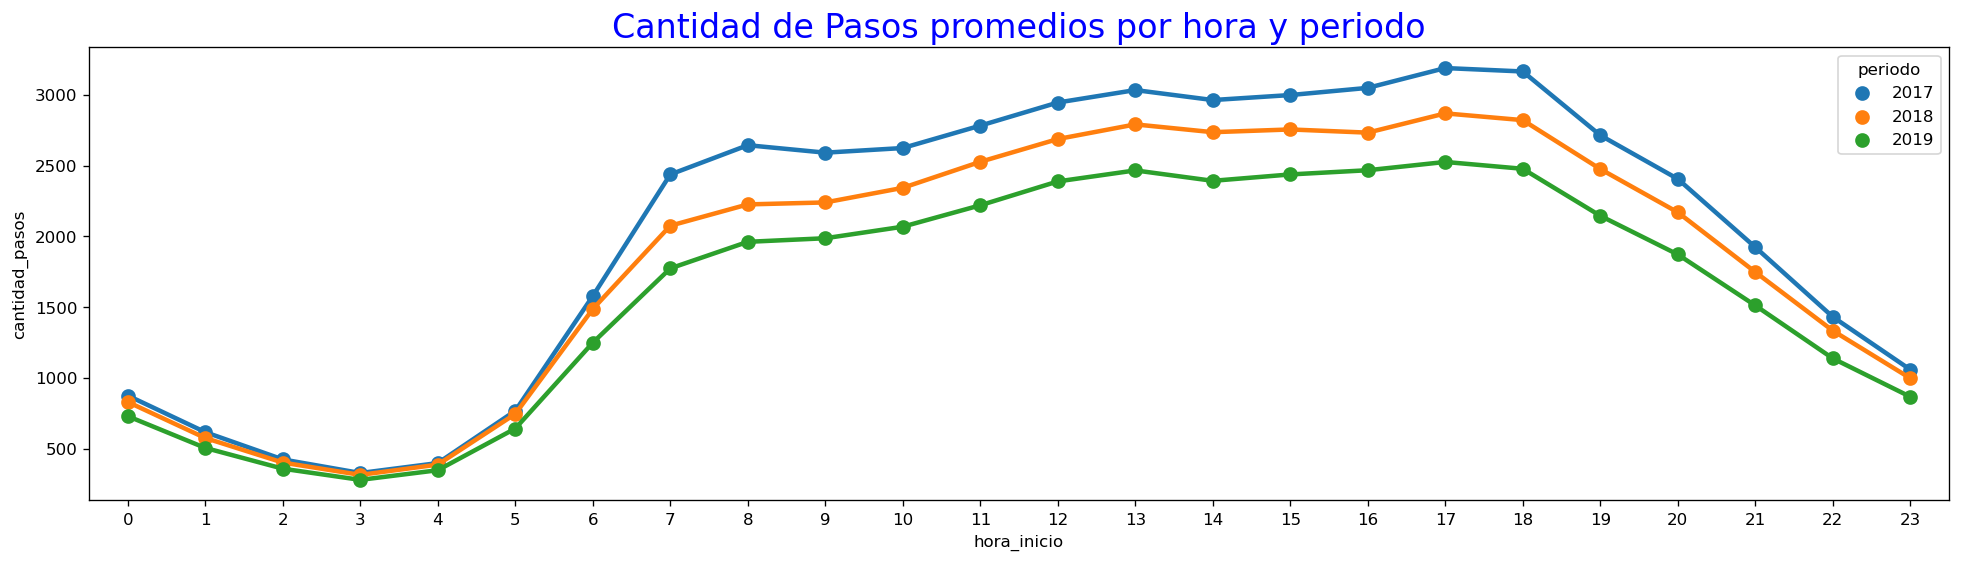

In [1551]:
    mean_pasos_hora_p=  dataset_1.groupby(['hora_inicio','periodo','fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['hora_inicio','periodo'], as_index =False).agg({'cantidad_pasos':'mean'})
    
    plt.figure(figsize = (20,5))

    sns.pointplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'periodo', data=mean_pasos_hora_p
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
    plt.title( 'Cantidad de Pasos promedios por hora y periodo', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
    plt.show()

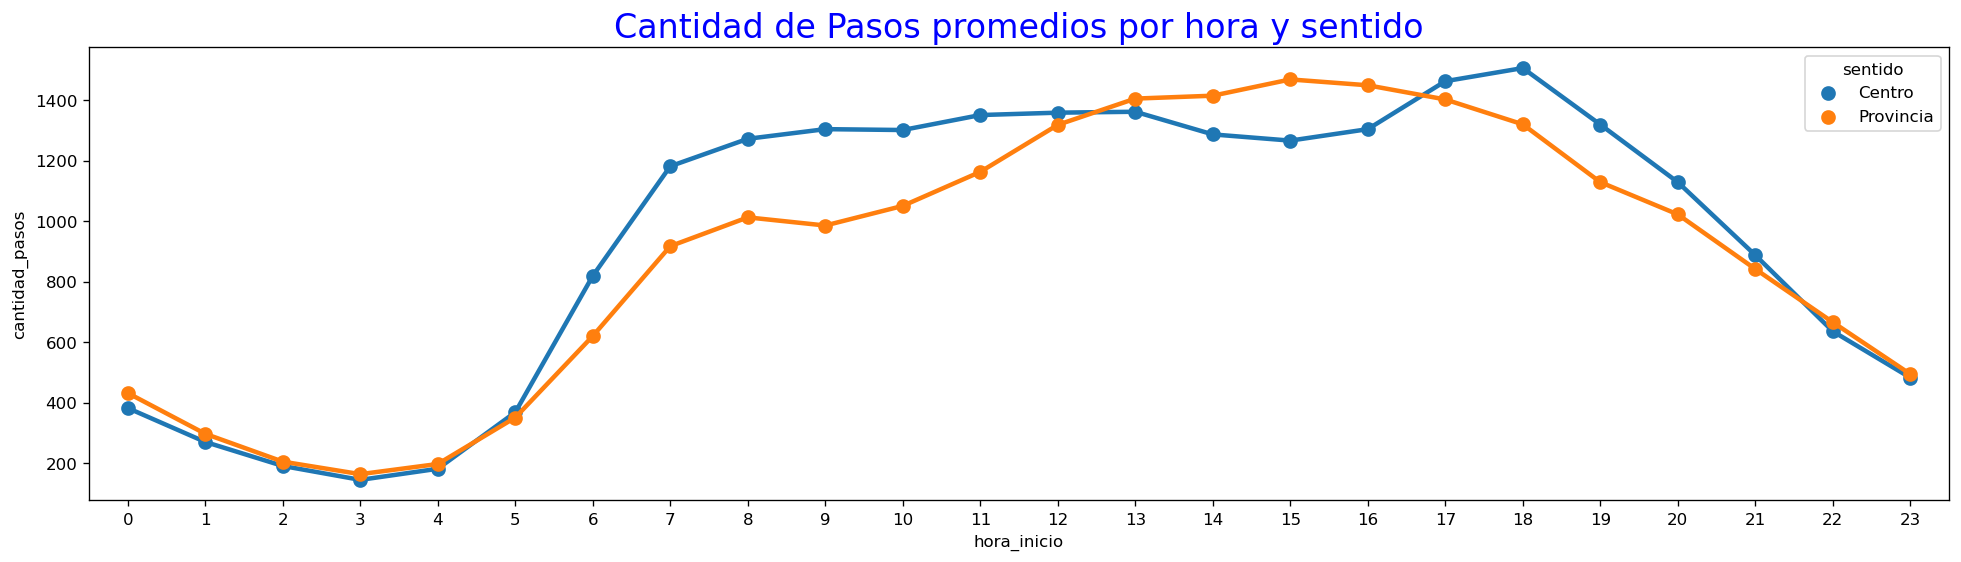

In [1552]:
   mean_pasos_hora_s=  dataset_1.groupby(['hora_inicio','sentido','fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['hora_inicio','sentido'], as_index =False).agg({'cantidad_pasos':'mean'})
   
   plt.figure(figsize = (20,5))

   sns.pointplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'sentido', data=mean_pasos_hora_s
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
   plt.title( 'Cantidad de Pasos promedios por hora y sentido', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
   plt.show()



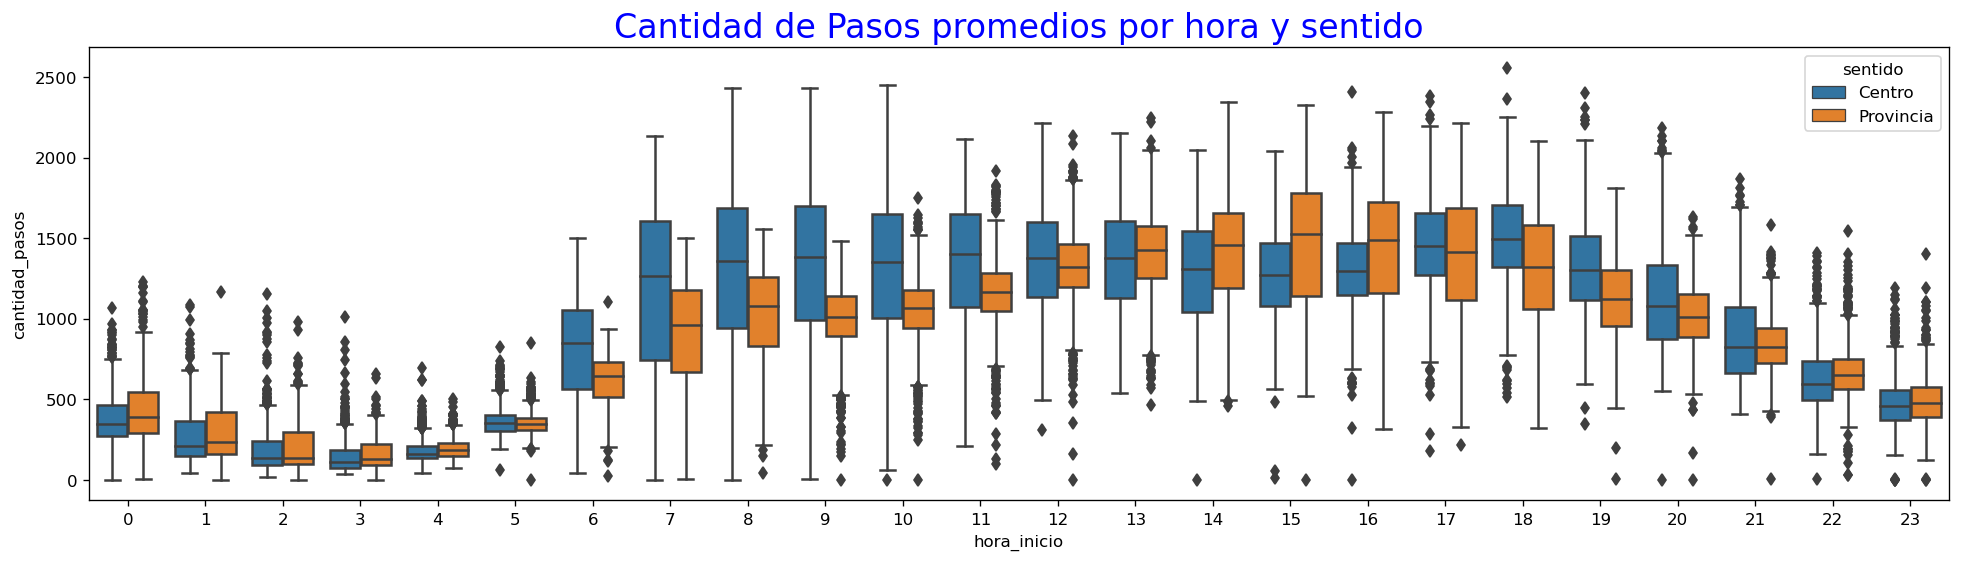

In [1553]:
   mean_pasos_hora_s2=  dataset_1.groupby(['hora_inicio','sentido','fecha'], as_index =False)['cantidad_pasos'].sum()
   
   plt.figure(figsize = (20,5))

   sns.boxplot(x= 'hora_inicio', y = 'cantidad_pasos', hue= 'sentido', data=mean_pasos_hora_s2
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
   plt.title( 'Cantidad de Pasos promedios por hora y sentido', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
   plt.show()

In [1554]:
dataset_1['mes'] = pd.DatetimeIndex(dataset_1['fecha']).month

dataset_1

periodo      fecha  hora_inicio  hora_fin      dia estacion  \
1750       2017 2017-01-01            0         1  Domingo    Illia   
1755       2017 2017-01-01            1         2  Domingo    Illia   
1757       2017 2017-01-01            1         2  Domingo    Illia   
1761       2017 2017-01-01            1         2  Domingo    Illia   
1764       2017 2017-01-01            2         3  Domingo    Illia   
...         ...        ...          ...       ...      ...      ...   
812010     2019 2019-12-31           21        22   Martes    Illia   
812016     2019 2019-12-31           21        22   Martes    Illia   
812080     2019 2019-12-31           22        23   Martes    Illia   
812085     2019 2019-12-31           22        23   Martes    Illia   
812131     2019 2019-12-31           23         0   Martes    Illia   

          sentido tipo_vehiculo forma_pago  cantidad_pasos  hour  mes  
1750       Centro       Liviano   EFECTIVO               1     0    1  
1755       Centro       Liviano   EFECTIVO              10     0    1  
1757       Centro       Liviano   EFECTIVO             783     0    1  
1761       Centro        Pesado   EFECTIVO               3     0    1  
1764       Centro       Liviano   EFECTIVO              14     0    1  
...           ...           ...        ...             ...   ...  ...  
812010  Provincia       Liviano   EFECTIVO             556     0   12  
812016  Provincia        Pesado   EFECTIVO               1     0   12  
812080     Centro       Liviano   EFECTIVO             214     0   12  
812085  Provincia       Liviano   EFECTIVO             190     0   12  
812131     Centro       Liviano   EFECTIVO               4     0   12  

[238869 rows x 12 columns]

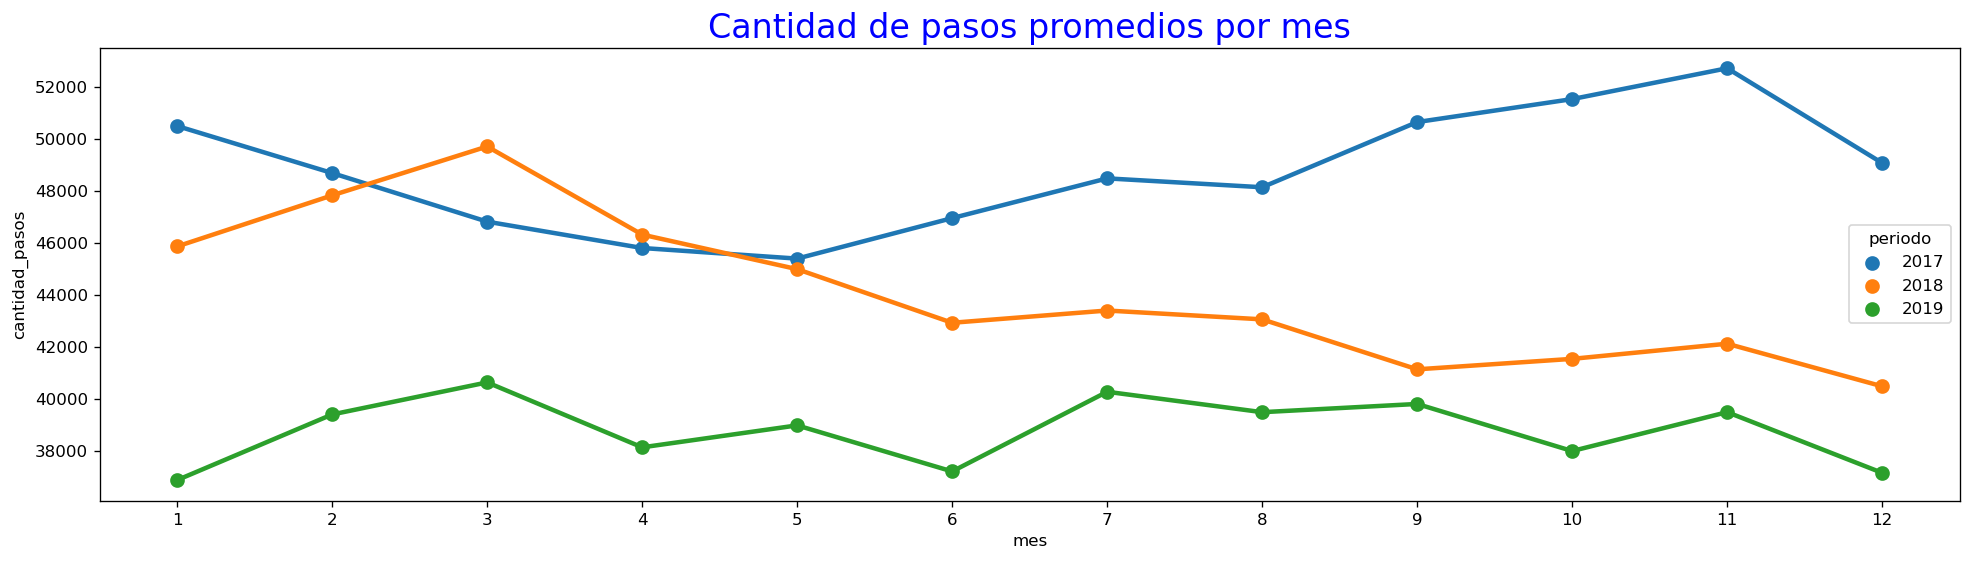

In [1555]:
mean_pasos_hora_s=  dataset_1.groupby(['mes','periodo','fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['mes','periodo'], as_index =False).agg({'cantidad_pasos':'mean'})

plt.figure(figsize = (20,5))

sns.pointplot(x= 'mes', y = 'cantidad_pasos', hue= 'periodo', data=mean_pasos_hora_s
              # ,palette="Spectral"
              # , order = dataset.groupby(['hora_inicio'])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['hora_inicio'].to_numpy()
              )
plt.title( 'Cantidad de pasos promedios por mes', size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
plt.show()

   

In [1556]:
dataset_1 =dataset_1.drop(columns = ['mes']).reset_index(drop=True)
dataset_1.head()

periodo      fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017 2017-01-01            0         1  Domingo    Illia  Centro   
1     2017 2017-01-01            1         2  Domingo    Illia  Centro   
2     2017 2017-01-01            1         2  Domingo    Illia  Centro   
3     2017 2017-01-01            1         2  Domingo    Illia  Centro   
4     2017 2017-01-01            2         3  Domingo    Illia  Centro   

  tipo_vehiculo forma_pago  cantidad_pasos  hour  
0       Liviano   EFECTIVO               1     0  
1       Liviano   EFECTIVO              10     0  
2       Liviano   EFECTIVO             783     0  
3        Pesado   EFECTIVO               3     0  
4       Liviano   EFECTIVO              14     0

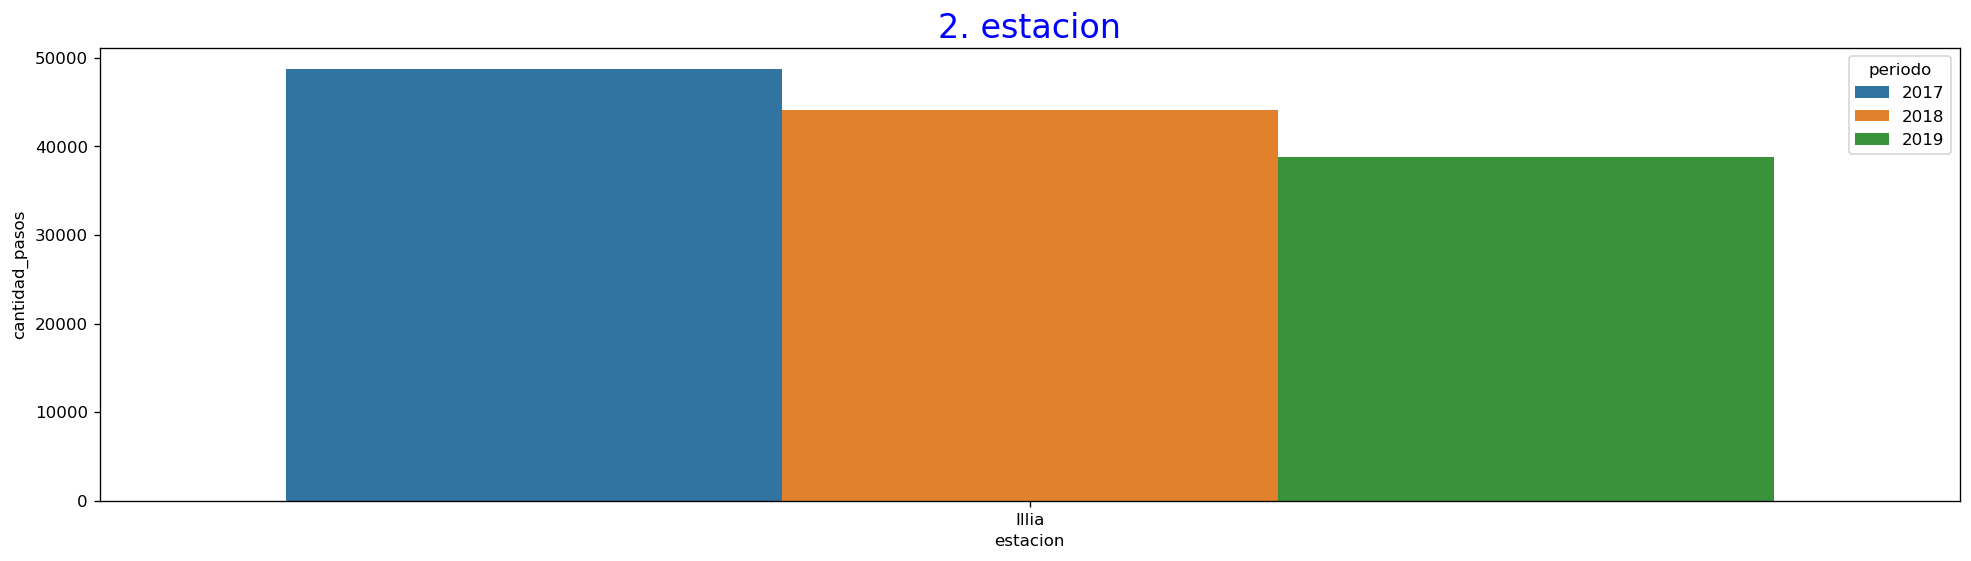

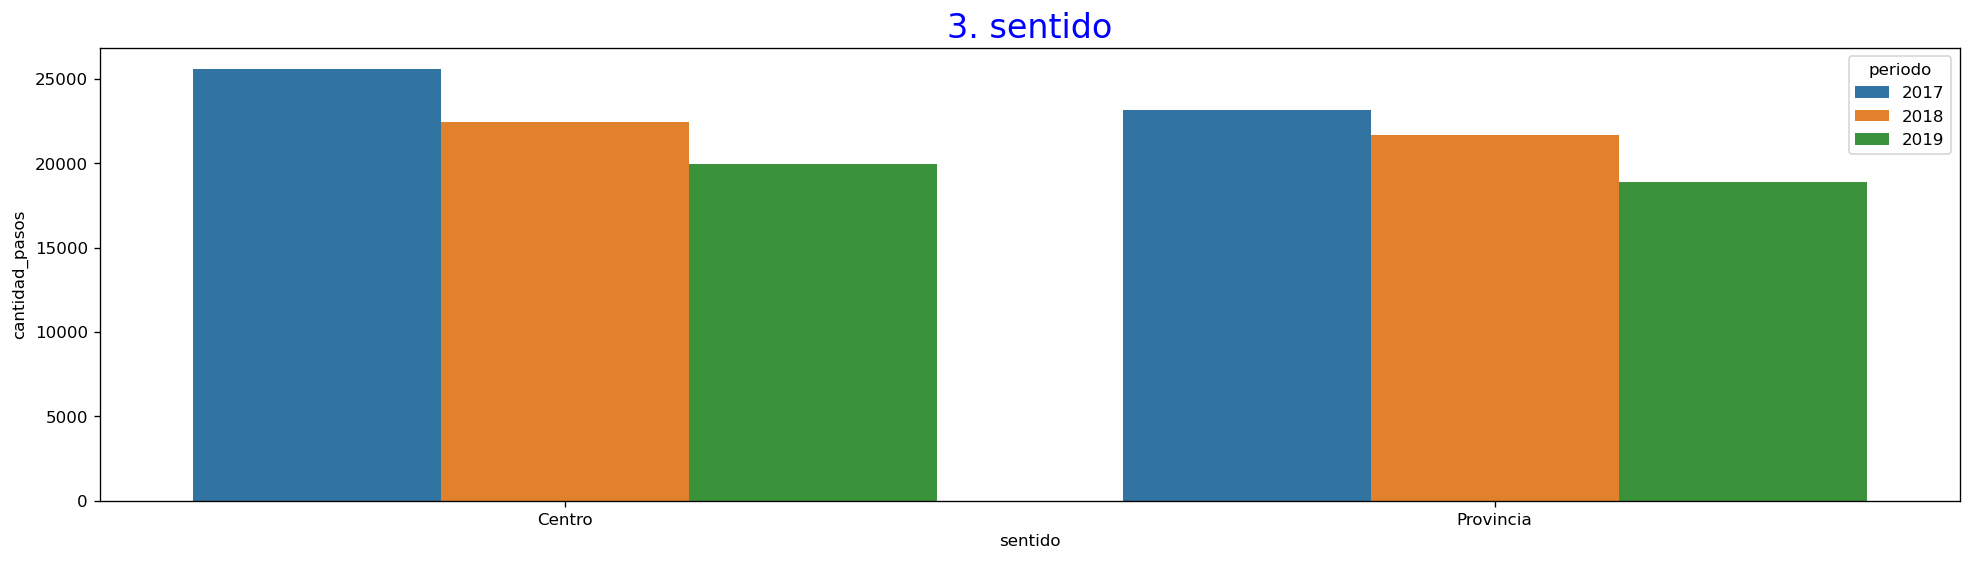

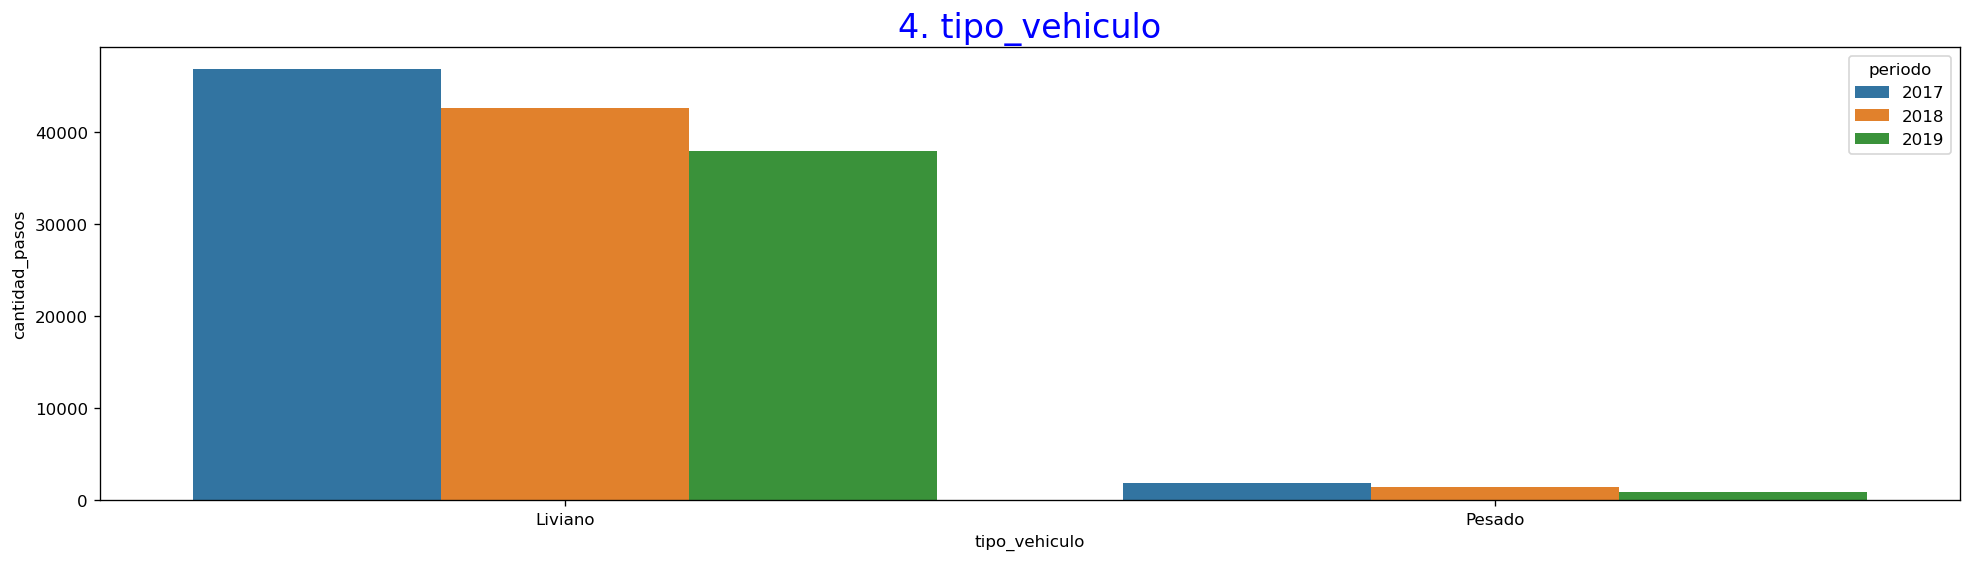

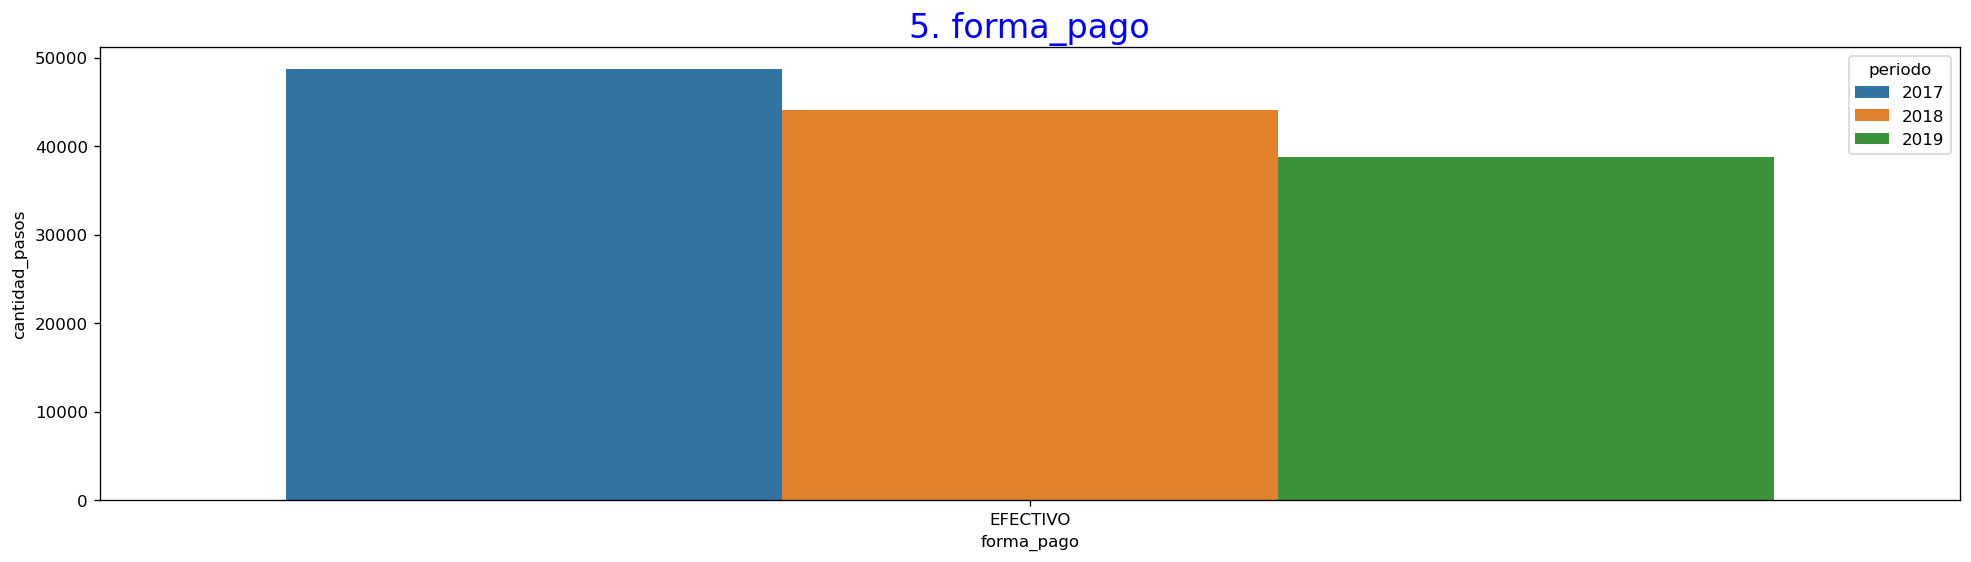

In [1557]:
for i, col in enumerate(dataset_1.columns[5:-2]):
    # print(i, col)
    plt.figure(figsize = (20,5))
    # plt.subplot(1,3,i+1)
    #plt.figure(i)
    sns.barplot(x= col, y = 'cantidad_pasos', hue= 'periodo', data=dataset_1.groupby(['periodo',col,'fecha'], as_index =False)['cantidad_pasos'].sum().groupby(['periodo',col], as_index =False).agg({'cantidad_pasos':'mean'})
              # ,palette="Spectral"
              , order = dataset_1.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)[col].to_numpy()
              )
    # plt.yscale("log")
    plt.title( str(i+2) +". "+ col, size =  20, color = 'b')
    # for i, v in enumerate(dataset.groupby([col])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)['cantidad_pasos'].to_numpy()):
    #   plt.text(i, v, str(int(v/1000000))+" e6", fontweight='bold' ,ha='center', va='bottom')
    plt.show()

### c) Responde: ¿Es necesario hacer alguna transformación de datos? ¿Hay nulls o columnas que no aportan información? Justifique.

- ¿Es necesario hacer alguna transformación de datos?

    Las transformaciones que se van a realizar al dataset solo:

     - Detección y eliminación de Outliers.
     - Imputación de valores faltantes.
    Ya que los modelos a utilizar para entrenar los modelos el valor de la fecha y la variable objetivo, que es la cantidad de pasos.

- ¿Hay nulls o columnas que no aportan información?

    - No hay valores nulls pero si fechas con cantidad de pasos igual a "0", las cuales hay que investigar con mayor detalle.
    - Al no utilizar modelos multi variables, el resto de columnas no podrán aportar información al modelo.





#### Selección y resanpleo de los datos

In [1558]:
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')

dataset_1 = dataset[mask]


#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_1['fecha2'] = pd.to_datetime(dataset_1.fecha) + pd.to_timedelta(dataset_1.hora_inicio, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_1.drop(columns=['fecha','hora_inicio'], inplace = True)

dataset_1.head()

#Corregimos el nombre de fecha2 a fecha
dataset_1.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_1.head()

#Reordenamos el dataset por fecha
dataset_1.sort_values('fecha', inplace = True)
dataset_1.reset_index(drop=True, inplace = True)
dataset_1

periodo  hora_fin      dia estacion    sentido tipo_vehiculo  \
0          2017         1  Domingo    Illia     Centro       Liviano   
1          2017         2  Domingo    Illia  Provincia        Pesado   
2          2017         2  Domingo    Illia  Provincia       Liviano   
3          2017         2  Domingo    Illia  Provincia       Liviano   
4          2017         2  Domingo    Illia     Centro       Liviano   
...         ...       ...      ...      ...        ...           ...   
238864     2019        22   Martes    Illia     Centro       Liviano   
238865     2019        22   Martes    Illia  Provincia        Pesado   
238866     2019        23   Martes    Illia  Provincia       Liviano   
238867     2019        23   Martes    Illia     Centro       Liviano   
238868     2019         0   Martes    Illia     Centro       Liviano   

       forma_pago  cantidad_pasos  hour               fecha  
0        EFECTIVO               1     0 2017-01-01 00:00:00  
1        EFECTIVO               5     0 2017-01-01 01:00:00  
2        EFECTIVO             561     0 2017-01-01 01:00:00  
3        EFECTIVO              12     0 2017-01-01 01:00:00  
4        EFECTIVO             783     0 2017-01-01 01:00:00  
...           ...             ...   ...                 ...  
238864   EFECTIVO             580     0 2019-12-31 21:00:00  
238865   EFECTIVO               1     0 2019-12-31 21:00:00  
238866   EFECTIVO             190     0 2019-12-31 22:00:00  
238867   EFECTIVO             214     0 2019-12-31 22:00:00  
238868   EFECTIVO               4     0 2019-12-31 23:00:00  

[238869 rows x 10 columns]

#### Outliers

#####  funcion plot_time

In [1559]:
def plot_time(dataset,rango_años,temporalidad = "", ventana = "",Boxplot = True) :



    # date = dataset[["fecha","cantidad_pasos"]].resample(temporalidad, on = 'fecha').sum()
    # date["fecha_num"] = date.index.map(dt.datetime.toordinal)
    if temporalidad == "":
        temporalidad = ["D","W","M","Q"]
        G = gridspec.GridSpec(4 , 8)
        plt.figure(figsize = (19,28)) 
    else:
        G = gridspec.GridSpec(1 , 8)
        plt.figure(figsize = (19,7))  


    for v, i  in enumerate(temporalidad):     
        

        if dataset.index.name != 'fecha':
            date = dataset[["fecha","cantidad_pasos"]].resample(i, on = 'fecha').sum()
            # date["fecha_num"] = date.index.map(dt.datetime.toordinal)
        else:
            dataset.reset_index(inplace=True)
            date = dataset[["fecha","cantidad_pasos"]].resample(i, on = 'fecha').sum()
            # date["fecha_num"] = date.index.map(dt.datetime.toordinal)
            dataset.set_index("fecha", inplace=True)

            
        titulo = ""

        if i == "W":
            date.drop(date.tail(1).index,inplace=True)
            date.drop(date.head(1).index,inplace=True)
            window1 = 50
            label_mm = "Media Movil - " + str(window1+2) + " semanas"
            titulo = "Cantidad de pasos por semana "+ rango_años
            # semanal = date

        elif i == "D":
            if ventana == "":
                window1 = 365
            else:
                window1 = ventana  
            label_mm = "Media Movil - " + str(window1) + " dias"
            titulo = "Cantidad de pasos por dia "+ rango_años
            # diario = date
        
        elif i == "Q":
            window1 = 4
            label_mm = "Media Movil - " + str(window1) + " trimestres"
            titulo = "Cantidad de pasos por trimestre "+ rango_años        
            # trimestral = date

        # elif :
        elif i == "M":
            if ventana == "":
                window1 = 12
            
            label_mm = "Media Movil - " + str(window1) + " meses" 
            titulo = "Cantidad de pasos por mes " + rango_años
            # mensual = date
        
        date["fecha_num"] = date.index.map(dt.datetime.toordinal)

        lr = LinearRegression()
        lr.fit(date.fecha_num.values.reshape(-1, 1), date.cantidad_pasos)

        diario_promedio_tendencia = date.cantidad_pasos.rolling(window=window1, center = True, min_periods=(window1//2)).mean()
        diario_promedio_tendencia

        q25,q75 = np.percentile(date.cantidad_pasos, [25 ,75])
        iqr = q75 - q25

    
        
        # plt.figure(figsize = (19,21))
        

        #Graficamos la cantidad de propiedades por zona
        
        if Boxplot == True:
            axes_1 = plt.subplot(G[v, 0:7])
        else:
            axes_1 = plt.subplot(G[v, :])


        plt.plot(date.index,
                    date.cantidad_pasos, 
                    label = "Cantidad de pasos")

        plt.plot(diario_promedio_tendencia,
                    label = label_mm)

        plt.plot(date.index, 
                    lr.predict(date.fecha_num.values.reshape(-1, 1)),
                    c = "k",
                    label = "Cantidad de pasos - Ajuste Lineal")

        plt.plot(date.index, 
                    lr.predict(date.fecha_num.values.reshape(-1, 1)) + 1.5 * iqr,
                    ls = "--",
                    c = "r",
                    label = "Ajuste Lineal - Limite superior")

        plt.plot(date.index, 
                    lr.predict(date.fecha_num.values.reshape(-1, 1)) - 1.5 * iqr,
                    ls = "--",
                    c = "r",
                    label = "Ajuste Lineal - Limite inferior")
    # "Cantidad de vehiculos por semana [2017-2019*]"
        # plt.title("Boxplot", fontsize=20)
        plt.title(titulo, 
                    fontsize = 20 
                    #   ,pad = 10
                    )

        # plt.xlabel("(*): la última semana de 2019 comprende 5 días de 2020"
        #                 , labelpad = 10
        #                 )

        plt.ylabel("")

        plt.yticks(fontsize = 15)

        plt.xticks(fontsize = 15,
                    rotation = 0)

        # plt.xlim(dt.date(2017,1,1),
        #             dt.date(2020,1,5))

        plt.xlim(date.index.min(),
                    date.index.max())            

        plt.ylim(date.cantidad_pasos.min()*0.5,
                    date.cantidad_pasos.max()*1.5)
        # plt.axis('off')
        plt.grid(axis = "both")

        plt.legend(fontsize = 12)


        #Graficamos la cantidad de barrios por zona
        if Boxplot == True:

            axes_2 = plt.subplot(G[v, 7])

            sns.boxplot(y = date.cantidad_pasos)
            plt.title("Boxplot", fontsize=20)
            plt.ylim(date.cantidad_pasos.min()*0.5,
                        date.cantidad_pasos.max()*1.5)
            
            ax=plt.gca()
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            plt.yticks(fontsize = 15)
            # ax.get_yaxis().set_visible(False)
            plt.grid(axis = "both") 
                    
            # plt.axis('off')
            # plt.legend(loc = 1)

            # plt.tight_layout()

    plt.show()

 

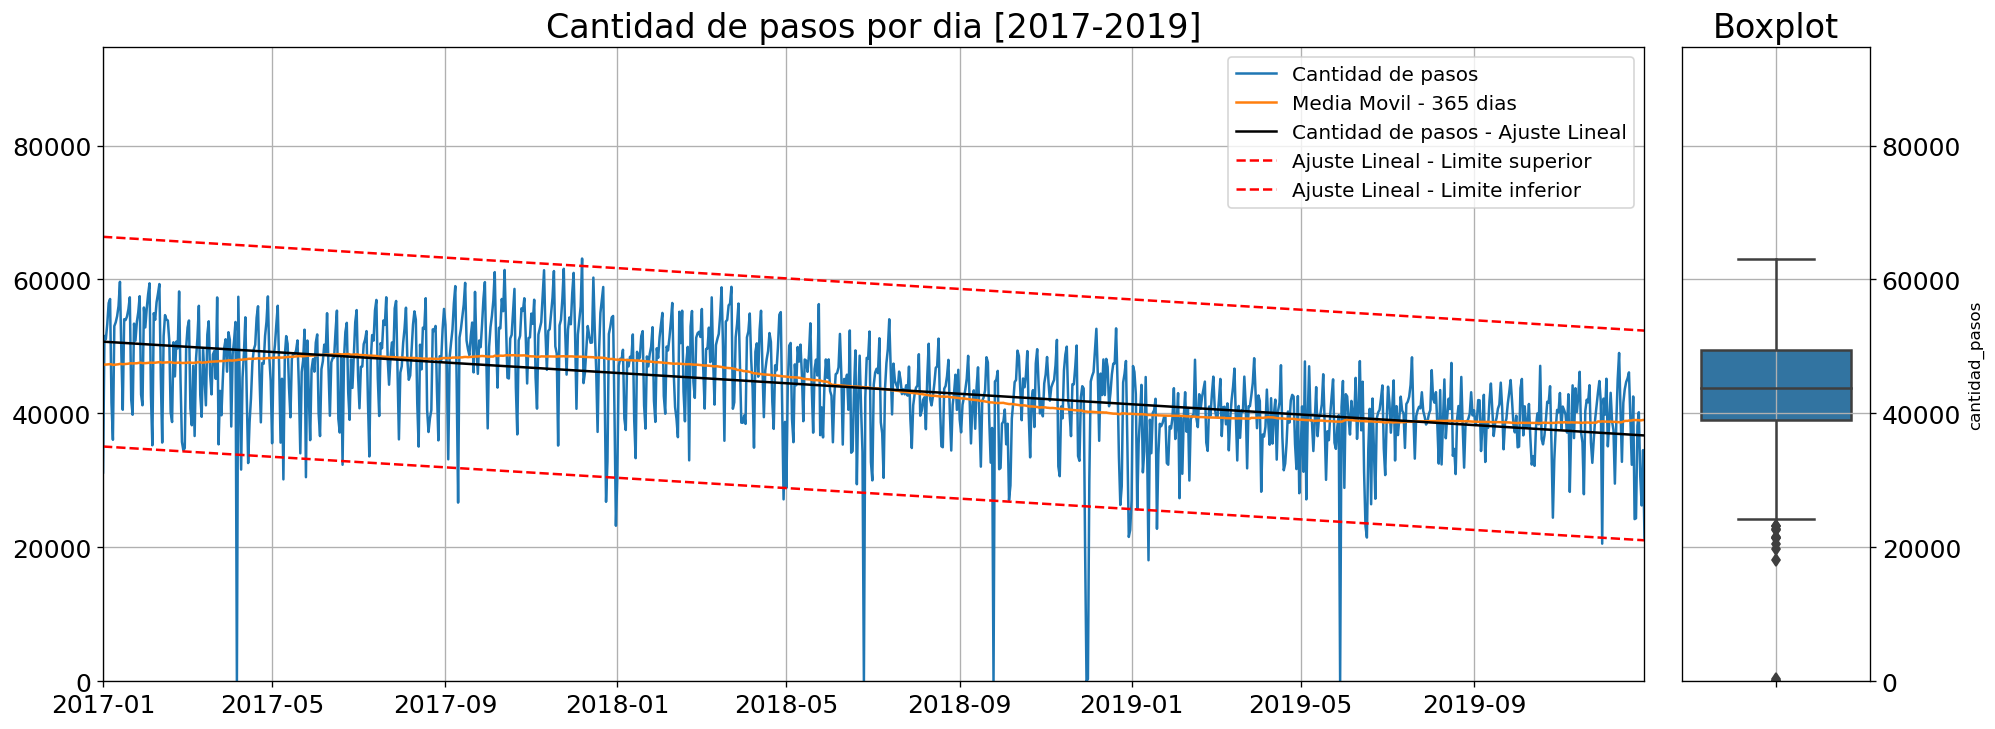

In [1560]:

plot_time(dataset_1,"[2017-2019]","D",ventana = 365)



In [1561]:
diario = dataset_1[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum()
diario["fecha_num"] = diario.index.map(dt.datetime.toordinal)
diario.head(2).append(diario.tail(2))

cantidad_pasos  fecha_num
fecha                                
2017-01-01           31183     736330
2017-01-02           51568     736331
2019-12-30           34523     737423
2019-12-31           21447     737424

In [1562]:
atipicos = diario[diario.cantidad_pasos < 15000]
atipicos

cantidad_pasos  fecha_num
fecha                                
2017-04-06              40     736425
2018-06-25               0     736870
2018-09-25               0     736962
2018-11-30               0     737028
2018-12-01             350     737029
2019-05-29               0     737208

Información auxiliar para entender los valores atípicos:

Vamos a evaluar fecha por fecha que fue lo que sucedió y así discernir si fue un suceso preciso o fue un error a la hora de tomar los datos.

* 2017-04-06: Huelga general
* 2018-06-25: Huelga general. 
* 2018-09-25: Huelga general. 
* 2018-11-30: G20 
* 2018-12-01: G20 
* 2019-05-29:  Huelga general. 

En todas las fechas hubo sucesos que justifican el valor atípico.


In [1563]:
# Reemplazamos esas fechas por NaN

diario[diario.cantidad_pasos < 15000] = np.nan

#### Valores Faltantes

In [1564]:
print(diario.isna().sum())
diario = diario.interpolate(method="nearest")
print(diario.isna().sum())

cantidad_pasos    6
fecha_num         6
dtype: int64
cantidad_pasos    0
fecha_num         0
dtype: int64


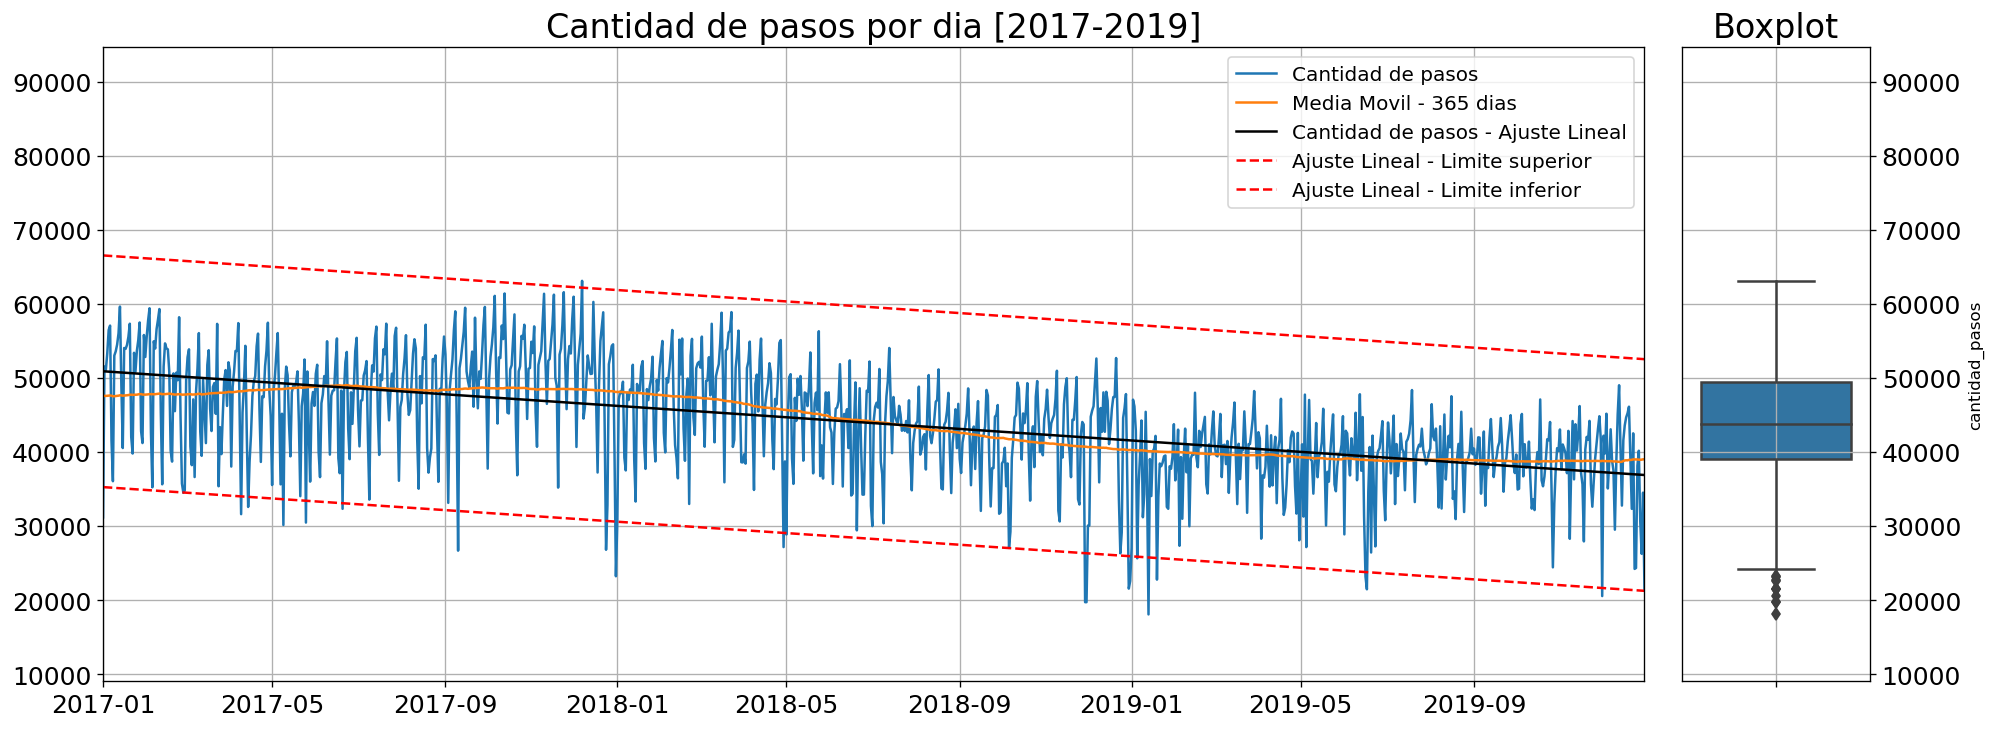

In [1565]:
plot_time(diario,"[2017-2019]","D")

In [1566]:
diario

cantidad_pasos  fecha_num
fecha                                
2017-01-01         31183.0   736330.0
2017-01-02         51568.0   736331.0
2017-01-03         51093.0   736332.0
2017-01-04         53332.0   736333.0
2017-01-05         56486.0   736334.0
...                    ...        ...
2019-12-27         40182.0   737420.0
2019-12-28         30681.0   737421.0
2019-12-29         26259.0   737422.0
2019-12-30         34523.0   737423.0
2019-12-31         21447.0   737424.0

[1095 rows x 2 columns]

In [1567]:
diario.reset_index("fecha",inplace=True)

print(calendario_completo.shape[0] - len(diario.fecha.unique()) == 0)

diario.set_index("fecha", inplace=True)

True


In [1568]:
diario.head(2).append(diario.tail(2))

cantidad_pasos  fecha_num
fecha                                
2017-01-01         31183.0   736330.0
2017-01-02         51568.0   736331.0
2019-12-30         34523.0   737423.0
2019-12-31         21447.0   737424.0

### e) Realiza dos 2 grafico que aporten información para el entendimiento e interpretación de los datos.

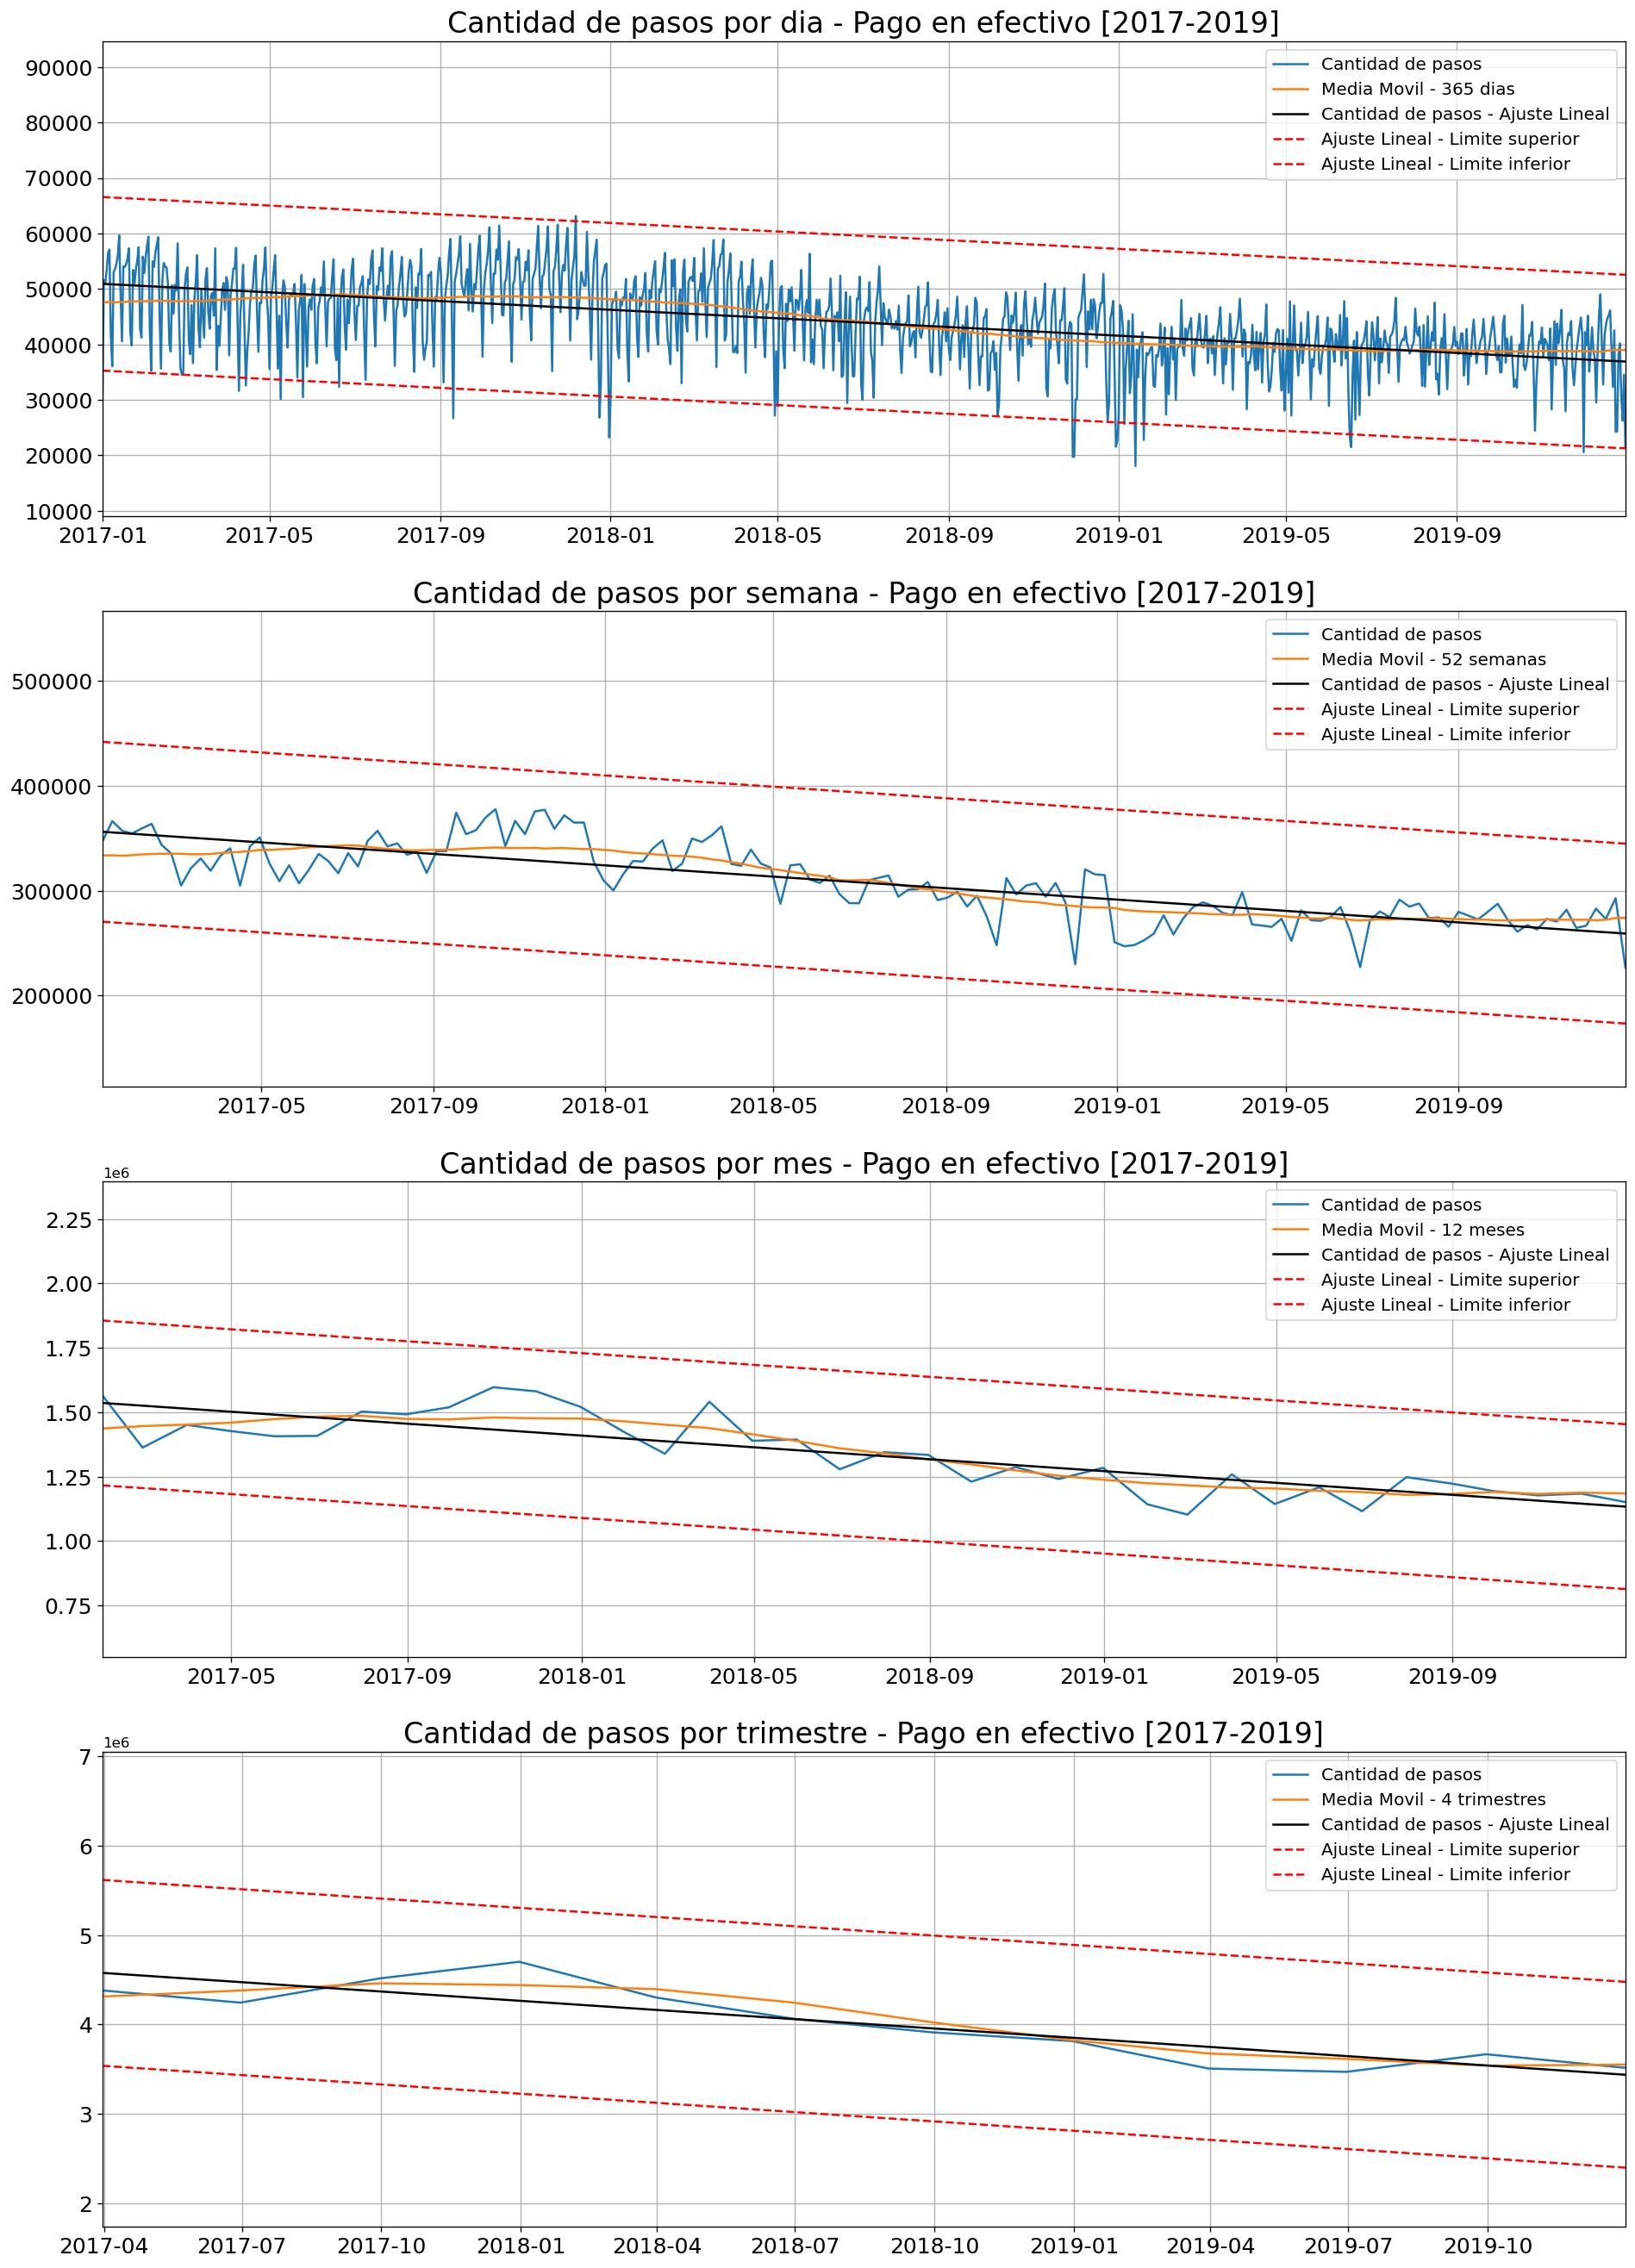

In [1569]:
plot_time(diario,"- Pago en efectivo [2017-2019]",Boxplot =False)

# Modelos de Machine Learning

##### Funciones

In [1174]:
def adfuller_test(flujo):
    result = adfuller(flujo)
    labels = ['ADF Test Statistic','p-value','#Rezagos usados','Número de observaciones']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))

    if result[1] <= 0.05:
      print("Se rechaza la hipótesis nula. La serie de tiempo es estacionaria")
    else:
      print("Poca evidencia en contra de la hipótesis nula. La serie de tiempo NO es estacionaria")

def evaluar_modelo(y_pred, y_true, model):

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    dataf = pd.DataFrame({
        "Modelo": model,
        "RMSE":[RMSE]
    })
    return dataf

def plot_modelo(train,test,pred) :
    fig, (ax1,ax2) = plt.subplots(2,figsize=(18,8))

    ax1.plot(train, label='Train')
    ax1.plot(test , label='Test')
    ax1.plot(pred, label='Forecast')
    ax1.legend(loc="upper right")
    ax1.grid(axis = "both")
    ax2.plot(test, label='Test')
    ax2.plot(pred, label='Forecast')
    ax2.legend(loc="upper right")

    fig.suptitle("Train - Test - Forecast", fontsize=20)
    ax2.grid(axis = "both")

### Benchmark : ARIMA

In [1175]:
adfuller_test(diario.cantidad_pasos)

ADF Test Statistic : -1.7724769863530796
p-value : 0.39420915614218843
#Rezagos usados : 20
Número de observaciones : 1074
Poca evidencia en contra de la hipótesis nula. La serie de tiempo NO es estacionaria


In [1176]:
diario_est = diario.diff(periods=1)
diario_est = diario_est[1:]
diario_est.head()

cantidad_pasos  fecha_num
fecha                                
2017-01-02         20385.0        1.0
2017-01-03          -475.0        1.0
2017-01-04          2239.0        1.0
2017-01-05          3154.0        1.0
2017-01-06           595.0        1.0

In [1177]:
adfuller_test(diario_est.cantidad_pasos)

ADF Test Statistic : -12.404016901381157
p-value : 4.494479223495879e-23
#Rezagos usados : 19
Número de observaciones : 1074
Se rechaza la hipótesis nula. La serie de tiempo es estacionaria


#### Parametro "p" - (AR)

<Figure size 1800x600 with 0 Axes>

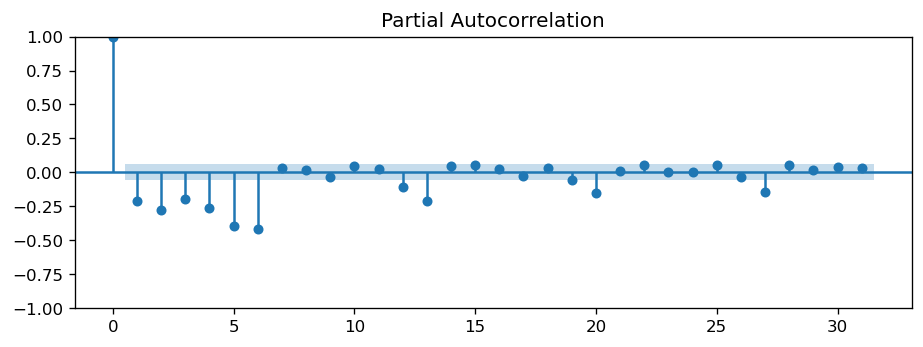

In [1178]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.figure(figsize = (15,5))
plot_pacf(diario_est.cantidad_pasos)
plt.show()

Por el grafico definimos que p = 6

#### Parametro "q" - (MA)

<Figure size 1800x600 with 0 Axes>

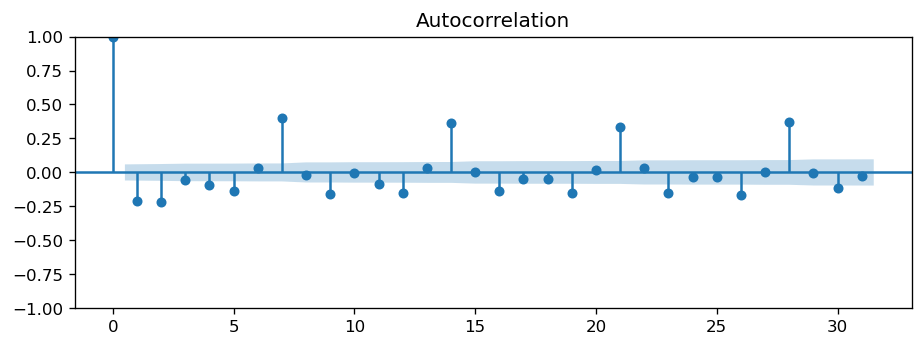

In [1179]:
plt.figure(figsize = (15,5))
plot_acf(diario_est.cantidad_pasos)
plt.show()

Por el grafico definimos que q = 2

In [1180]:
model_arima = sm.tsa.arima.ARIMA(diario.cantidad_pasos, order=(6,1,2))
# statsmodels.tsa.arima_model
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -10947.668
Date:                Sun, 15 May 2022   AIC                          21913.337
Time:                        23:25:44   BIC                          21958.315
Sample:                    01-01-2017   HQIC                         21930.357
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6494      0.076     -8.515      0.000      -0.799      -0.500
ar.L2         -0.7207      0.042    -17.138      0.000      -0.803      -0.638
ar.L3         -0.6497      0.038    -17.245      0.0

Se observa que los valores p son mayor a 0.05, por lo que no son relevantes para el modelo.

In [1181]:
# ARIMA(p,d,q)
# p=6 , d=1 , q=2
model_arima = ARIMA(diario.cantidad_pasos, order=(6,1,0))
model_arima_fit = model_arima.fit( )
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                 ARIMA(6, 1, 0)   Log Likelihood              -10948.026
Date:                Sun, 15 May 2022   AIC                          21910.052
Time:                        23:25:48   BIC                          21945.036
Sample:                    01-01-2017   HQIC                         21923.290
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6447      0.020    -31.587      0.000      -0.685      -0.605
ar.L2         -0.7127      0.025    -28.581      0.000      -0.762      -0.664
ar.L3         -0.6452      0.025    -25.646      0.0

Cuanto menor es el valor del AIC, mejor el es modelo. Como 21910.052 < 21913.337, es ligeramente mejor. Utilizaremos este modelo de benchmark

#### Separacion Test y Train

In [1182]:
diario

cantidad_pasos  fecha_num
fecha                                
2017-01-01         31183.0   736330.0
2017-01-02         51568.0   736331.0
2017-01-03         51093.0   736332.0
2017-01-04         53332.0   736333.0
2017-01-05         56486.0   736334.0
...                    ...        ...
2019-12-27         40182.0   737420.0
2019-12-28         30681.0   737421.0
2019-12-29         26259.0   737422.0
2019-12-30         34523.0   737423.0
2019-12-31         21447.0   737424.0

[1095 rows x 2 columns]

In [1183]:
# El periodo a predecir es el ultimo trimestre del 2019, es decir desde el 1/10/2019

diario.reset_index("fecha",inplace=True)


semanal = diario.copy()
# semanal.reset_index(inplace=True)
semanal.drop(columns=['fecha_num'], inplace=True)

# semanal.reset_index('fecha', inplace=True)
diario.set_index("fecha", inplace=True)


In [1184]:
semanal = semanal[["fecha","cantidad_pasos"]].resample('W', on = 'fecha').sum()
semanal["fecha_num"] = semanal.index.map(dt.datetime.toordinal)
semanal.head(3).append(semanal.tail(3))

cantidad_pasos  fecha_num
fecha                                
2017-01-01         31183.0     736330
2017-01-08        347212.0     736337
2017-01-15        366413.0     736344
2019-12-22        292881.0     737415
2019-12-29        226390.0     737422
2020-01-05         55970.0     737429

In [1185]:
semanal.drop(semanal.tail(1).index,inplace=True)
semanal.drop(semanal.head(1).index,inplace=True)
semanal.head(3).append(semanal.tail(3))

cantidad_pasos  fecha_num
fecha                                
2017-01-08        347212.0     736337
2017-01-15        366413.0     736344
2017-01-22        357215.0     736351
2019-12-15        272960.0     737408
2019-12-22        292881.0     737415
2019-12-29        226390.0     737422

In [1186]:
diario.reset_index("fecha",inplace=True)
semanal.reset_index("fecha",inplace=True)

train_diario = diario.loc[(diario['fecha'] < '2019-10-01')]
test_diario = diario.loc[(diario['fecha'] >= '2019-10-01')]

train_semanal = semanal.loc[(semanal['fecha'] < '2019-10-01')]
test_semanal = semanal.loc[(semanal['fecha'] >= '2019-10-01')]

diario.set_index("fecha", inplace=True)
train_diario.set_index("fecha", inplace=True)
test_diario.set_index("fecha", inplace=True)


semanal.set_index("fecha", inplace=True)
train_semanal.set_index("fecha", inplace=True)
test_semanal.set_index("fecha", inplace=True)

#### Benchmark (diario)

In [1187]:
model_benchmark = ARIMA(train_diario.cantidad_pasos, order=(6,1,2))
model_benchmark_fit = model_benchmark.fit()##disp=0)
fc = model_benchmark_fit.forecast(92)##, alpha=0.05)
# statsmodels.tsa.arima.model.ARIMAResults.forecast 


In [1188]:
res_bench =  evaluar_modelo(fc, test_diario.cantidad_pasos, "Benchmark(diario)")
res_bench.head()

Modelo         RMSE
0  Benchmark(diario)  5966.847827

In [1189]:
predicciones_diario = pd.Series(data=fc, index=test_diario.cantidad_pasos.index)
# predicciones_diario.head()

In [1190]:
train_diario

cantidad_pasos  fecha_num
fecha                                
2017-01-01         31183.0   736330.0
2017-01-02         51568.0   736331.0
2017-01-03         51093.0   736332.0
2017-01-04         53332.0   736333.0
2017-01-05         56486.0   736334.0
...                    ...        ...
2019-09-26         43110.0   737328.0
2019-09-27         44985.0   737329.0
2019-09-28         41925.0   737330.0
2019-09-29         38348.0   737331.0
2019-09-30         37170.0   737332.0

[1003 rows x 2 columns]

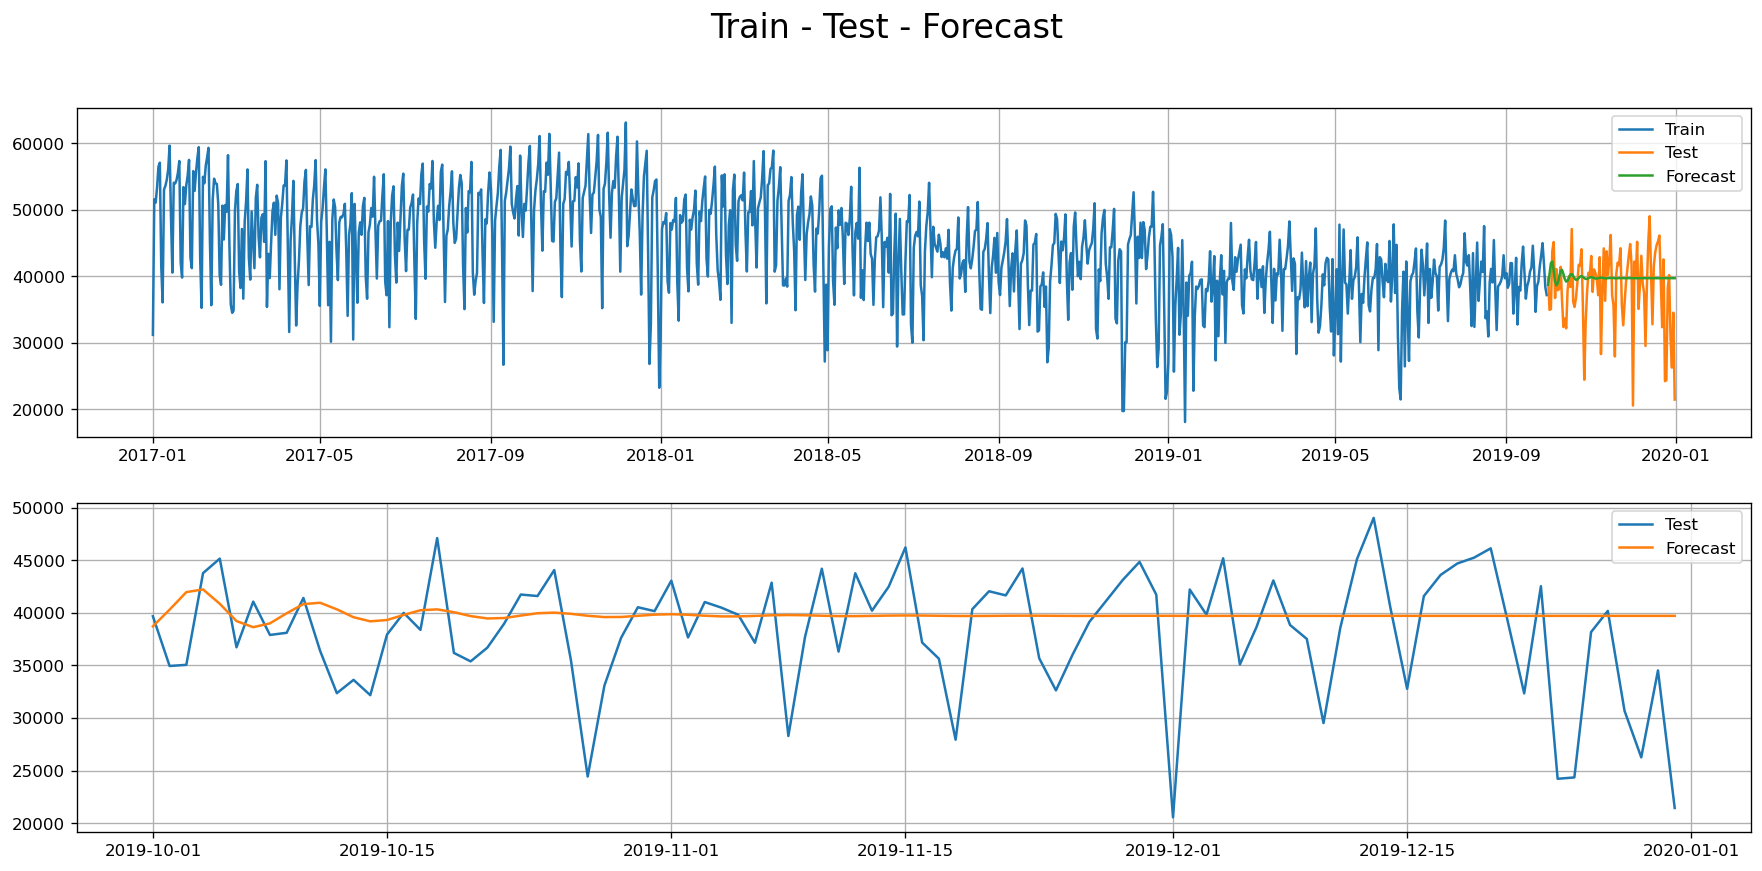

In [1191]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_diario)

## AutoArima

(Optimizacion de hiperparametros)

### AutoArima (diario)

In [1213]:
modelAA_diario = auto_arima(diario.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      n_jobs=-1)
print(modelAA_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22172.041, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22541.696, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22499.321, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22265.044, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22539.698, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22133.677, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22417.361, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22124.778, Time=0.68 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=22379.048, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=22076.724, Time=0.34 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=22306.856, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=21993.755, Time=0.34 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=22131.155, Time=0.20 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=21914.003, Time=0.63 sec
 ARIMA(6,1,0)(0,0,0

In [ ]:
# Best model:  ARIMA(0,0,2)(1,1,1)[7]
modelAA_diario.fit(train_diario.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AA_diario = modelAA_diario.predict(n_periods=92, return_conf_int=False)
predicciones_AA_diario = pd.Series(data=pred_AA_diario, index=test_diario.cantidad_pasos.index)
# predicciones_AA_diario.head()

In [ ]:
autoarima_diario_res = evaluar_modelo(predicciones_AA_diario, test_diario.cantidad_pasos, "AutoArima-S Diario")
autoarima_diario_res

Modelo         RMSE
0  AutoArima-S Diario  5908.731997

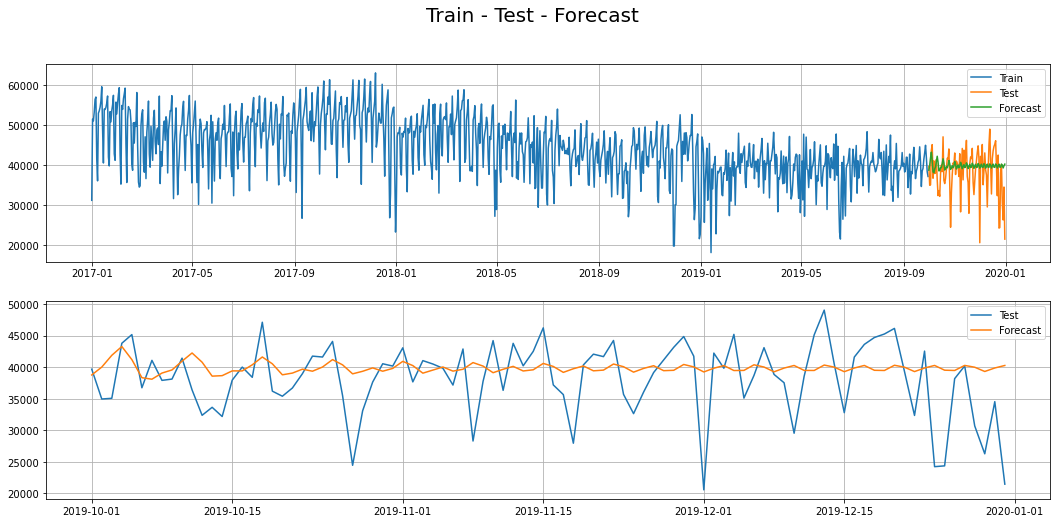

In [ ]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AA_diario)

### SARIMAX (diario)

Evaluamos agregando temporalidad diaria en el autoarima.

In [ ]:
modelAS_diario = auto_arima(diario.cantidad_pasos, start_p=0, start_q=0,
                      max_p=10, max_q=10  , max_d=2,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      start_Q=0,
                      D=1,
                      m=7, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True,
                      n_jobs=-1)
print(modelAS_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=22114.961, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=21892.938, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=21706.012, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=22113.360, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=22063.714, Time=0.07 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=21676.514, Time=1.29 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=21902.003, Time=0.21 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=21696.163, Time=1.97 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=21736.521, Time=2.19 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=21678.166, Time=1.92 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=21853.619, Time=0.33 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=21814.525, Time=0.97 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,2)(1,1,1)[7] interce

In [1214]:
# Best model:  ARIMA(0,0,2)(1,1,1)[7] 
# SARIMAX(0, 0, 2)x(1, 1, [1], 7)
modelAS_diario.fit(train_diario.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AS_diario = modelAS_diario.predict(n_periods=92)
predicciones_AS_diario = pd.Series(data=pred_AS_diario, index=test_diario.cantidad_pasos.index)
# predicciones_AS_diario.head()

In [1215]:
autosarimax_diario_res = evaluar_modelo(predicciones_AS_diario, test_diario.cantidad_pasos, "AutoSarimax Diario")
autosarimax_diario_res

Modelo         RMSE
0  AutoSarimax Diario  5359.273207

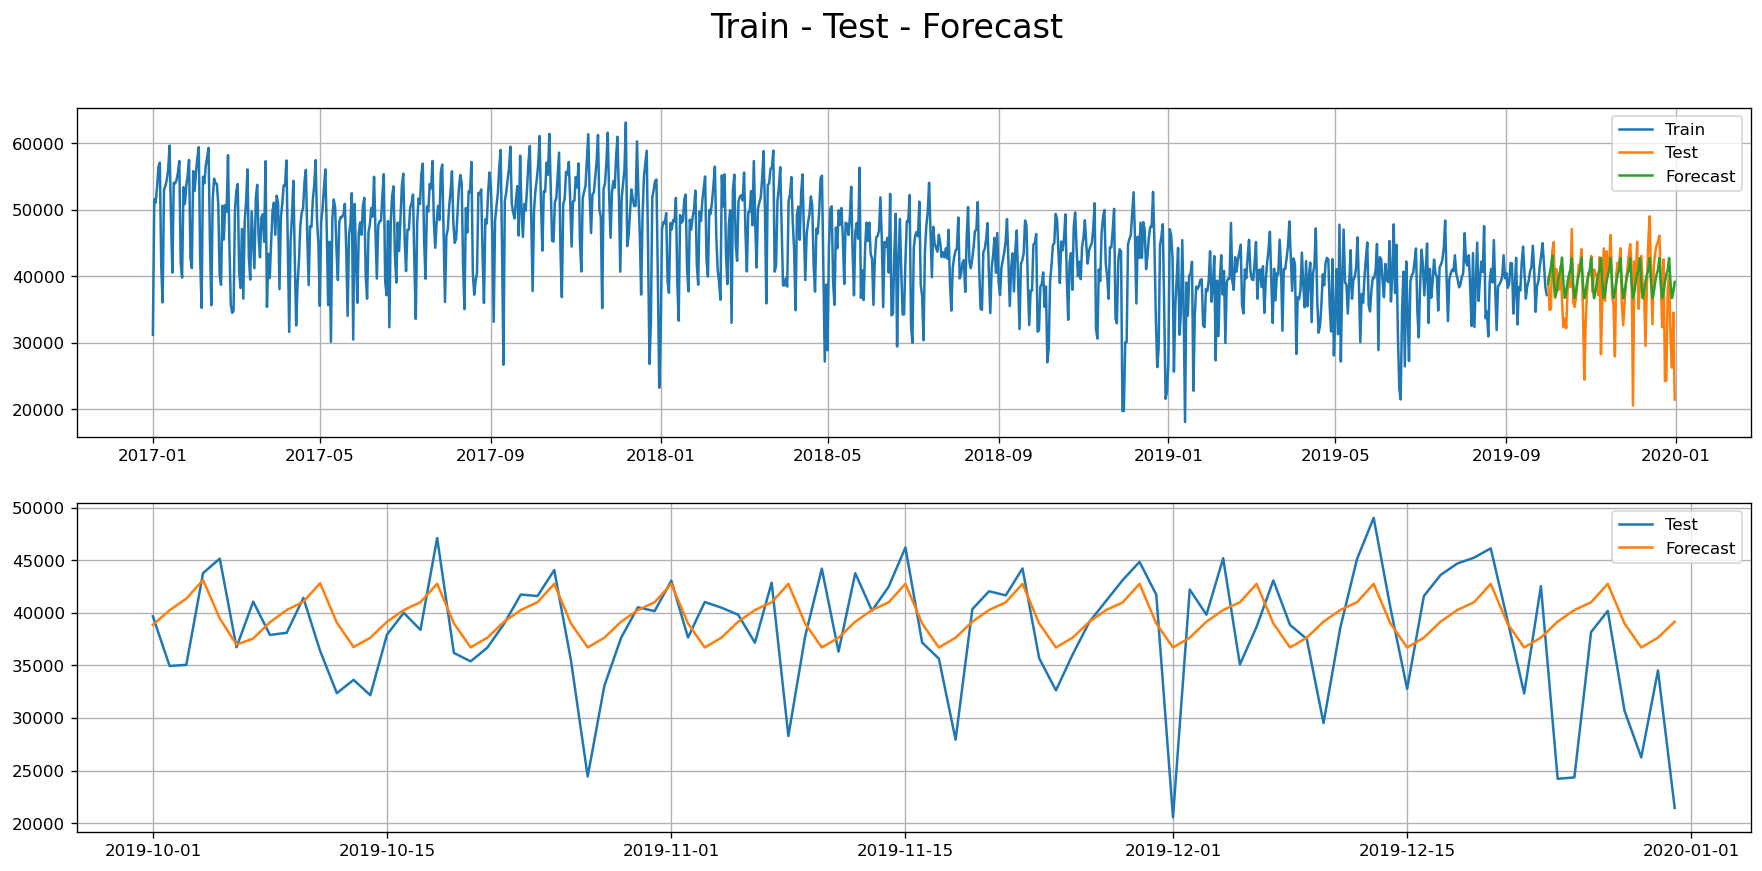

In [1200]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AS_diario)

<AxesSubplot:ylabel='Count'>

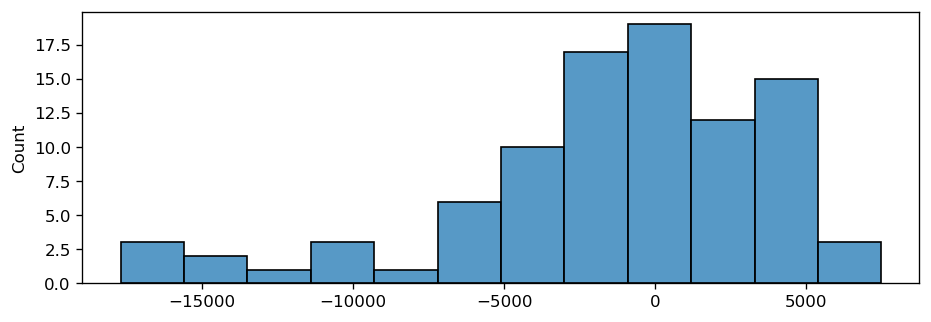

In [1201]:
sns.histplot(data = test_diario.cantidad_pasos - predicciones_AS_diario, 
                 label = "Error")

### AutoArima (semanal)

In [1202]:
modelAA_semanal = auto_arima(semanal.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      n_jobs=-1)
print(modelAA_semanal.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3518.164, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3515.027, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3515.583, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3516.306, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3513.263, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.126 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1755.632
Date:                Sun, 15 May 2022   AIC                           3513.263
Time:                        23:31:13   BIC                           3516.307
Sample:                             0   HQIC                          3514.500
                                - 156                                       

In [1206]:
# Best model:  ARIMA(1,1,0)(0,0,0)[0] 

modelAA_semanal.fit(train_semanal.cantidad_pasos)
# train_semanal.set_index('fecha', inplace=True)
# test_semanal.set_index('fecha', inplace=True)
pred_AA_semanal = modelAA_semanal.predict(n_periods=13, return_conf_int=False)
predicciones_AA_semanal = pd.Series(data=pred_AA_semanal, index=test_semanal.cantidad_pasos.index)
predicciones_AA_semanal.head()

fecha
2019-10-06    287568.0
2019-10-13    287568.0
2019-10-20    287568.0
2019-10-27    287568.0
2019-11-03    287568.0
dtype: float64

In [1207]:
autoarima_semanal_res = evaluar_modelo(predicciones_AA_semanal, test_semanal.cantidad_pasos, "AutoArima Semanal")
autoarima_semanal_res

Modelo          RMSE
0  AutoArima Semanal  23982.185443

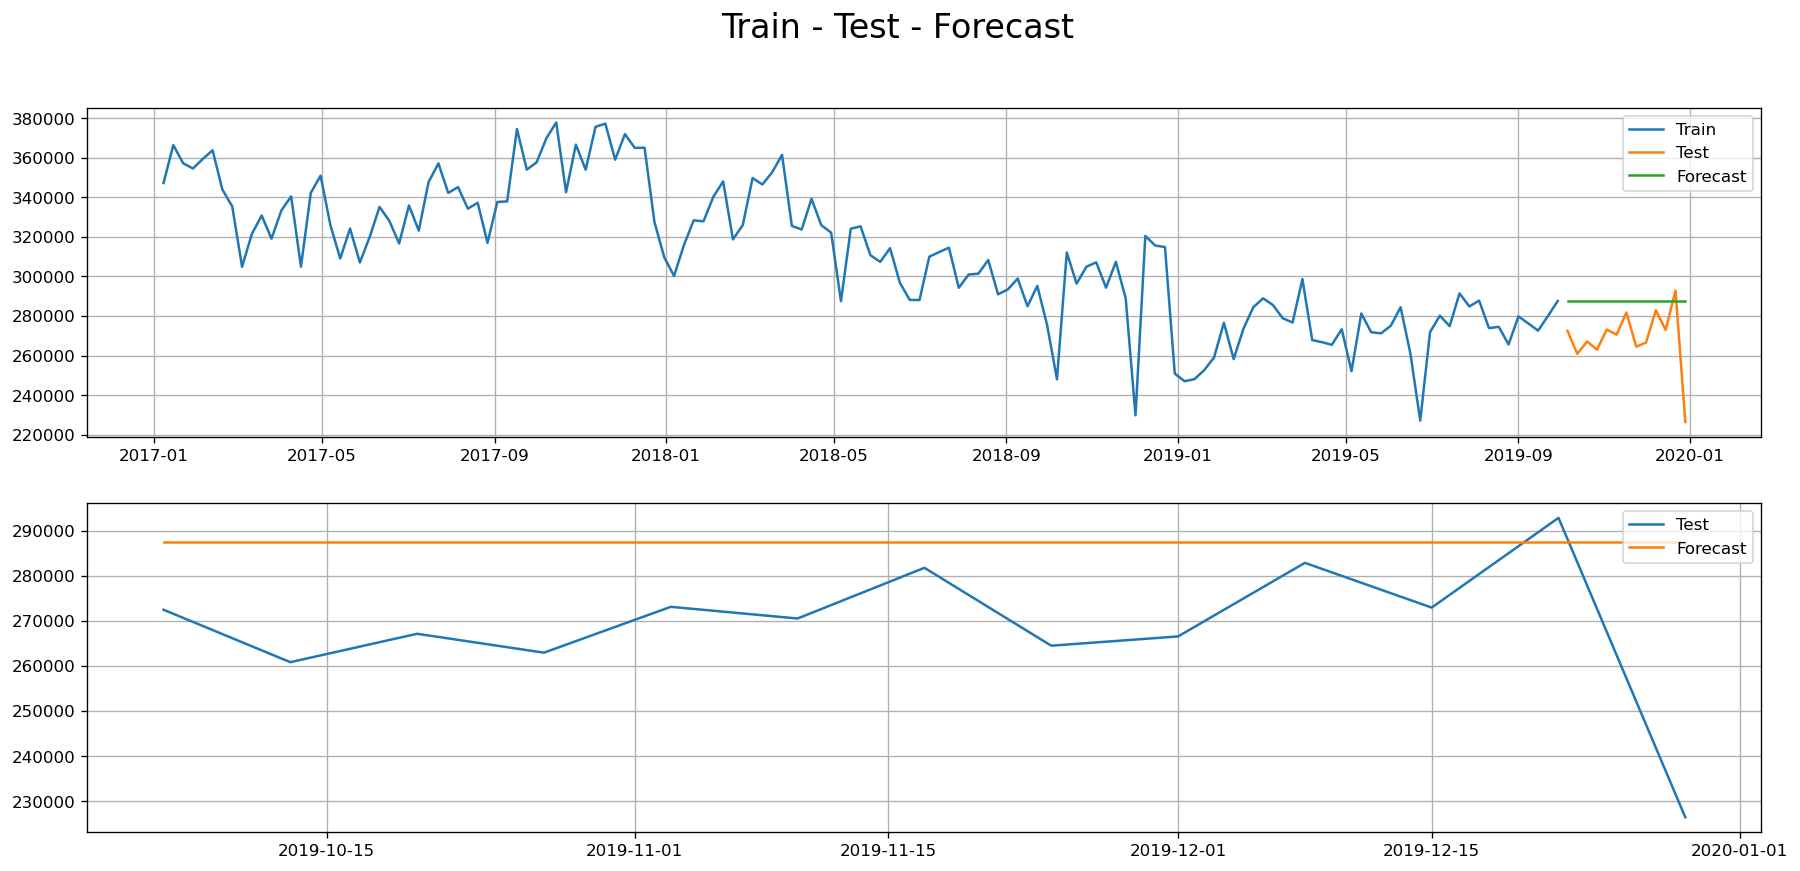

In [1208]:
plot_modelo(train_semanal.cantidad_pasos, test_semanal.cantidad_pasos, predicciones_AA_semanal)

#### SARIMAX (semanal)

Agregamos temporalidad semanal

In [1209]:
modelAS_semanal = auto_arima(diario.cantidad_pasos, start_p=0, start_q=0,
                      max_p=10, max_q=10  , max_d=2,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      start_Q=0,
                      D=1,
                      m=12, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True,
                      n_jobs=-1)
print(modelAS_semanal.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=22844.172, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=22492.330, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=22842.655, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=22741.237, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=22355.731, Time=0.89 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.95 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=22175.744, Time=2.91 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=22102.201, Time=4.40 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=22369.356, Time=3.22 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=22183.505, Time=5.05 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=22204.281, Time=5.13 sec
 ARIMA(0,0,1)(0,1,2)[12] inte

In [1210]:
# Best model:  ARIMA(4,0,0)(2,1,2)[12]
# SARIMAX(4, 0, 0)x(2, 1, [1, 2], 12)
modelAS_semanal.fit(train_semanal.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AS_semanal = modelAS_semanal.predict(n_periods=13)
predicciones_AS_semanal = pd.Series(data=pred_AS_semanal, index=test_semanal.cantidad_pasos.index)
# predicciones_AS_diario.head()

In [1211]:
autosarimax_semanal_res = evaluar_modelo(predicciones_AS_semanal, test_semanal.cantidad_pasos, "AutoSarimax semanal")
autosarimax_semanal_res

Modelo          RMSE
0  AutoSarimax semanal  17974.025079

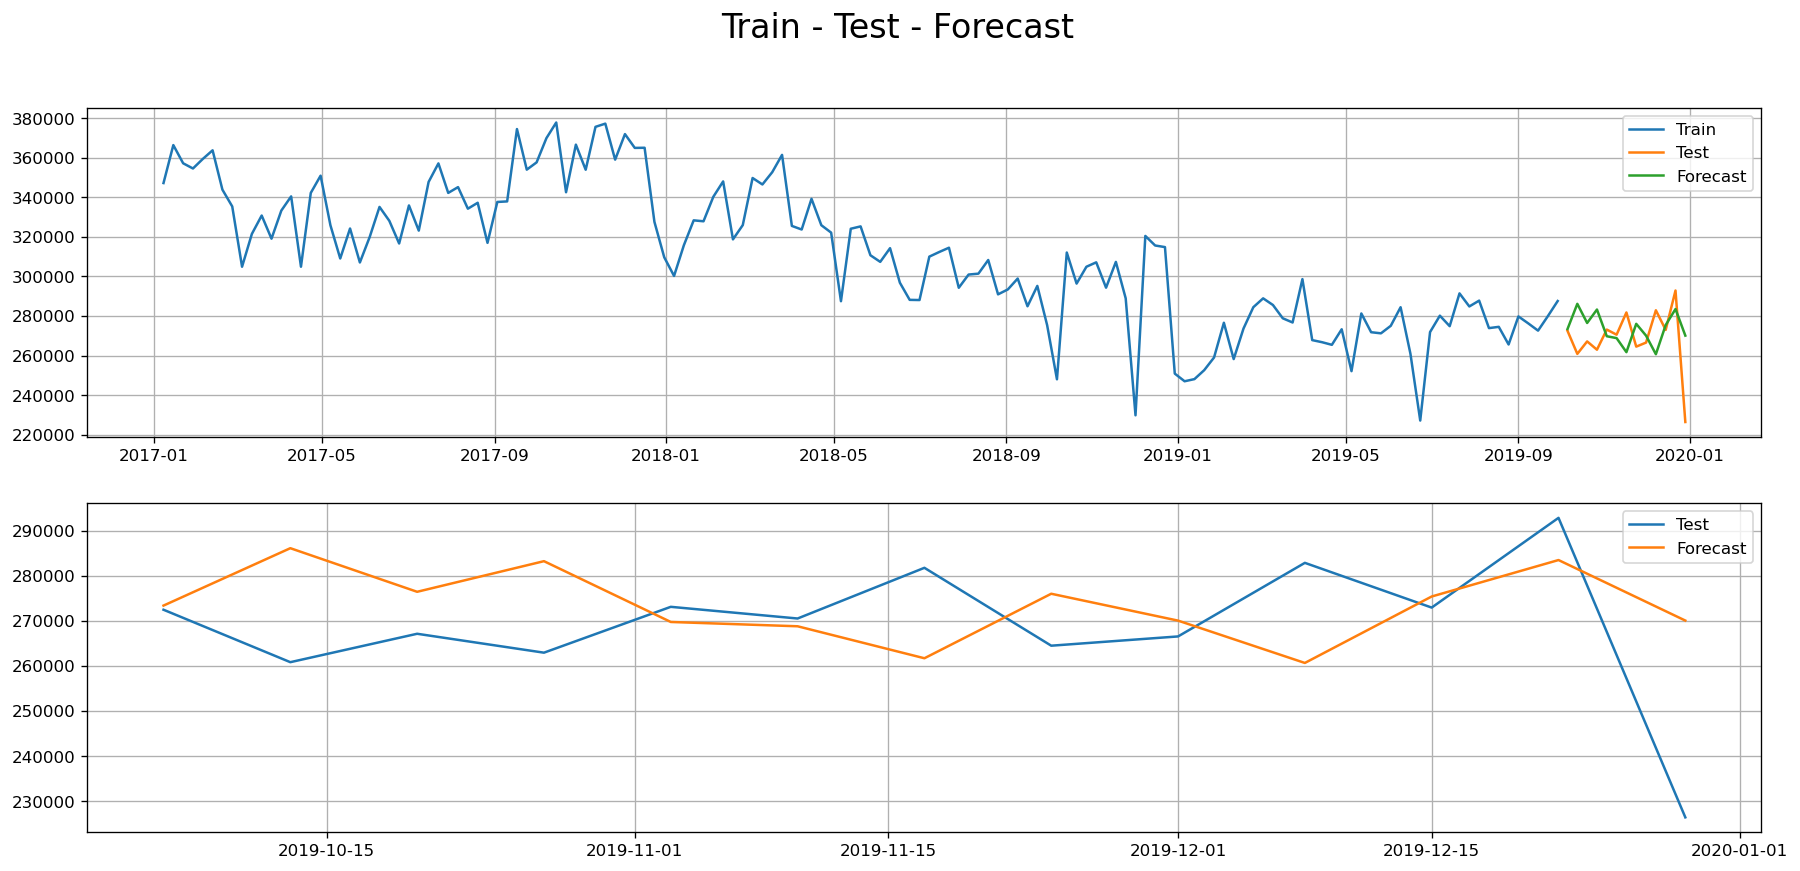

In [1212]:
plot_modelo(train_semanal.cantidad_pasos, test_semanal.cantidad_pasos, predicciones_AS_semanal)

In [1217]:
pd.concat([res_bench,
                        autoarima_diario_res, autosarimax_diario_res, 
                        autoarima_semanal_res, autosarimax_semanal_res
                         ])
# res_finales.reset_index(drop=True)

Modelo          RMSE
0    Benchmark(diario)   5966.847827
0   AutoArima-S Diario   5908.731997
0   AutoSarimax Diario   5359.273207
0    AutoArima Semanal  23982.185443
0  AutoSarimax semanal  17974.025079

## Prophet

### Prophet Diario

In [1218]:
diario.reset_index("fecha",inplace=True)



prophet_diario = pd.DataFrame({'ds':diario.fecha, 'y':diario.cantidad_pasos})


diario.set_index("fecha", inplace=True)


In [1219]:
separacion = '2019-10-01'
prophet_fore = prophet_diario.loc[prophet_diario.ds < separacion]
prophet_fore

ds        y
0    2017-01-01  31183.0
1    2017-01-02  51568.0
2    2017-01-03  51093.0
3    2017-01-04  53332.0
4    2017-01-05  56486.0
...         ...      ...
998  2019-09-26  43110.0
999  2019-09-27  44985.0
1000 2019-09-28  41925.0
1001 2019-09-29  38348.0
1002 2019-09-30  37170.0

[1003 rows x 2 columns]

In [1220]:
diario_datos_test = prophet_diario.loc[prophet_diario.ds >= separacion]
diario_datos_test

ds        y
1003 2019-10-01  39669.0
1004 2019-10-02  34943.0
1005 2019-10-03  35054.0
1006 2019-10-04  43775.0
1007 2019-10-05  45150.0
...         ...      ...
1090 2019-12-27  40182.0
1091 2019-12-28  30681.0
1092 2019-12-29  26259.0
1093 2019-12-30  34523.0
1094 2019-12-31  21447.0

[92 rows x 2 columns]

In [1221]:
prophet_diario_model = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_diario_model.fit(prophet_fore)
pred_prophet = prophet_diario_model.make_future_dataframe(periods=92, freq="D")
forecast = prophet_diario_model.predict(pred_prophet)

In [1222]:
forecast.tail(3)

ds        trend    yhat_lower    yhat_upper  trend_lower  \
1092 2019-12-29  8809.510816  18463.877773  38640.908108  1169.900756   
1093 2019-12-30  8806.448869  24669.212882  43932.092775   912.416275   
1094 2019-12-31  8803.386922  25670.340511  45163.163957   784.383633   

       trend_upper  additive_terms  additive_terms_lower  \
1092  16440.504411    19597.967983          19597.967983   
1093  16619.598224    25404.642785          25404.642785   
1094  16705.825371    26388.571911          26388.571911   

      additive_terms_upper         daily  ...       weekly  weekly_lower  \
1092          19597.967983  29952.678646  ... -7250.911009  -7250.911009   
1093          25404.642785  29952.678646  ... -1086.138521  -1086.138521   
1094          26388.571911  29952.678646  ...   225.557800    225.557800   

      weekly_upper       yearly  yearly_lower  yearly_upper  \
1092  -7250.911009 -3103.799654  -3103.799654  -3103.799654   
1093  -1086.138521 -3461.897340  -3461.897340  -3461.897340   
1094    225.557800 -3789.664534  -3789.664534  -3789.664534   

      multiplicative_terms  multiplicative_terms_lower  \
1092                   0.0                         0.0   
1093                   0.0                         0.0   
1094                   0.0                         0.0   

      multiplicative_terms_upper          yhat  
1092                         0.0  28407.478799  
1093                         0.0  34211.091654  
1094                         0.0  35191.958833  

[3 rows x 22 columns]

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

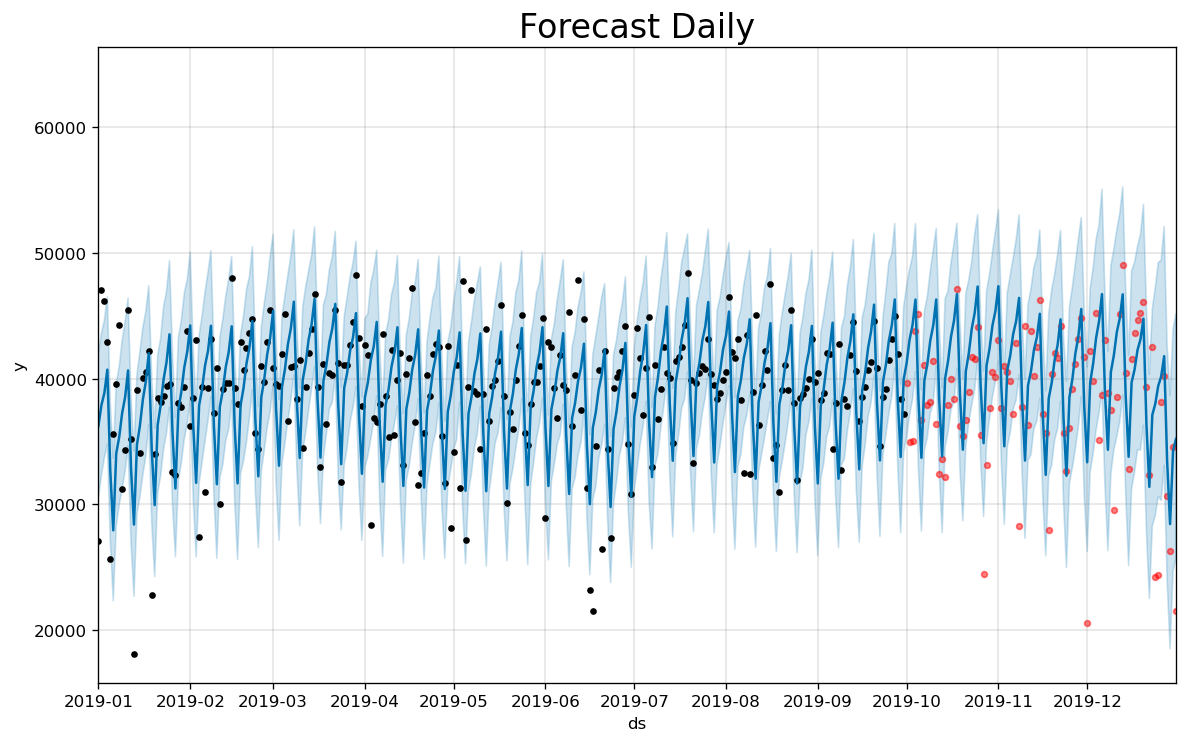

In [1223]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast Daily', fontsize=20)

In [1224]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds >= separacion) & (forecast.ds <= "2019-12-31")]
y_true = diario_datos_test[['ds', 'y']]


res_prophet_diario = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario")
res_prophet_diario

Modelo         RMSE
0  Prophet Diario  5526.999822

#### Optimizacion HP

In [719]:
# # Python
# import itertools
# import numpy as np
# import pandas as pd

# param_grid = {  
#     # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     # 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'changepoint_prior_scale': [0.001,0.01,0.1, 0.5, 0.7],
#     'seasonality_prior_scale': [0.001, 0.005,0.01,0.05,0.1,0.5,1,5,10],


# }



# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params, daily_seasonality=True).fit(prophet_fore)  # Fit model with given params
#     df_cv = cross_validation(m, horizon='92 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

INFO:prophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001819EBD2B20>
INFO:prophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000181A7EE9E20>
INFO:prophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001819D027F70>
INFO:prophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001819CFCF3A0>
INFO:prophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:prophet:Applying in parallel with <co

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                    0.001  10200.248111
1                     0.001                    0.005   9811.130000
2                     0.001                    0.010   8065.577850
3                     0.001                    0.050  13034.564491
4                     0.001                    0.100  12968.953247
5                     0.001                    0.500  11551.262128
6                     0.001                    1.000  15420.993186
7                     0.001                    5.000  12267.003733
8                     0.001                   10.000   9472.515496
9                     0.010                    0.001   6471.333111
10                    0.010                    0.005   5858.208857
11                    0.010                    0.010   6131.706897
12                    0.010                    0.050   6574.913199
13                    0.010                    0.100   6584.10

In [720]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.005}


In [718]:
# {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.03}
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.005}

In [1390]:
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.020}

In [1391]:
prophet_diario_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model_op.fit(prophet_fore)
pred_prophet = prophet_diario_model_op.make_future_dataframe(periods=92)
forecast = prophet_diario_model_op.predict(pred_prophet)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

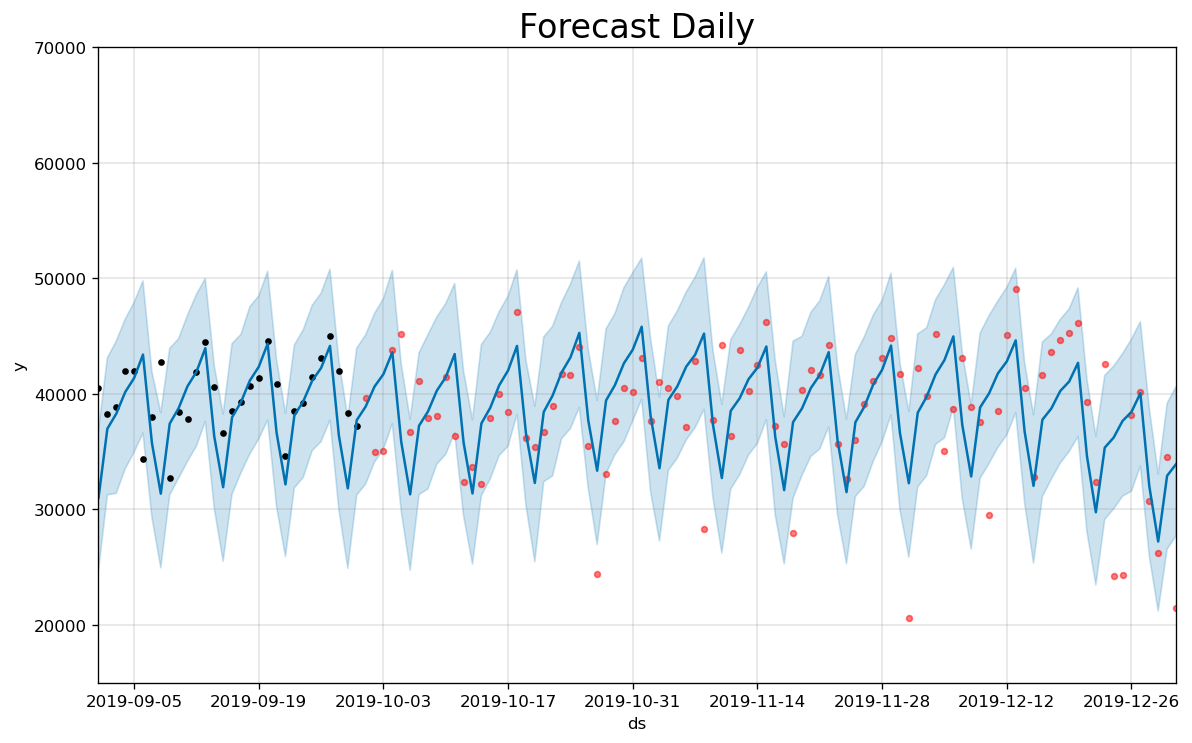

In [1392]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model_op.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-09-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(15000, 70000)
plt.title('Forecast Daily', fontsize=20)

In [1394]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds >= separacion) & (forecast.ds < "2020-01-05")]
y_true = diario_datos_test[['ds', 'y']]


res_prophet_diario_opt = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario CV/HP")
res_prophet_diario_opt

Modelo        RMSE
0  Prophet Diario CV/HP  5031.69983

### Prophet Semanal

In [1236]:
semanal.reset_index("fecha",inplace=True)

prophet_semanal = pd.DataFrame({'ds':semanal.fecha, 'y':semanal.cantidad_pasos})

semanal.set_index("fecha", inplace=True)

In [1237]:
separacion = '2019-10-01'
prophet_fore_semanal = prophet_semanal.loc[prophet_semanal.ds < separacion]
prophet_fore_semanal

semanal_datos_test = prophet_semanal.loc[prophet_semanal.ds >= separacion]
len(semanal_datos_test)

13

In [1249]:
semanal_datos_test

ds         y
143 2019-10-06  272483.0
144 2019-10-13  260840.0
145 2019-10-20  267147.0
146 2019-10-27  262950.0
147 2019-11-03  273129.0
148 2019-11-10  270536.0
149 2019-11-17  281790.0
150 2019-11-24  264500.0
151 2019-12-01  266555.0
152 2019-12-08  282891.0
153 2019-12-15  272960.0
154 2019-12-22  292881.0
155 2019-12-29  226390.0

In [1273]:
prophet_semanal = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_semanal.fit(prophet_fore_semanal)
pred_prophet_semanal = prophet_semanal.make_future_dataframe(periods=13, freq="W")
forecast_semanal = prophet_semanal.predict(pred_prophet_semanal)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

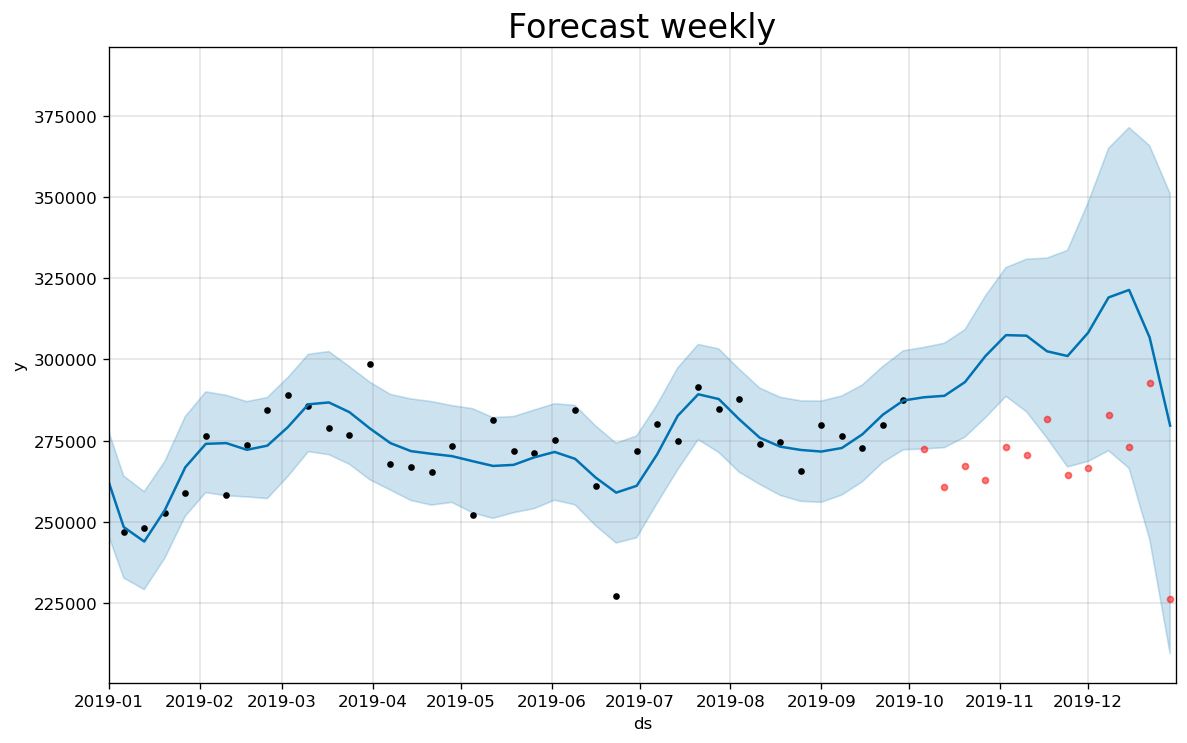

In [1501]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal.plot(forecast_semanal)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=13 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

In [1275]:
y_pred = forecast_semanal[['ds', 'yhat']].loc[(forecast_semanal.ds >= separacion) & (forecast_semanal.ds <= "2019-12-31")]
y_true = semanal_datos_test[['ds', 'y']]


res_prophet_semanal = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal")
res_prophet_semanal

Modelo          RMSE
0  Prophet Semanal  34924.309613

In [1338]:
# # Python
# import itertools
# import numpy as np
# import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     # 'changepoint_prior_scale': [0.001,0.01,0.1, 0.5, 0.7],
#     # 'seasonality_prior_scale': [0.001, 0.005,0.01,0.05,0.1,0.5,1,5,10],


# }



# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params, daily_seasonality=True, weekly_seasonality=True).fit(prophet_fore_semanal)  # Fit model with given params
#     df_cv = cross_validation(m, horizon='13 w', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [1337]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

In [1330]:
best_params = {'changepoint_prior_scale': 0.07, 'seasonality_prior_scale': 0.005}

In [1331]:
prophet_semanal_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_semanal_model_op.fit(prophet_fore_semanal)
pred_prophet_semanal_op = prophet_semanal_model_op.make_future_dataframe(periods=13, freq="W" )
forecast_semanal_op = prophet_semanal_model_op.predict(pred_prophet_semanal_op)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

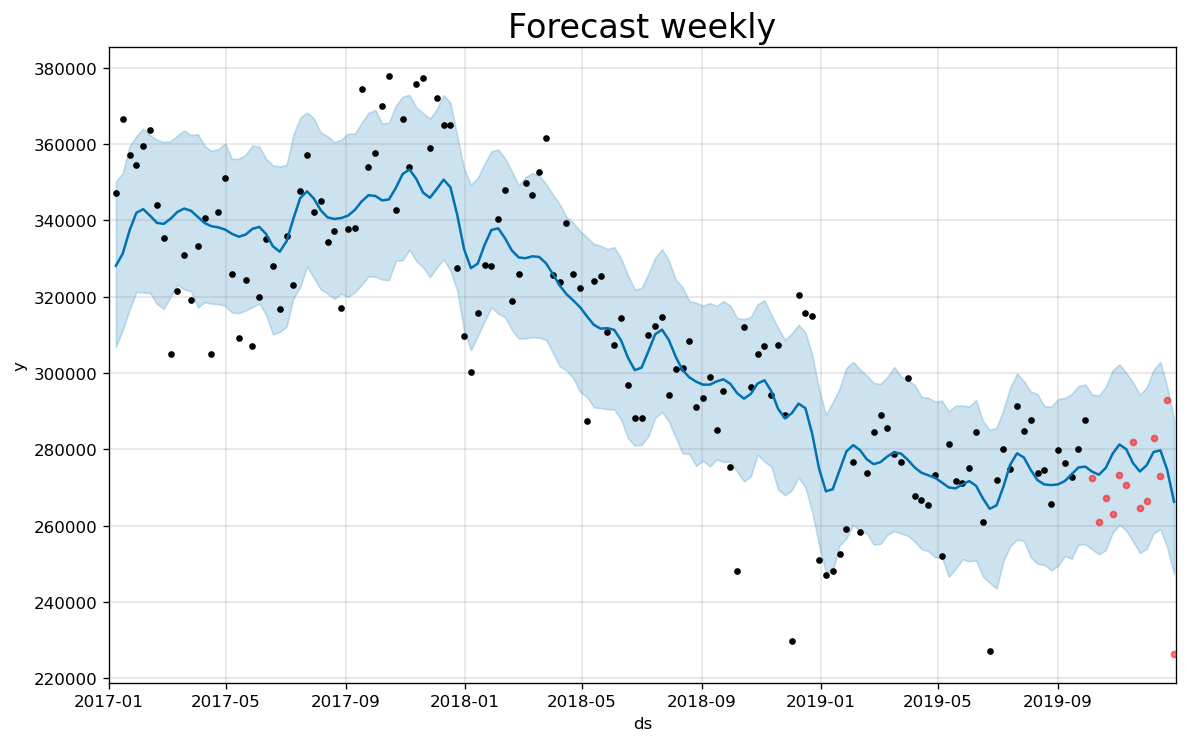

In [1502]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal.plot(forecast_semanal_op)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=13 ,alpha=0.5)
dates=np.array(["2017-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

In [1398]:
y_pred = forecast_semanal_op[['ds', 'yhat']].loc[(forecast_semanal_op.ds >= separacion) & (forecast_semanal_op.ds <= "2019-12-31")]
y_true = semanal_datos_test[['ds', 'y']]


res_prophet_semanal_op = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal CV/HP")
res_prophet_semanal_op

Modelo          RMSE
0  Prophet Semanal CV/HP  14723.541146

In [1399]:
pd.concat([res_bench,
                        autoarima_diario_res, autosarimax_diario_res, 
                        res_prophet_diario, res_prophet_diario_opt,
                        
                        autoarima_semanal_res, autosarimax_semanal_res,
                        res_prophet_semanal, res_prophet_semanal_op
                         ])

Modelo          RMSE
0      Benchmark(diario)   5966.847827
0     AutoArima-S Diario   5908.731997
0     AutoSarimax Diario   5359.273207
0         Prophet Diario   5526.999822
0   Prophet Diario CV/HP   5031.699830
0      AutoArima Semanal  23982.185443
0    AutoSarimax semanal  17974.025079
0        Prophet Semanal  34924.309613
0  Prophet Semanal CV/HP  14723.541146

El modelo que mejor desempeño obtuvo, para la predicción diaria fue **Prophet Diario CV/HP**, el cual obtuvo una mejora de ~15% respecto al modelo Benchmark, por lo cual es el elegido como mejor modelo.

Para la predicción semanal, al igual que la diaria Prophet, fue el Prophet optimizado, logrando una mejora de ~39% respecto al modelo AutoArima.

# Investigacion

Se observo en el EDA que el uso del "TELEPASE" ha incrementado entre el 2017 y finales del 2019.
Una vez regularizado el flujo vehicular despues de cuarentena, 
Pregunta 1: ¿Se mantendrá la misma tendencia?
Pregunta 2: ¿Se obtendría buenas predicciones, con los datos de los años 2017, 2018 y 2019? 

El flujo de trabajo para responder las preguntas, seria básicamente el mismos ya utilizado.
con la diferencia que se utilizaría el total de los datos de los años 2017, 2018 y 2019.


## Predicción 2020 y 2021 (Telepase)

### transformación de datos

##### Data 2017 - 2019

In [1402]:
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'TELEPASE')

dataset_2 = dataset[mask]


data_2017_2019 = dataset_2[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum()
data_2017_2019["fecha_num"] = data_2017_2019.index.map(dt.datetime.toordinal)
# data_2017_2020.head(2).append(diario.tail(2))

data_2017_2019[data_2017_2019.cantidad_pasos < 10000] = np.nan


# print(data_2017_2020.isna().sum())
data_2017_2019 = data_2017_2019.interpolate(method="nearest")
# print(data_2017_2020.isna().sum())
data_2017_2019.head(2).append(diario.tail(2))


data_2017_2019.reset_index("fecha",inplace=True)


data_2017_2019_semanal = data_2017_2019.copy()
# semanal.reset_index(inplace=True)
data_2017_2019_semanal.drop(columns=['fecha_num'], inplace=True)

# semanal.reset_index('fecha', inplace=True)
data_2017_2019.set_index("fecha", inplace=True)

data_2017_2019_semanal = data_2017_2019_semanal[["fecha","cantidad_pasos"]].resample('W', on = 'fecha').sum()
data_2017_2019_semanal["fecha_num"] = data_2017_2019_semanal.index.map(dt.datetime.toordinal)
data_2017_2019_semanal.head(3).append(data_2017_2019_semanal.tail(3))


data_2017_2019_semanal.drop(data_2017_2019_semanal.tail(1).index,inplace=True)
data_2017_2019_semanal.drop(data_2017_2019_semanal.head(1).index,inplace=True)
data_2017_2019_semanal.head(3).append(data_2017_2019_semanal.tail(3))

cantidad_pasos  fecha_num
fecha                                
2017-01-08        225716.0     736337
2017-01-15        233261.0     736344
2017-01-22        229329.0     736351
2019-12-15        357831.0     737408
2019-12-22        407208.0     737415
2019-12-29        282395.0     737422

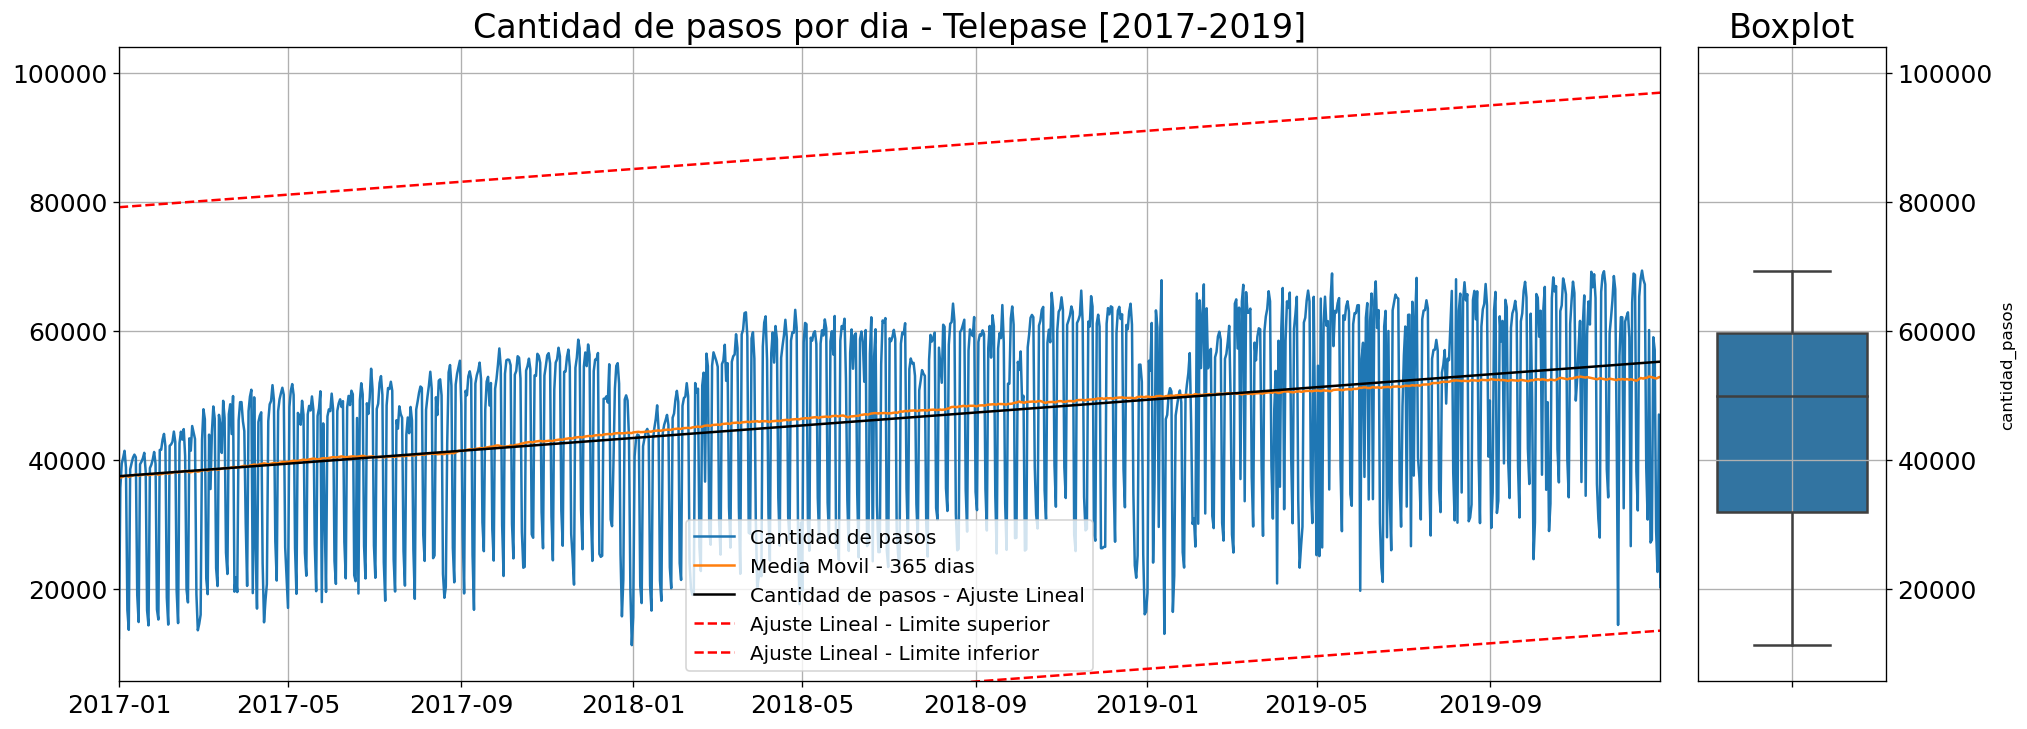

In [1425]:
plot_time(data_2017_2019,"- Telepase [2017-2019]","D")

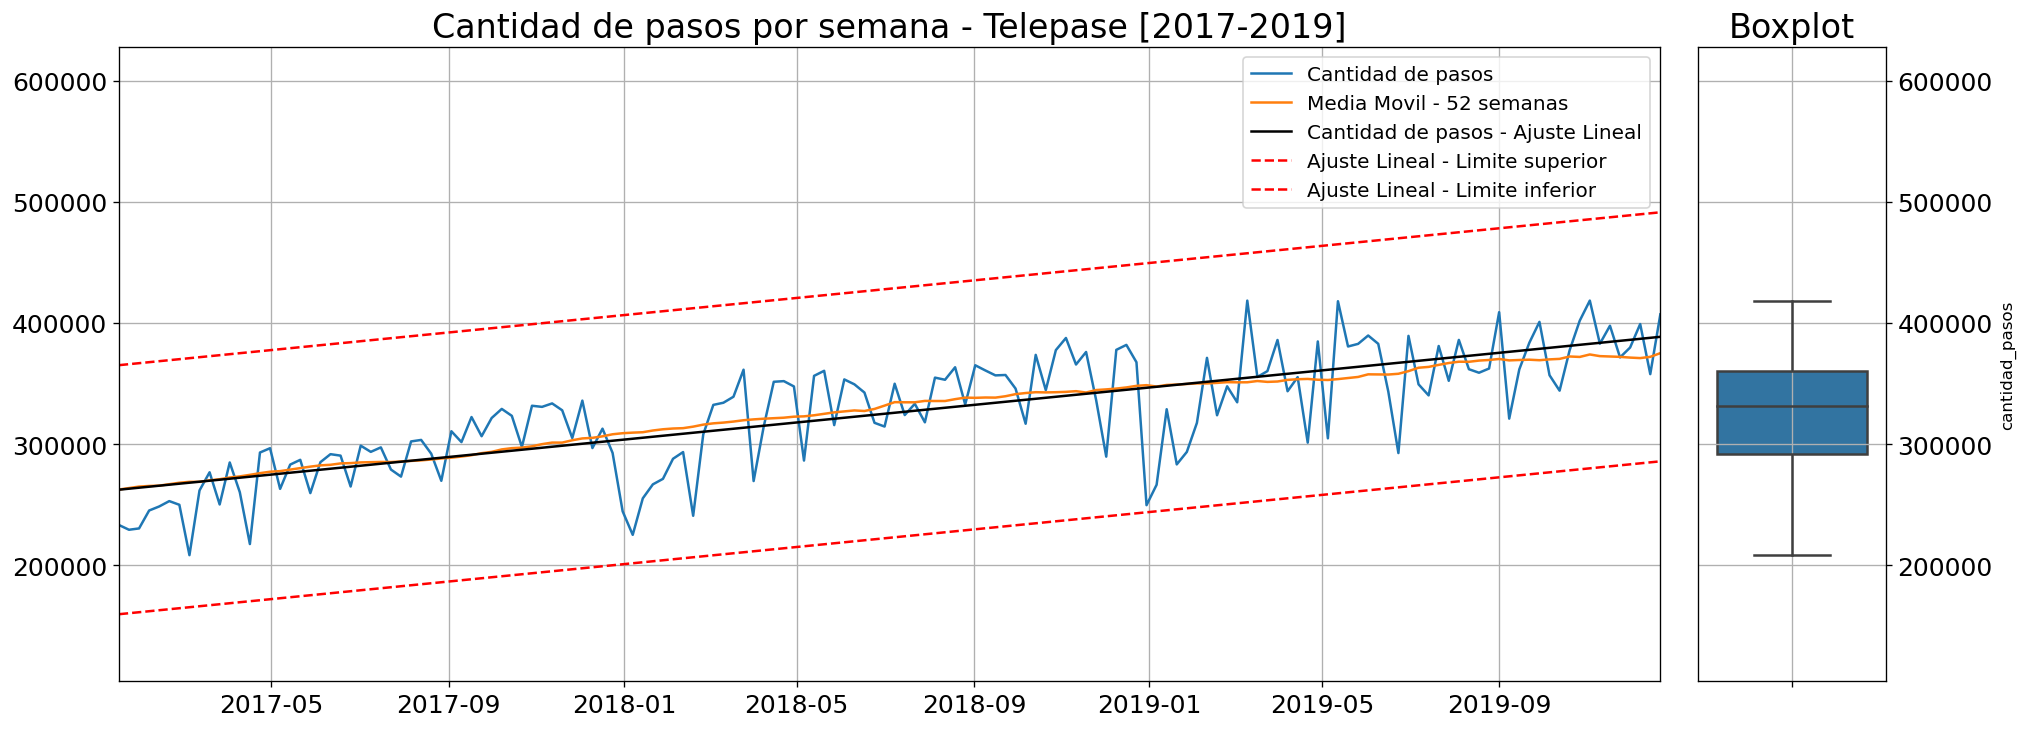

In [1424]:
data_2017_2019_semanal
plot_time(data_2017_2019_semanal,"- Telepase [2017-2019]","W")

##### Data 2020

In [976]:
# data_2020.info()
# data_2020.head(3).append(data_2020.tail(3))

In [977]:
# print(data_2020['estacion'].unique())
# print(data_2020['forma_pago'].unique())

In [980]:
data_2020['cantidad_pasos'].astype('int64')

mask = np.logical_and(data_2020['estacion'] =='ILLIA', np.logical_or( data_2020['forma_pago'] == 'Tag', data_2020['forma_pago'] == 'Mercado Pago'))

data_2020_ = data_2020[mask]

data_2020_['fecha']=pd.to_datetime(data_2020_['fecha'])
data_2020_ = data_2020_[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum()
data_2020_["fecha_num"] = data_2020_.index.map(dt.datetime.toordinal)
data_2020_.head(2).append(data_2020_.tail(2))

cantidad_pasos  fecha_num
fecha                                
2020-01-01         18882.0     737425
2020-01-02         48376.0     737426
2020-12-30         60778.0     737789
2020-12-31         33932.0     737790

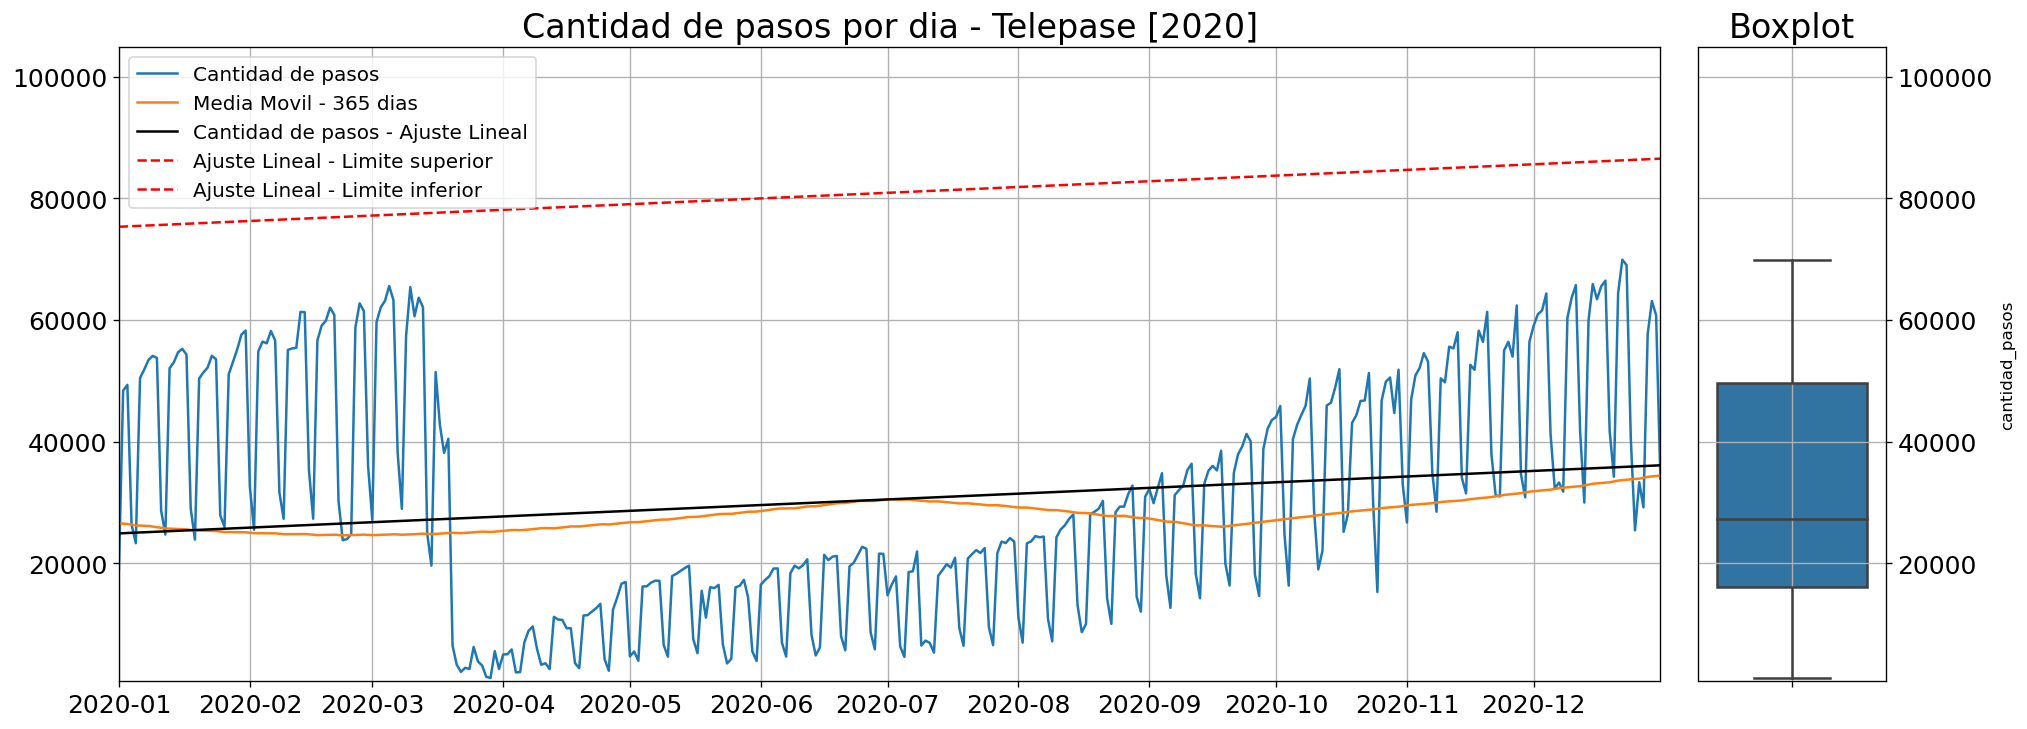

In [1427]:
plot_time(data_2020_,"- Telepase [2020]","D")

##### Data 2021

In [972]:
# data_2021.info()
# data_2021.head(3).append(data_2021.tail(3))

In [973]:
# data_2021.columns

In [802]:
# print(data_2021['ID Peaje'].unique())
# print(data_2021['Tipo Cobro'].unique())

['ALB' 'AVE' 'DEC' 'DEL' 'ILL' 'ILP' 'PB1' 'PB2' 'PB3' 'PB4' 'RET' 'SAL'
 'SAR' 'Total']
['Efectivo' 'Mercado Pago' 'Rec.Deuda' 'Tag' 'Exento' 'Tarjeta Magnética'
 'Violación' 'Total' 'CPP']


In [1015]:
mask = np.logical_and(data_2021['ID Peaje'] =='ILL', np.logical_or( data_2021['Tipo Cobro'] == 'Tag', data_2021['Tipo Cobro'] == 'Mercado Pago'))

data_2021_ = data_2021[mask]

data_2021_= data_2021_.astype({'Año de Fecha Operativa': 'int64', 'Día de Fecha Operativa' : 'int64',
       'Hora HH' : 'int64', 'Pasos' : 'int64'})

nmes = {'enero': "1",
    'febrero': "2",
    'marzo': "3",
    'abril': "4",
    'mayo': "5",
    'junio': "6",
    'julio': "7",
    'agosto': "8",
    'septiembre':"9",
    'octubre':"10",
    'noviembre':"11",
    'diciembre':"12",
    }


data_2021_['Numero Mes de Fecha Operativa'] = data_2021['Mes de Fecha Operativa'].map(nmes)

cols=["Año de Fecha Operativa","Numero Mes de Fecha Operativa","Día de Fecha Operativa"]
data_2021_['fecha'] = data_2021_[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
data_2021_['fecha']=pd.to_datetime(data_2021_['fecha'])

data_2021_.rename({"Pasos": "cantidad_pasos"}, axis=1, inplace=True)

data_2021_ = data_2021_[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum()
data_2021_["fecha_num"] = data_2021_.index.map(dt.datetime.toordinal)
data_2021_.head(2).append(data_2021_.tail(2))
       

cantidad_pasos  fecha_num
fecha                                
2021-01-01           20290     737791
2021-01-02           28776     737792
2021-12-30           62573     738154
2021-12-31           32625     738155

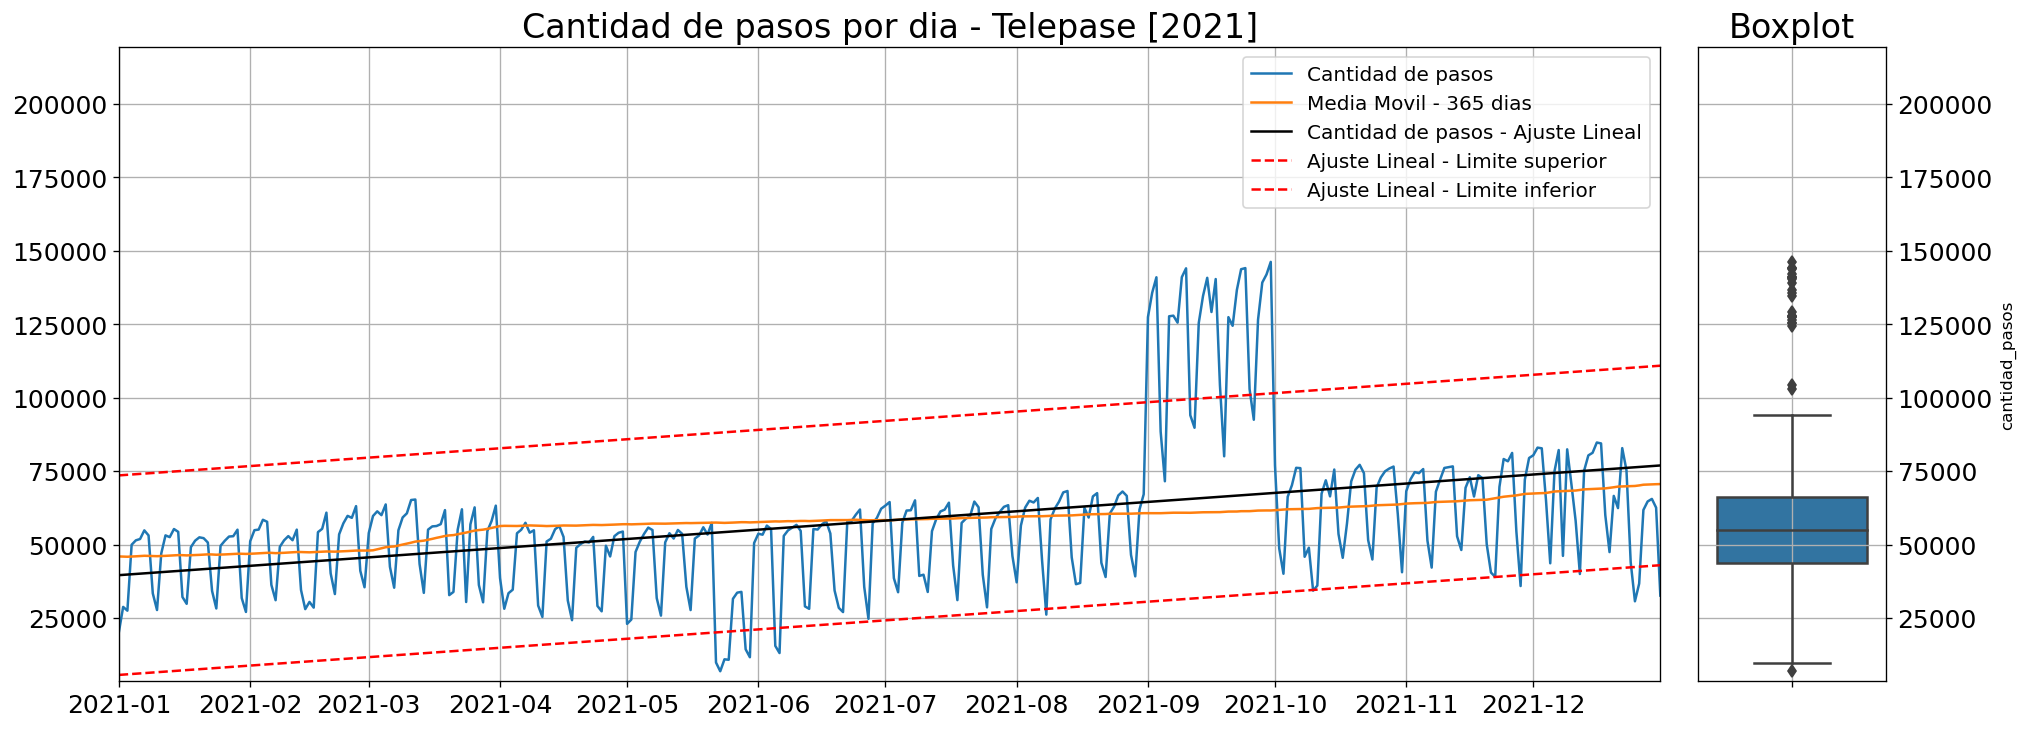

In [1428]:
plot_time(data_2021_,"- Telepase [2021]","D")

In [968]:
data_2020_2021 = pd.concat([data_2020_,data_2021_])

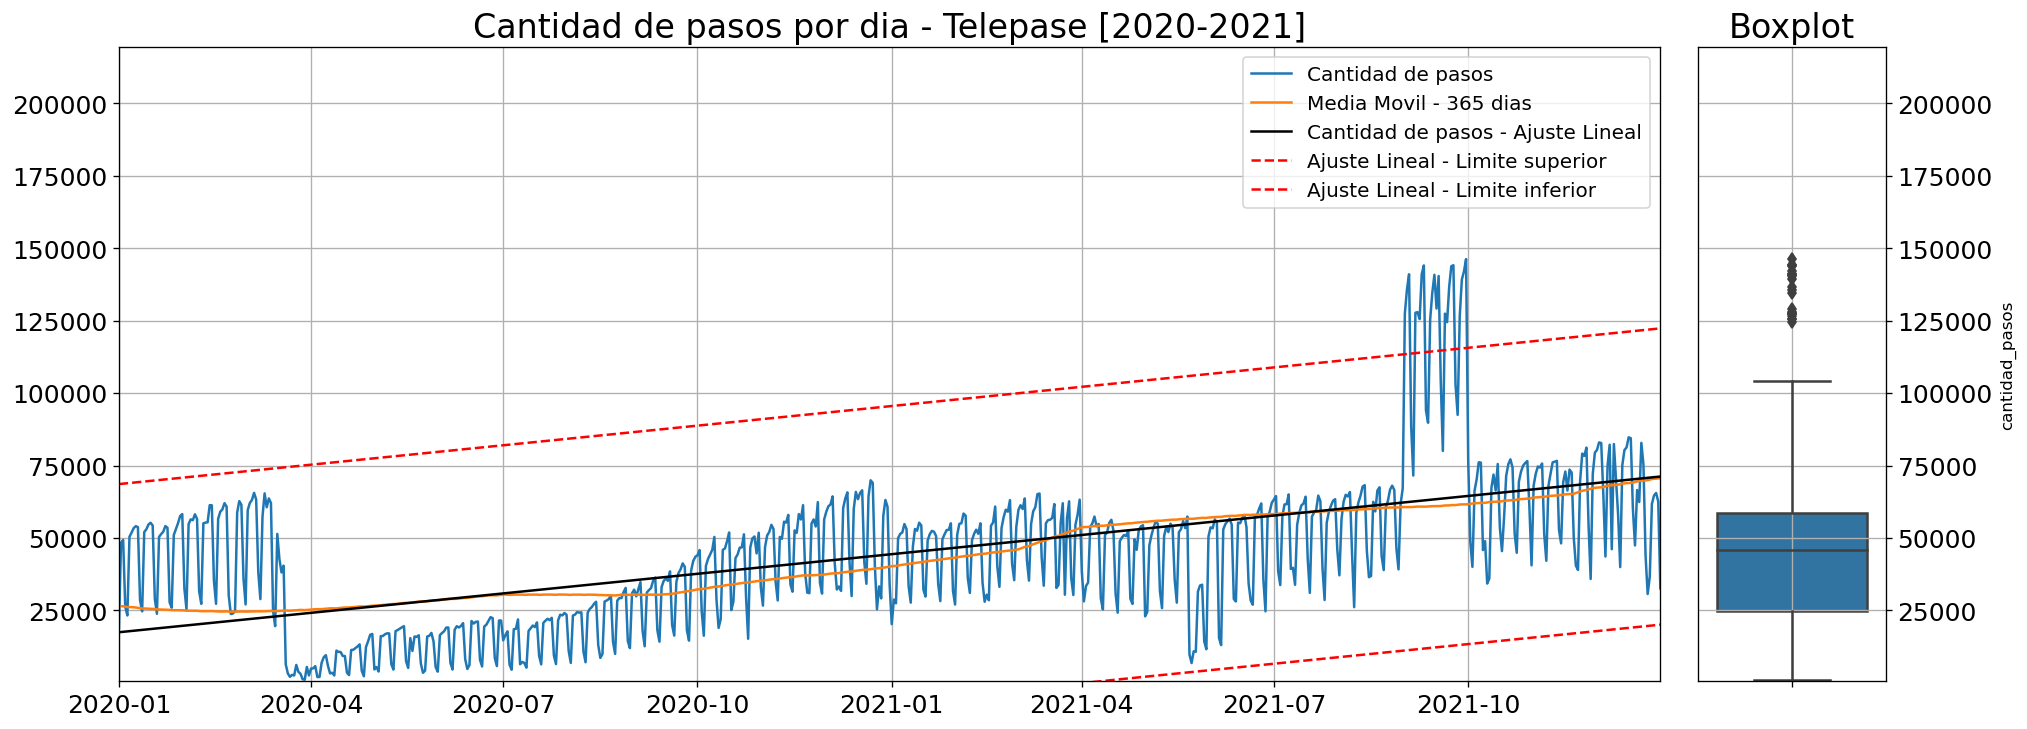

In [1430]:
plot_time(data_2020_2021,"- Telepase [2020-2021]","D")

In [1029]:
data_2020_2021.reset_index("fecha",inplace=True)
data_2020_2021_semanal = data_2020_2021.copy()
# semanal.reset_index(inplace=True)
data_2020_2021_semanal.drop(columns=['fecha_num'], inplace=True)

# semanal.reset_index('fecha', inplace=True)
data_2020_2021.set_index("fecha", inplace=True)

data_2020_2021_semanal = data_2020_2021_semanal[["fecha","cantidad_pasos"]].resample('W', on = 'fecha').sum()
data_2020_2021_semanal["fecha_num"] = data_2020_2021_semanal.index.map(dt.datetime.toordinal)
data_2020_2021_semanal.head(3).append(data_2020_2021_semanal.tail(3))


# data_2020_2021_semanal.drop(data_2020_2021_semanal.tail(1).index,inplace=True)
# data_2020_2021_semanal.drop(data_2020_2021_semanal.head(1).index,inplace=True)
data_2020_2021_semanal.head(3).append(data_2020_2021_semanal.tail(3))

cantidad_pasos  fecha_num
fecha                                
2020-01-05        166198.0     737429
2020-01-12        316930.0     737436
2020-01-19        322244.0     737443
2021-12-19        513415.0     738143
2021-12-26        398481.0     738150
2022-01-02        287191.0     738157

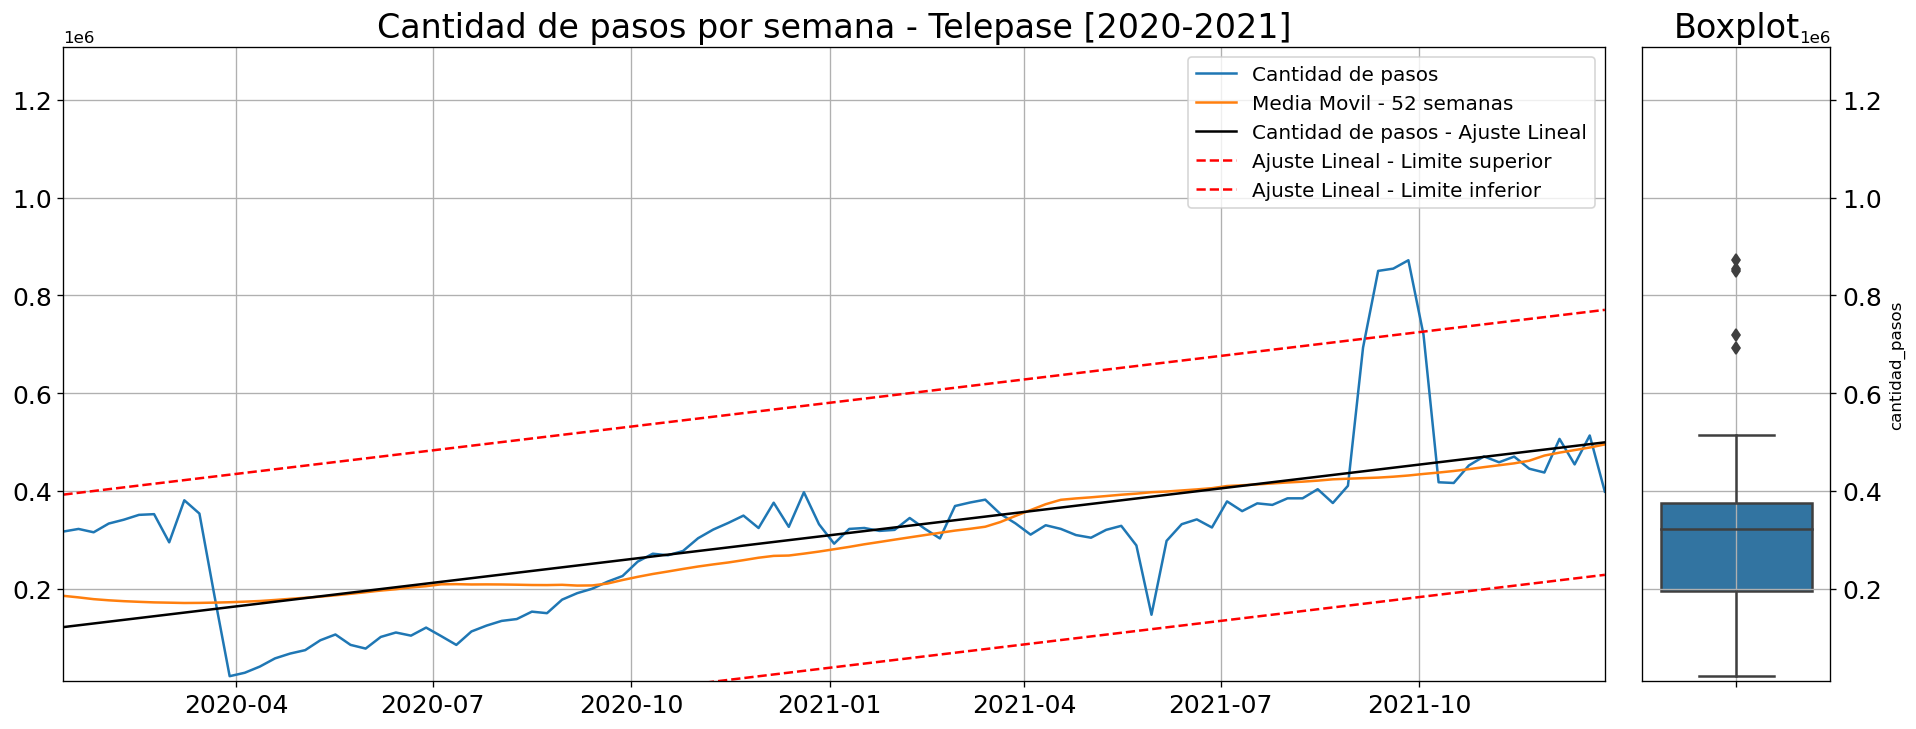

In [1431]:
plot_time(data_2020_2021_semanal,"- Telepase [2020-2021]","W")

In [1411]:
data_2017_2021 = pd.concat([data_2017_2019,data_2020_,data_2021_])

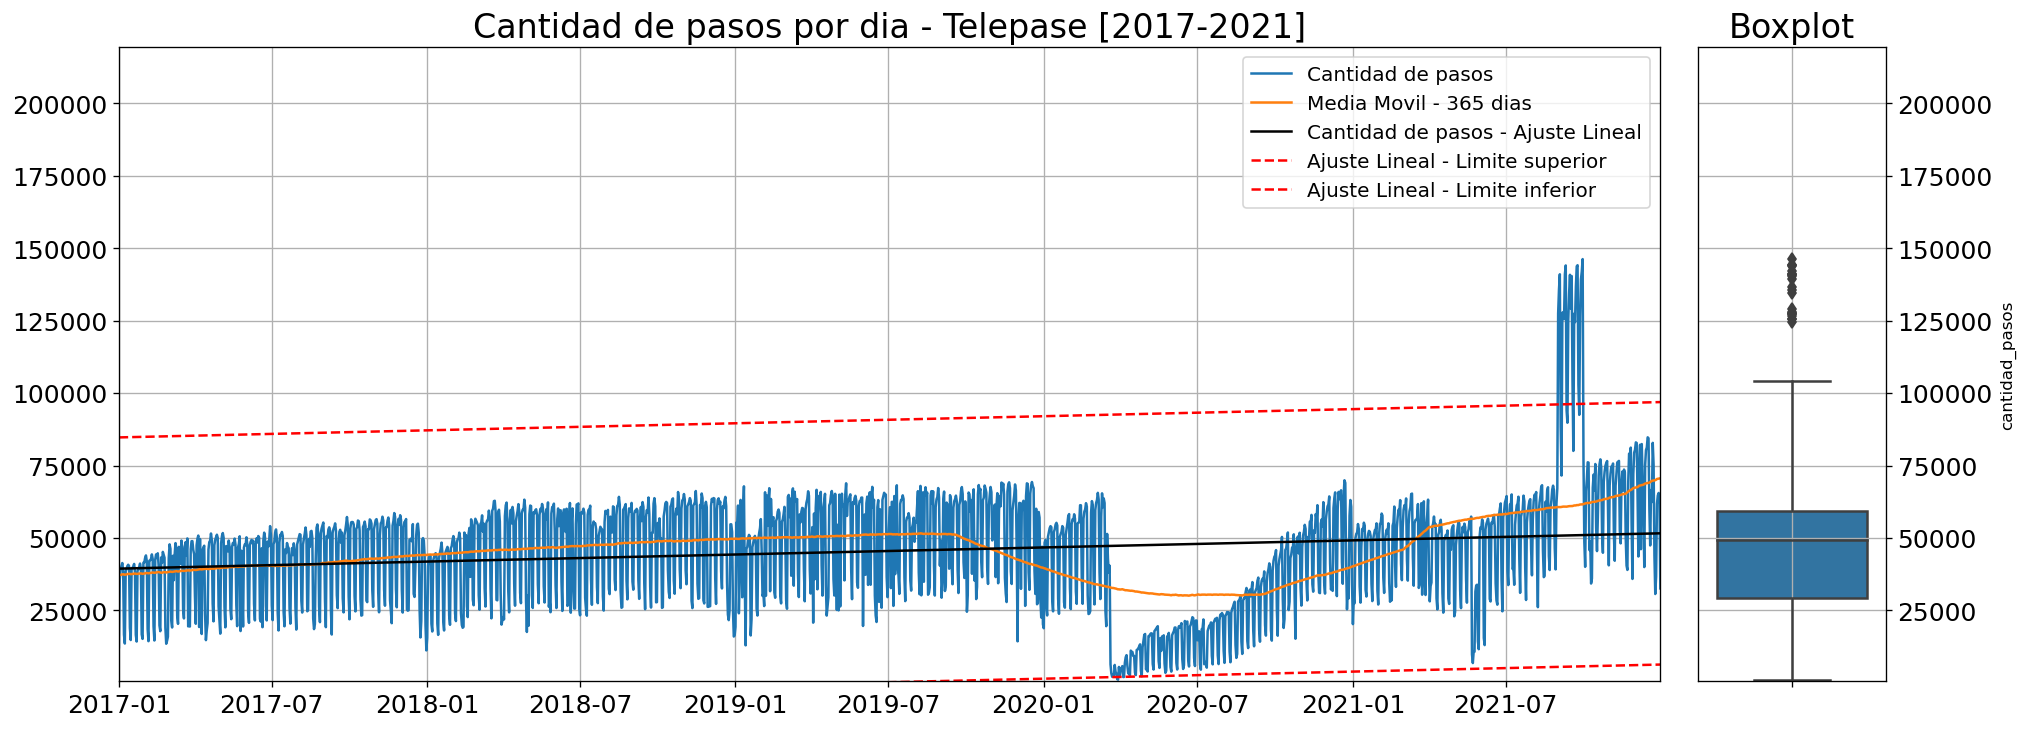

In [1432]:
plot_time(data_2017_2021,"- Telepase [2017-2021]","D")

### Prediciones

#### Diaria

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

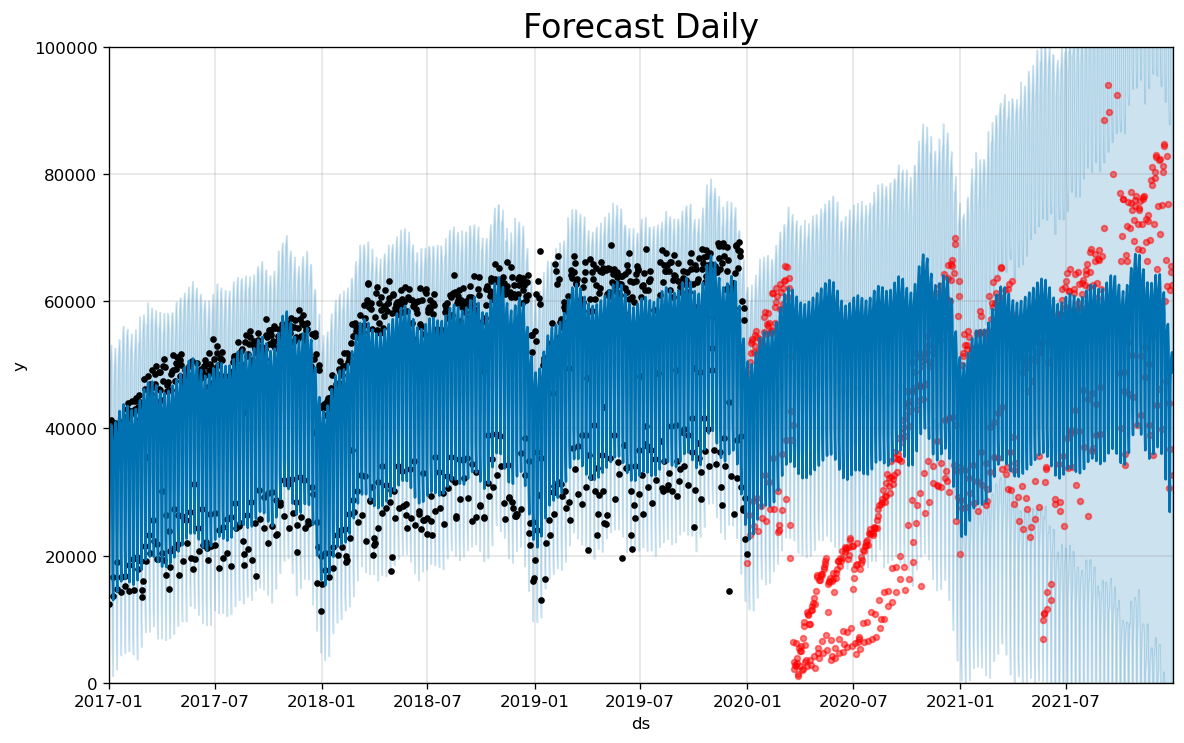

In [1435]:
data_2017_2019.reset_index("fecha",inplace=True)
prophet_data_2017_2019 = pd.DataFrame({'ds':data_2017_2019.fecha, 'y':data_2017_2019.cantidad_pasos})
data_2017_2019.set_index("fecha", inplace=True)

# separacion = '2019-10-01'
prophet_fore = prophet_data_2017_2019
# prophet_fore

data_2020_2021 = pd.concat([data_2020_,data_2021_])
data_2020_2021.reset_index("fecha",inplace=True)
prophet_data_2020_2021 = pd.DataFrame({'ds':data_2020_2021.fecha, 'y':data_2020_2021.cantidad_pasos})
data_2020_2021.set_index("fecha", inplace=True)

diario_datos_test = prophet_data_2020_2021
# diario_datos_test

prophet_2017_2019_model = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_2017_2019_model.fit(prophet_fore)
pred_prophet_2017_2019 = prophet_2017_2019_model.make_future_dataframe(periods=366+365, freq="D")
forecast_2017_2019 = prophet_2017_2019_model.predict(pred_prophet_2017_2019)

plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2017-01-01","2021-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(0,
           100000)
plt.title('Forecast Daily', fontsize=20)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

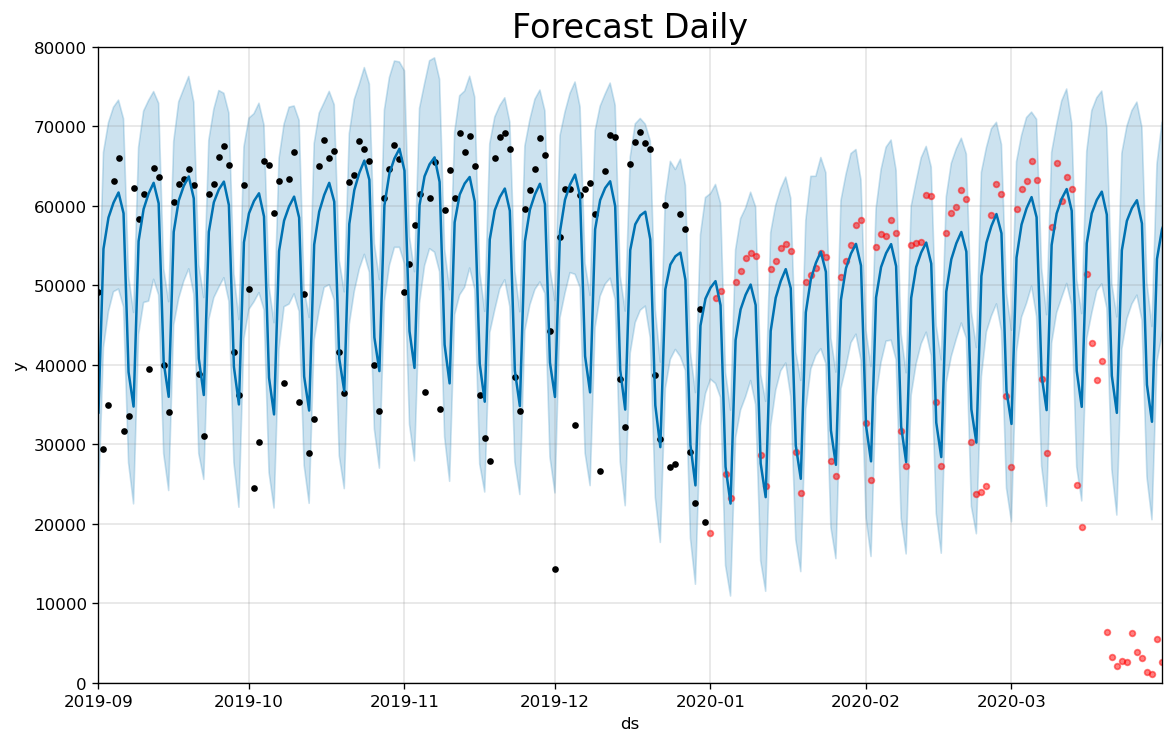

In [1409]:
plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-09-01","2020-03-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(0,
           80000)
plt.title('Forecast Daily', fontsize=20)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 864x216 with 0 Axes>

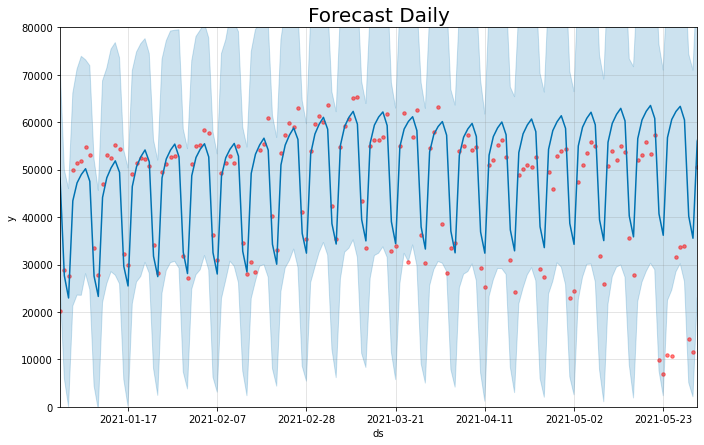

In [1034]:
plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2021-01-01","2021-05-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(0,
           80000)
plt.title('Forecast Daily', fontsize=20)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

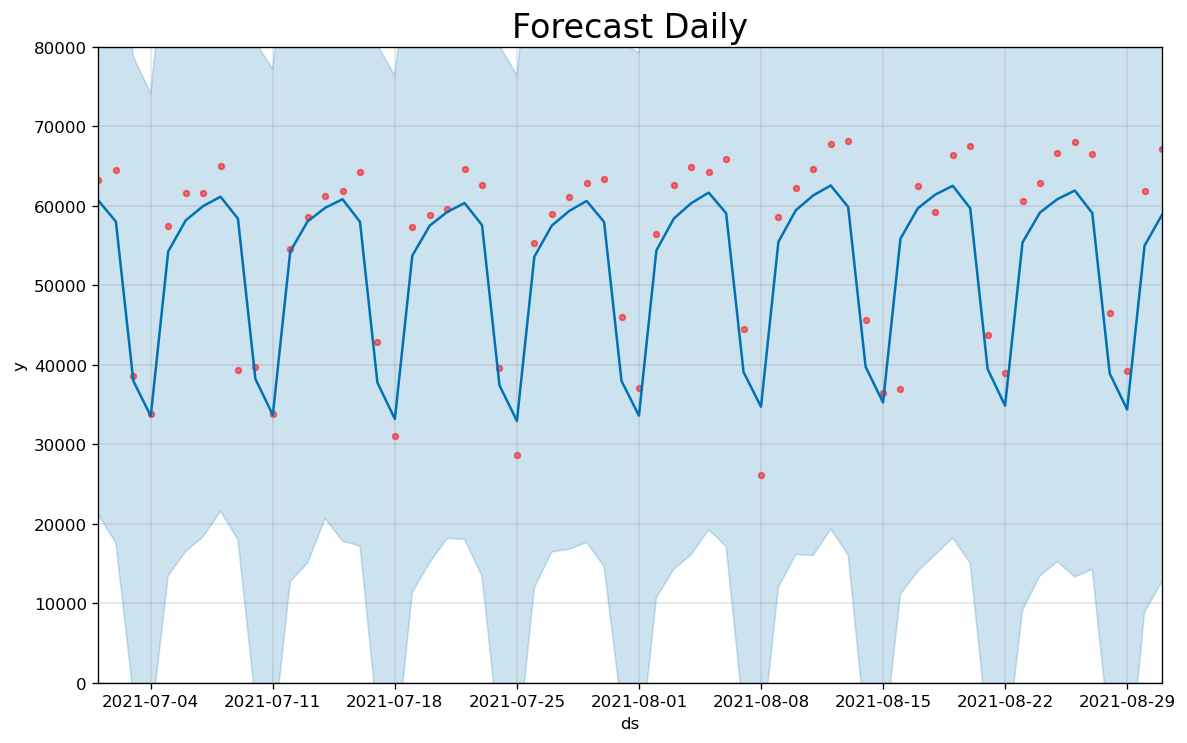

In [1436]:
plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2021-07-01","2021-08-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(0,
           80000)
plt.title('Forecast Daily', fontsize=20)

#### Semanal

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

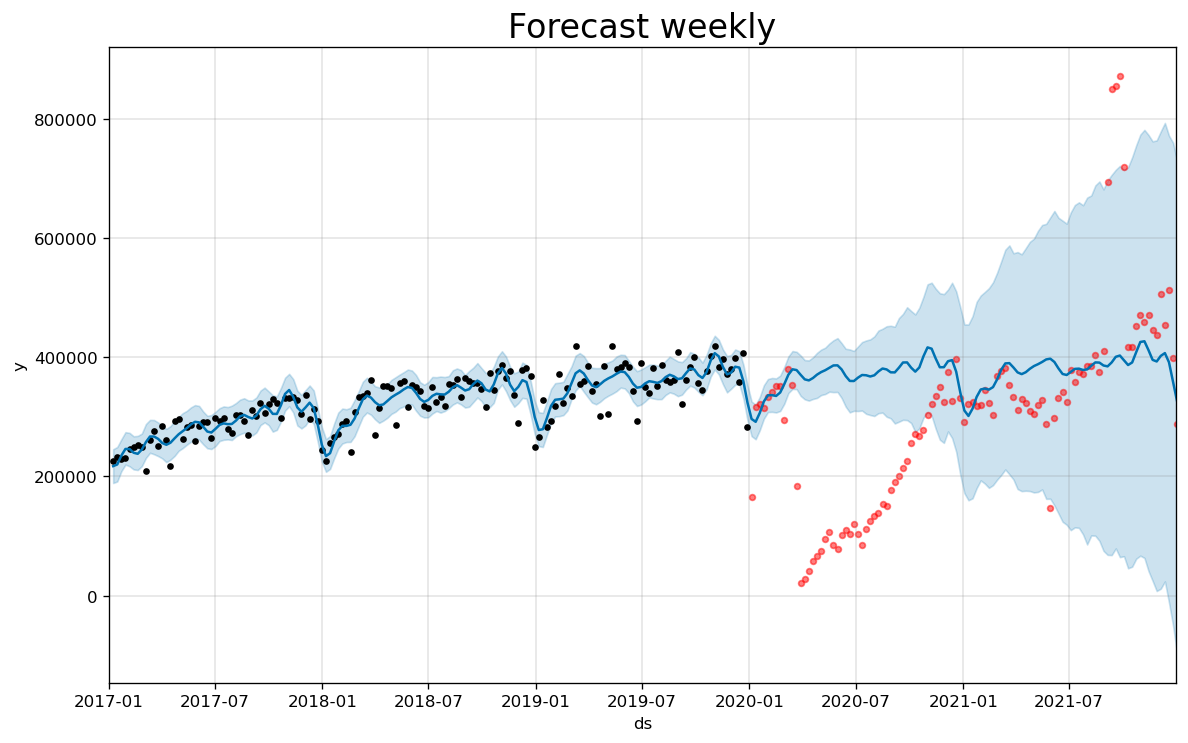

In [1437]:
# data_2020_2021_semanal

# data_2017_2019_semanal


data_2017_2019_semanal.reset_index("fecha",inplace=True)
prophet_data_2017_2019_semanal = pd.DataFrame({'ds':data_2017_2019_semanal.fecha, 'y':data_2017_2019_semanal.cantidad_pasos})
data_2017_2019_semanal.set_index("fecha", inplace=True)

# separacion = '2019-10-01'
prophet_fore = prophet_data_2017_2019_semanal
# prophet_fore

# data_2020_2021_semanal = pd.concat([data_2020_,data_2021_])
data_2020_2021_semanal.reset_index("fecha",inplace=True)
prophet_data_2020_2021_semanal = pd.DataFrame({'ds':data_2020_2021_semanal.fecha, 'y':data_2020_2021_semanal.cantidad_pasos})
data_2020_2021_semanal.set_index("fecha", inplace=True)

diario_datos_test = prophet_data_2020_2021_semanal
# diario_datos_test

prophet_2017_2019_model = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_2017_2019_model.fit(prophet_fore)
pred_prophet_2017_2019 = prophet_2017_2019_model.make_future_dataframe(periods=53+52, freq="W")
forecast_2017_2019 = prophet_2017_2019_model.predict(pred_prophet_2017_2019)

plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2017-01-01","2021-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

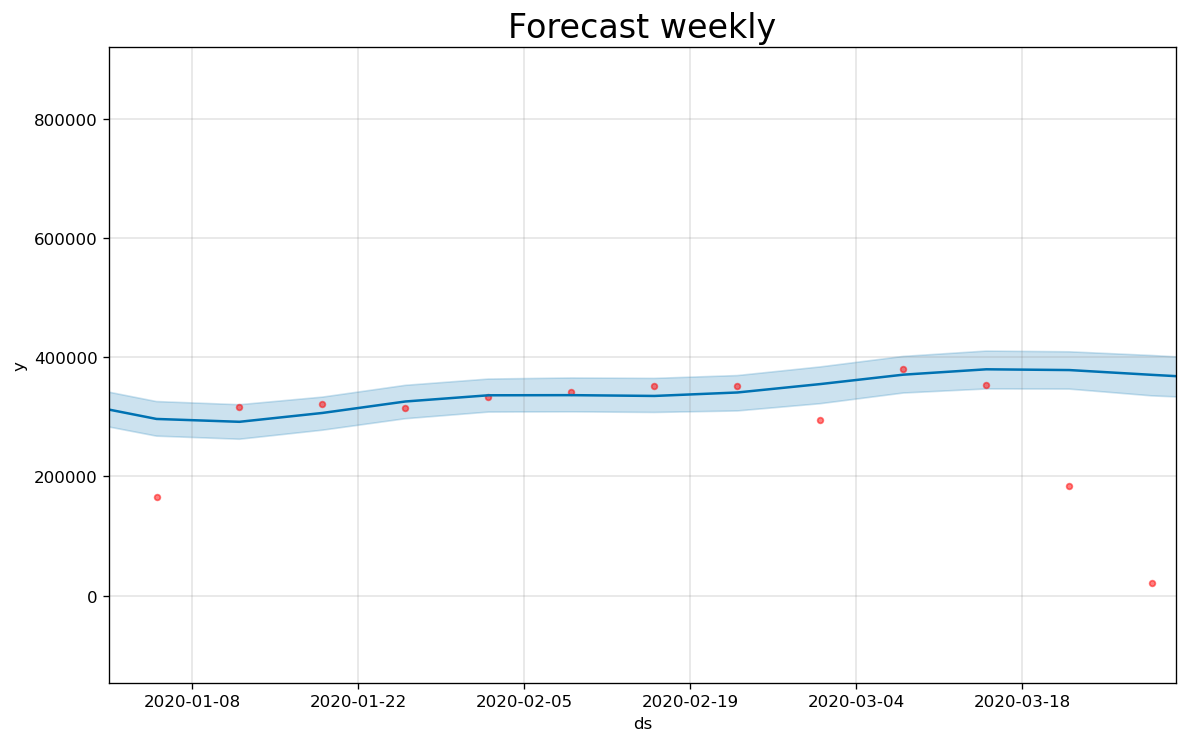

In [1438]:
plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2020-01-01","2020-03-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

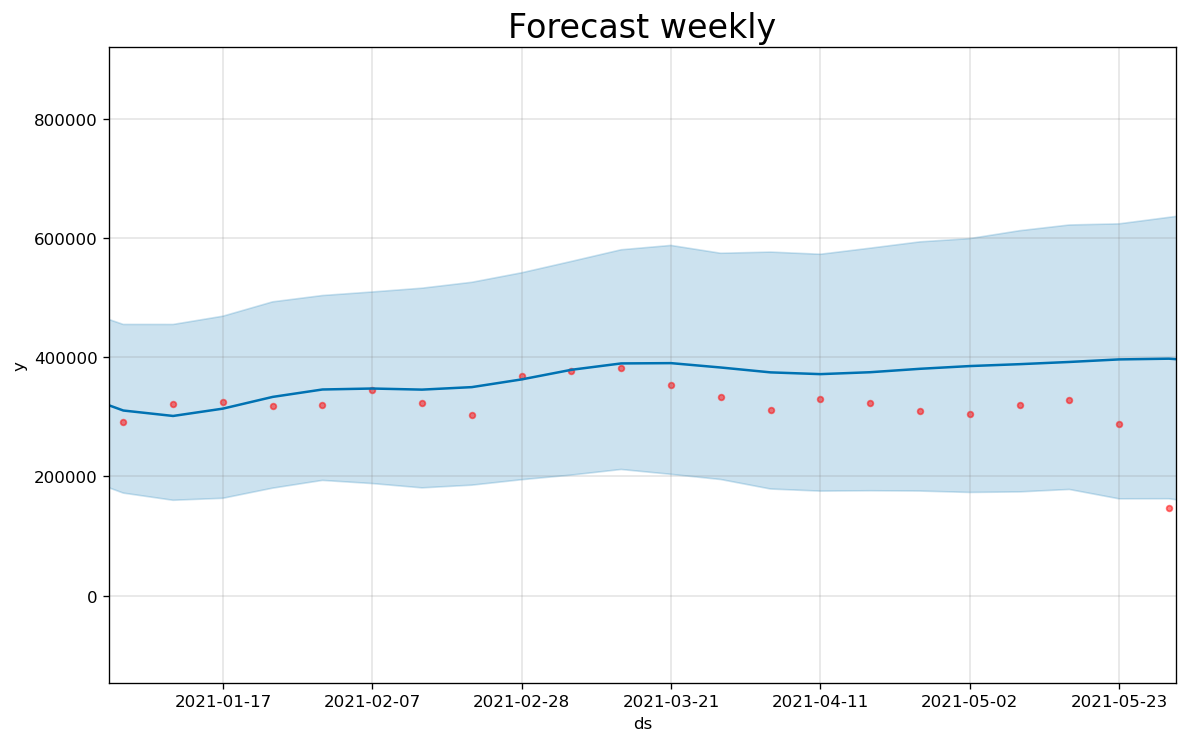

In [1439]:
# "2021-01-01","2021-05-31"
plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2021-01-01","2021-05-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

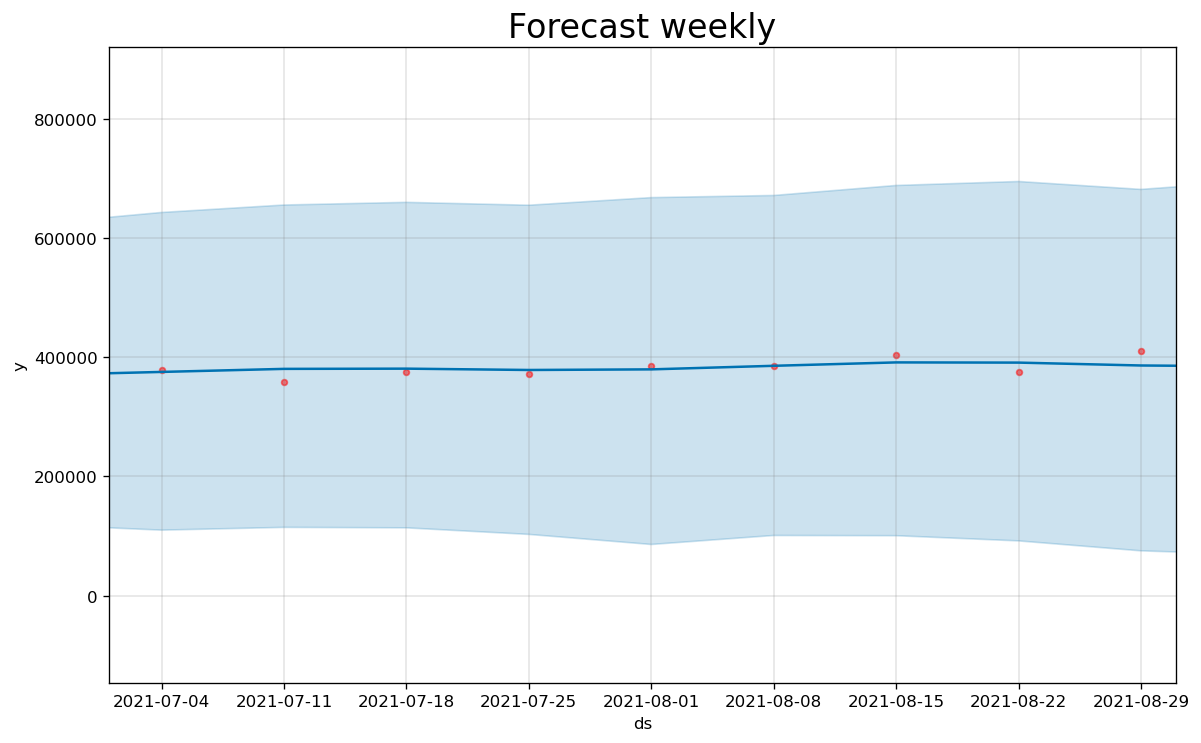

In [1440]:
# "2021-01-01","2021-05-31"
plt.figure(figsize=(12,3))
fig1 = prophet_2017_2019_model.plot(forecast_2017_2019)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2021-07-01","2021-08-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

Pregunta 1: ¿Se mantendrá la misma tendencia?
- Se mantiene la tendencia, con un incremento anormal en el último trimestre del 2021.

Pregunta 2: ¿Se obtendría buenas predicciones, con los datos de los años 2017, 2018 y 2019?
- En los periodos donde no hubo cuarentena entre el 2020 y el 2021, se puede observar que la precisión de los modelos se diario y semanales han sido bastante buenas.